<a href="https://www.kaggle.com/code/s4vyss/reinforcementagent?scriptVersionId=181058013" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/binanceusdbtc/train (2).csv
/kaggle/input/binanceusdbtc/valid.csv
/kaggle/input/binanceusdbtc/test.csv
/kaggle/input/tfprioritizedreplaybuffer/TFPrioritizedReplayBuffer.py


1. **Train, test, valid** DONE
2. **Check why only performs one action** DONE
3. **Figure out a way with tensorboard, and other visualization/logging methods**
4. Checkout the things with the action DONE
5. Checkout the algorithm from the repo INVALID
6. Understand the model better, and tune it 
7. look how to get the z cols DONE
8. use the trademaster feature creator https://github.dev/TradeMaster-NTU/TradeMaster/blob/1.0.0/tutorial/Tutorial9_Feature_Generation.ipynb INVALID
9. Try to design a better reward function, that would take exceeding safety threshold into account

## 10. Transform the driver into Episode driver, (includes, changing the agent, net etc. INVALID

In [64]:
!pip install tf-agents[reverb]

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.1
    Uninstalling typing_extensions-4.12.1:
      Successfully uninstalled typing_extensions-4.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
sqlalchemy 2.0.25 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 

In [65]:
!pip install gym-trading-env stable-baselines3[extra] sb3-contrib pydantic

  Using cached typing_extensions-4.12.1-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.1-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompat

In [66]:
import gymnasium as gym
import gym_trading_env

In [67]:
import tf_agents

def compute_rsi(close_prices, window=14):
    """
    Compute the Relative Strength Index (RSI) for a given series of close prices.
    
    Parameters:
    - close_prices (pd.Series): Series of close prices.
    - window (int): Window size for computing RSI. Default is 14.
    
    Returns:
    - rsi (pd.Series): Series containing RSI values.
    """
    delta = close_prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(close_prices, short_window=12, long_window=26, signal_window=9):
    """
    Compute the Moving Average Convergence Divergence (MACD) for a given series of close prices.
    
    Parameters:
    - close_prices (pd.Series): Series of close prices.
    - short_window (int): Short window size for MACD. Default is 12.
    - long_window (int): Long window size for MACD. Default is 26.
    - signal_window (int): Signal window size for MACD. Default is 9.
    
    Returns:
    - macd (pd.Series): Series containing MACD values.
    """
    short_ema = close_prices.ewm(span=short_window, min_periods=1).mean()
    long_ema = close_prices.ewm(span=long_window, min_periods=1).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1).mean()
    macd = macd_line - signal_line
    return macd

def detect_bullish_engulfing(df):
    """
    Detect bullish engulfing candlestick pattern in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing OHLC data.
    
    Returns:
    - bullish_engulfing (pd.Series): Series indicating bullish engulfing pattern (1 for True, 0 for False).
    """
    bullish_engulfing = np.zeros(len(df))
    for i in range(1, len(df)):
        if df['open'].iloc[i] < df['close'].iloc[i-1] and df['close'].iloc[i] > df['open'].iloc[i-1] and \
           df['close'].iloc[i] > df['open'].iloc[i] and df['open'].iloc[i] < df['close'].iloc[i-1]:
            bullish_engulfing[i] = 1
    return pd.Series(bullish_engulfing, index=df.index)

for key, df in enumerate([train, valid, test]):
    for column in ["open", "high", "low"]:
        df["feature_z_"+column] = df[column] / df["close"] - 1
    df["feature_z_close"] = df["close"] / df["close"].shift(1) - 1
    df["feature_adj_close"] = df["close"] * 0.8535
    df["feature_z_adj_close"] = df["feature_adj_close"] / df["feature_adj_close"].shift(1) - 1
    
    for column in range(5, 31, 5):
        df["feature_z_d"+str(column)] = (df['feature_adj_close'].rolling(window=5, min_periods=1).sum() / 5) / df["feature_adj_close"] - 1

    df['feature_price_spread'] = df['high'] - df['low']
    df['feature_price_momentum'] = df['close'].diff()  # Change in close price
    df['feature_rsi'] = compute_rsi(df['close'])  # Relative Strength Index (RSI)
    df['feature_ema_10'] = df['close'].ewm(span=10, adjust=False).mean()  # 10-period Exponential Moving Average

    # Volume-related features
    df['feature_volume_spread'] = df['high'] - df['low']
    df['feature_volume_momentum'] = df['volume'].diff()  # Change in volume
    df['feature_vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()  # Volume Weighted Average Price

    # Candlestick patterns and technical indicators
    df['feature_bullish_engulfing'] = detect_bullish_engulfing(df)  # Bullish Engulfing Candlestick Pattern
    df['feature_macd'] = compute_macd(df['close'])  # Moving Average Convergence Divergence (MACD)

    # Time-related features
    df['feature_hour_of_day'] = df['date_close'].dt.hour
    df['feature_day_of_week'] = df['date_close'].dt.dayofweek

    # Derived features
    df['feature_price_rate_of_change'] = df['close'].pct_change() * 100
    df['feature_volume_rate_of_change'] = df['volume'].pct_change() * 100
    df['feature_price_to_volume_ratio'] = df['close'] / df['volume']
    
    df["feature_close"] = df["close"]

    df["feature_open"] = df["open"]

    df["feature_high"] = df["high"]

    df["feature_low"] = df["low"]

    df["feature_volume"] = df["volume"]
    
    df['price_spread'] = df['high'] - df['low']
    df['price_momentum'] = df['close'].diff()  # Change in close price
    
    df.dropna(inplace= True)
    df.to_csv(f"data{key}.csv", index=False)
    

In [68]:
train = pd.DataFrame(pd.read_csv("/kaggle/input/binanceusdbtc/train (2).csv"))
test = pd.DataFrame(pd.read_csv("/kaggle/input/binanceusdbtc/test.csv"))
valid = pd.DataFrame(pd.read_csv("/kaggle/input/binanceusdbtc/valid.csv"))

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999833 entries, 0 to 1999832
Data columns (total 39 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   open                           float64
 1   high                           float64
 2   low                            float64
 3   close                          float64
 4   volume                         float64
 5   date_close                     object 
 6   feature_z_open                 float64
 7   feature_z_high                 float64
 8   feature_z_low                  float64
 9   feature_z_close                float64
 10  feature_adj_close              float64
 11  feature_z_adj_close            float64
 12  feature_z_d5                   float64
 13  feature_z_d10                  float64
 14  feature_z_d15                  float64
 15  feature_z_d20                  float64
 16  feature_z_d25                  float64
 17  feature_z_d30                  float64
 18  fe

In [70]:
train.drop(columns=["date_close"], inplace=True)
valid.drop(columns=["date_close"], inplace=True)
test.drop(columns=["date_close"], inplace=True)

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999833 entries, 0 to 1999832
Data columns (total 38 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   open                           float64
 1   high                           float64
 2   low                            float64
 3   close                          float64
 4   volume                         float64
 5   feature_z_open                 float64
 6   feature_z_high                 float64
 7   feature_z_low                  float64
 8   feature_z_close                float64
 9   feature_adj_close              float64
 10  feature_z_adj_close            float64
 11  feature_z_d5                   float64
 12  feature_z_d10                  float64
 13  feature_z_d15                  float64
 14  feature_z_d20                  float64
 15  feature_z_d25                  float64
 16  feature_z_d30                  float64
 17  feature_price_spread           float64
 18  fe

In [72]:
z_cols = [col for col in train.columns if col.startswith('z_')]
train[z_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999833 entries, 0 to 1999832
Empty DataFrame


In [73]:
train[z_cols].head()

""
0
1
2
3
4


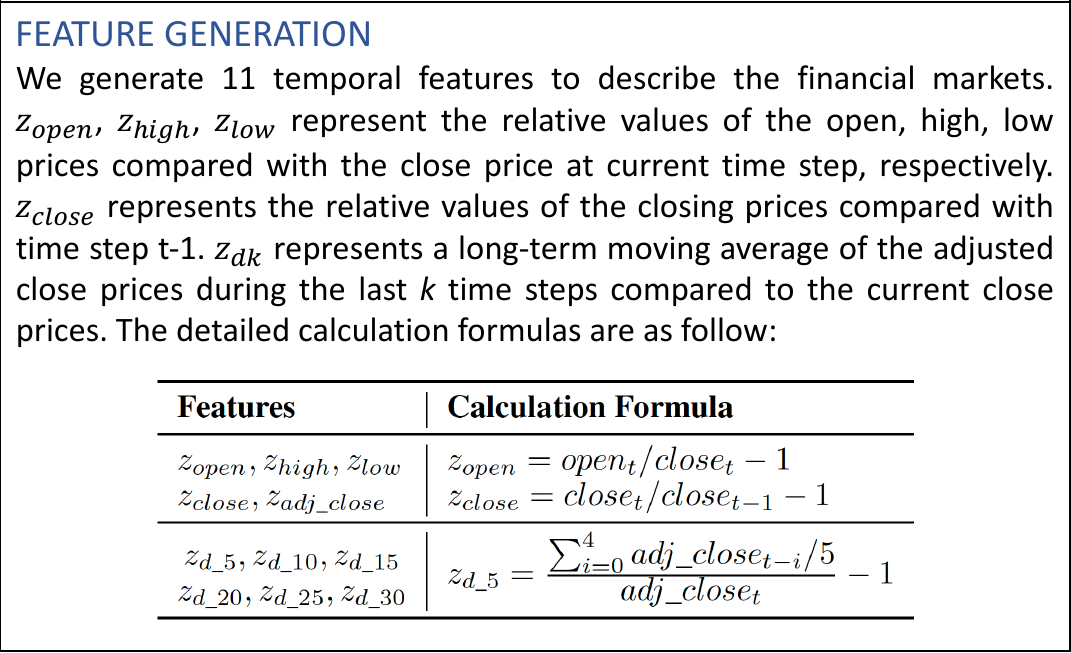

df['price_spread'] = df['high'] - df['low']
    df['price_momentum'] = df['close'].diff()  # Change in close price
    df['rsi'] = compute_rsi(df['close'])  # Relative Strength Index (RSI)
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()  # 10-period Exponential Moving Average

    # Volume-related features
    df['volume_spread'] = df['high'] - df['low']
    df['volume_momentum'] = df['volume'].diff()  # Change in volume
    df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()  # Volume Weighted Average Price

    # Candlestick patterns and technical indicators
    df['bullish_engulfing'] = detect_bullish_engulfing(df)  # Bullish Engulfing Candlestick Pattern
    df['macd'] = compute_macd(df['close'])  # Moving Average Convergence Divergence (MACD)

    # Time-related features
    df['hour_of_day'] = df['date_close'].dt.hour
    df['day_of_week'] = df['date_close'].dt.dayofweek

    # Derived features
    df['price_rate_of_change'] = df['close'].pct_change() * 100
    df['volume_rate_of_change'] = df['volume'].pct_change() * 100
    df['price_to_volume_ratio'] = df['close'] / df['volume']

In [74]:
train.head()

,open,high,low,close,volume,feature_z_open,feature_z_high,feature_z_low,feature_z_close,feature_adj_close,...,feature_price_rate_of_change,feature_volume_rate_of_change,feature_price_to_volume_ratio,feature_close,feature_open,feature_high,feature_low,feature_volume,price_spread,price_momentum
0,13740.00,13744.98,13710.14,13733.71,6.008703,0.000458,0.000821,-0.001716,-0.000821,11721.721485,...,-0.082139,346.051591,2285.636351,13733.71,13740.00,13744.98,13710.14,6.008703,34.84,-11.29
1,13733.71,13733.71,13700.00,13700.00,8.010931,0.002461,0.002461,0.000000,-0.002455,11692.950000,...,-0.245454,33.322133,1710.163276,13700.00,13733.71,13733.71,13700.00,8.010931,33.71,-33.71
2,13700.00,13733.68,13666.00,13685.77,8.459800,0.001040,0.003501,-0.001445,-0.001039,11680.804695,...,-0.103869,5.603206,1617.741554,13685.77,13700.00,13733.68,13666.00,8.459800,67.68,-14.23
3,13685.77,13700.00,13666.02,13699.00,8.557351,-0.000966,0.000073,-0.002407,0.000967,11692.096500,...,0.096670,1.153112,1600.845869,13699.00,13685.77,13700.00,13666.02,8.557351,33.98,13.23
4,13666.06,13698.99,13652.93,13653.02,5.649264,0.000955,0.003367,-0.000007,-0.003356,11652.852570,...,-0.335645,-33.983496,2416.778540,13653.02,13666.06,13698.99,13652.93,5.649264,46.06,-45.98


In [75]:
import numpy as np

num_elements_edges = 5  # Near -2 and 2
num_elements_center = 29  # Near 0
num_elements_transition = 4  # Transition regions

# Create ranges for each section
range_edges = np.linspace(-2, -1, num_elements_edges // 2).tolist() + \
              np.linspace(-1, 1, num_elements_transition).tolist() + \
              np.linspace(1, 2, num_elements_edges // 2).tolist()

range_center = np.linspace(-2, 2, num_elements_center).tolist()

# Include 0, 1, and -1
actions = [-1, 0, 1]

# Concatenate the ranges with the additional actions
positions = actions + range_edges + range_center
positions = [-1, 0, 1, -2.0, -1.0, -1.0, -0.33333333333333337, 0.33333333333333326, 1.0, 1.0, 2.0, -2.0, -1.8571428571428572, -1.7142857142857144, -1.5714285714285714, -1.4285714285714286, -1.2857142857142858, -1.1428571428571428, -1.0, -0.8571428571428572, -0.7142857142857144, -0.5714285714285716, -0.4285714285714286, -0.2857142857142858, -0.14285714285714302, 0.0, 0.1428571428571428, 0.2857142857142856, 0.4285714285714284, 0.5714285714285712, 0.714285714285714, 0.8571428571428568, 1.0, 1.1428571428571428, 1.2857142857142856, 1.4285714285714284, 1.5714285714285712, 1.714285714285714, 1.8571428571428568, 2.0]

In [76]:
import numpy as np

def reward_function(history):
    portfolio_growth = history["portfolio_valuation", -1] / history["portfolio_valuation", -2]
    reward = np.log(portfolio_growth)
    return reward


In [77]:
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df=train[:100_000],
        positions = positions, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        verbose=1,
        windows=5,
        reward_function = reward_function
)

In [83]:
import tensorflow as tf
from tensorflow import keras

In [84]:
from tf_agents.environments import TFPyEnvironment, suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tensorflow.python.framework import tensor_spec as tensor_s

class ModifiedTimeStep(ts.TimeStep):
    def __new__(cls, step_type, reward, discount, observation, info):
        return super(ModifiedTimeStep, cls).__new__(cls, step_type, reward, discount, observation, info)

class GymWrapper(py_environment.PyEnvironment):
    def __init__(self, gym_env):
        super(GymWrapper, self).__init__()
        self._gym_env = gym_env
        self._action_spec = self._get_action_spec()
        self._observation_spec = self._get_observation_spec()
                                   # 'observation': array_spec.ArraySpec(shape=(33,), dtype=np.float32, name="Observation"),
                                    #'info': array_spec.ArraySpec(shape=(21, ), dtype=np.object_, name="Info")
                                 #}
        self._reward_spec = self._get_reward_spec()
        self._step_type_spec = self._get_step_type_spec()
        self._discount_spec = self._get_discount_spec()
        self._info_buffer = []
          
    def _get_reward_spec(self):
        return tf.TensorSpec(shape=(), dtype=np.float32, name='reward')
        
    def _get_action_spec(self):
        action_space = self._gym_env.action_space
        if isinstance(action_space, gym.spaces.Box):
            return tensor_s.BoundedTensorSpec(
                shape=action_space.shape,
                dtype=action_space.dtype,
                minimum=action_space.low,
                maximum=action_space.high
            )
        elif isinstance(action_space, gym.spaces.Discrete):
            return tensor_s.BoundedTensorSpec(
                shape=(),
                dtype=action_space.dtype,
                minimum=0,
                maximum=action_space.n-1
            )
        else:
            raise ValueError(f"Unsupported action space type: {type(action_space)}")

    def _get_observation_spec(self):
        observation_space = self._gym_env.observation_space
        return tf.TensorSpec(
            shape=observation_space.shape,
            dtype=observation_space.dtype
        )
    
    def _get_step_type_spec(self):
        return tf.TensorSpec(shape=(), dtype=np.int32, name='step_type')
    
    def _get_discount_spec(self):
        return tensor_s.BoundedTensorSpec(shape=(), dtype=np.float32, name='discount', minimum=0.0, maximum=1.0)

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def reward_spec(self):
        return self._reward_spec
    
    def step_type_spec(self):
        return self._step_type_spec

    def discount_spec(self):
        return self._discount_spec
    
    def logging_buffer(self):
        return self._info_buffer[-1]

    def _reset(self):
        obs = self._gym_env.reset()

        # Check if obs is a tuple/list containing the observation array and info dict
        if isinstance(obs, tuple) or isinstance(obs, list):
            observation = obs[0]  # Extract the actual observation array
        else:
            observation = obs  # obs is already the observation array

        return ts.restart(observation)

    def _step(self, action):
        obs, reward, done, truncated, info = self._gym_env.step(action)
        
        self._info_buffer.append(info)
        
        if 'portfolio_valuation' in info and info['portfolio_valuation'] < 100:
            print("episode terminated", obs, info)
            self._gym_env.reset()
            return ts.termination(obs, reward)

        if done or truncated:
            print("episode terminated", obs, info)
            self._gym_env.reset()
            return ts.termination(obs, reward)
        
        return ts.transition(obs, reward)

In [85]:
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df=train,
        positions = positions, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        verbose=1,
        reward_function = lambda history: reward_function(history)
)

tf_env = GymWrapper(env)

#tf_env = TFPyEnvironment(gym_env)

In [89]:
import tensorflow as tf
import tf_agents
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"TF-Agents version: {tf_agents.__version__}")


TensorFlow version: 2.15.0
Keras version: 2.15.0
TF-Agents version: 0.19.0


In [90]:
from tf_agents.environments import tf_py_environment
tf_env = tf_py_environment.TFPyEnvironment(tf_env)

In [91]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.networks import encoding_network
from tf_agents.networks import value_network

lstm_size=(512,)

# Combine the encoding and value networks
q_net = QRnnNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    lstm_size=lstm_size,
)

train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250_000,
    end_learning_rate=0.01
)

agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2_000,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_step,
    epsilon_greedy=lambda: epsilon_fn(train_step)
)

agent.initialize()

In [92]:
import sys
sys.path.append("/kaggle/input/tfprioritizedreplaybuffer")

In [93]:
from TFPrioritizedReplayBuffer import TFPrioritizedReplayBuffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=1,
    max_length=1_000_000
)

replay_buffer_observer = replay_buffer.add_batch

In [94]:
q_net.summary()

Model: "QRnnNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EncodingNetwork (EncodingN  multiple                  5590      
 etwork)                                                         
                                                                 
 dynamic_unroll_2 (DynamicU  multiple                  1132544   
 nroll)                                                          
                                                                 
 dense_10 (Dense)            multiple                  38475     
                                                                 
 dense_11 (Dense)            multiple                  3040      
                                                                 
 num_action_project/dense (  multiple                  1640      
 Dense)                                                          
                                                       

In [95]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [97]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [98]:
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.policies import py_tf_eager_policy

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [109]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
init_driver = DynamicEpisodeDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20_000)],
    num_episodes=1
)

final_time_step, final_policy_state = init_driver.run()

15000/20000episode terminated [ 1.3869788e-03  1.3869788e-03  0.0000000e+00 -1.3850577e-03
  1.1667345e+04 -1.3850577e-03  1.3483540e-03  1.3483540e-03
  1.3483540e-03  1.3483540e-03  1.3483540e-03  1.3483540e-03
  1.8959999e+01 -1.8959999e+01  6.6491333e+01  1.3663591e+04
  1.8959999e+01  5.1953292e+00  1.4803470e+04  0.0000000e+00
  3.3060584e+00  1.2000000e+01  3.0000000e+00 -1.3850577e-01
  7.3905251e+01  1.1181963e+03  1.3670000e+04  1.3688960e+04
  1.3688960e+04  1.3670000e+04  1.2225045e+01  2.0000000e+00
  2.0027821e+00] {'idx': 15085, 'step': 15085, 'date': 15085, 'position_index': array(39), 'position': 2.0, 'real_position': 2.002782110756129, 'data_volume': 12.225045, 'data_close': 13670.0, 'data_low': 13670.0, 'data_high': 13688.96, 'data_open': 13688.96, 'data_price_momentum': -18.959999999999127, 'data_price_spread': 18.959999999999127, 'portfolio_valuation': 99.71415362823477, 'portfolio_distribution_asset': 0.01460905070049868, 'portfolio_distribution_fiat': 0, 'portfol

In [116]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3
).prefetch(3)

In [117]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [118]:
from tf_agents.eval.metric_utils import log_metrics
from pathlib import Path
from logging import getLogger, Formatter, FileHandler, StreamHandler, INFO, DEBUG


def create_logger(exp_version):
    log_file = ("{}.log".format(exp_version))

    # logger
    logger_ = getLogger(exp_version)
    logger_.setLevel(DEBUG)

    # formatter
    fmr = Formatter("[%(levelname)s] %(asctime)s >>\t%(message)s")

    # file handler
    fh = FileHandler(log_file)
    fh.setLevel(DEBUG)
    fh.setFormatter(fmr)

    # stream handler
    ch = StreamHandler()
    ch.setLevel(INFO)
    ch.setFormatter(fmr)

    logger_.addHandler(fh)
    logger_.addHandler(ch)

def get_logger(exp_version):
    return getLogger(exp_version)

VERSION = "001" # 実験番号
create_logger(VERSION)

logger = get_logger(VERSION)

def log_stuff(train_metrics):
    log_metrics(train_metrics)

    metric_names = ["NumberOfEpisodes", "EnvironmentSteps", "AverageReturnMetric", "AverageEpisodeLengthMetric", "PortfolioValuationMetric"]

    for i, metric in enumerate(train_metrics):
        logger.info(f"{metric_names[i]}: {metric.result().numpy()}")

In [119]:
tf_env.reset()

TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 4.5799714e-04,  8.2060858e-04, -1.7162150e-03, -8.2138961e-04,
         1.1721722e+04, -8.2138961e-04,  9.8458468e-04,  9.8458468e-04,
         9.8458468e-04,  9.8458468e-04,  9.8458468e-04,  9.8458468e-04,
         3.4840000e+01, -1.1290000e+01,  3.6851135e+01,  1.3755354e+04,
         3.4840000e+01,  4.6616158e+00,  1.3766553e+04,  0.0000000e+00,
        -1.7463337e+00,  2.3000000e+01,  6.0000000e+00, -8.2138963e-02,
         3.4605161e+02,  2.2856362e+03,  1.3733710e+04,  1.3740000e+04,
         1.3744980e+04,  1.3710140e+04,  6.0087032e+00,  1.7142857e+00,
         1.7142857e+00]], dtype=float32)>})

In [120]:
import tensorflow as tf
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.networks import encoding_network, value_network
import logging
import psutil
import numpy as np

portfolio_valuation = []

#TODO: checkpoints

# Training function
def train_agent(n_iterations):
    global reset_counter
    time_step = tf_env.reset()
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)

    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        
        print("\r{} F. straty:{:.5f}".format(iteration, train_loss.loss), end="")
        if iteration % 10_000 == 0:
            log_stuff(train_metrics)
            log = tf_env.envs[0].logging_buffer()
            portfolio_valuation.append(log['portfolio_valuation'])
            logger.info("Portfolio valuation: " + str(log['portfolio_valuation']))

In [121]:
train_agent(10_000_000)

import matplotlib.pyplot as plt

plt.plot(portfolio_valuation)
plt.xlabel('Iteration')
plt.ylabel('USD')
plt.title('Portfolio valuation')
plt.show()

[INFO] 2024-06-01 19:47:06,373 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:47:06,373 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:47:06,376 >>	EnvironmentSteps: 4
[INFO] 2024-06-01 19:47:06,376 >>	EnvironmentSteps: 4
[INFO] 2024-06-01 19:47:06,379 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:47:06,379 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:47:06,382 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:47:06,382 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:47:06,383 >>	Portfolio valuation: 1004.7957617904829
[INFO] 2024-06-01 19:47:06,383 >>	Portfolio valuation: 1004.7957617904829


999 F. straty:0.01258

[INFO] 2024-06-01 19:47:25,641 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:47:25,641 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:47:25,643 >>	EnvironmentSteps: 4004
[INFO] 2024-06-01 19:47:25,643 >>	EnvironmentSteps: 4004
[INFO] 2024-06-01 19:47:25,646 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:47:25,646 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:47:25,649 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:47:25,649 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:47:25,651 >>	Portfolio valuation: 547.6836816511003
[INFO] 2024-06-01 19:47:25,651 >>	Portfolio valuation: 547.6836816511003


1989 F. straty:0.00851

[INFO] 2024-06-01 19:47:45,417 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:47:45,417 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:47:45,420 >>	EnvironmentSteps: 8004
[INFO] 2024-06-01 19:47:45,420 >>	EnvironmentSteps: 8004
[INFO] 2024-06-01 19:47:45,422 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:47:45,422 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:47:45,425 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:47:45,425 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:47:45,427 >>	Portfolio valuation: 301.22775394579503
[INFO] 2024-06-01 19:47:45,427 >>	Portfolio valuation: 301.22775394579503


2992 F. straty:0.00116

[INFO] 2024-06-01 19:48:05,304 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:48:05,304 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:48:05,306 >>	EnvironmentSteps: 12004
[INFO] 2024-06-01 19:48:05,306 >>	EnvironmentSteps: 12004
[INFO] 2024-06-01 19:48:05,309 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:48:05,309 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:48:05,312 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:48:05,312 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:48:05,313 >>	Portfolio valuation: 192.3323521618918
[INFO] 2024-06-01 19:48:05,313 >>	Portfolio valuation: 192.3323521618918


3998 F. straty:0.00185

[INFO] 2024-06-01 19:48:24,736 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:48:24,736 >>	NumberOfEpisodes: 0
[INFO] 2024-06-01 19:48:24,739 >>	EnvironmentSteps: 16004
[INFO] 2024-06-01 19:48:24,739 >>	EnvironmentSteps: 16004
[INFO] 2024-06-01 19:48:24,741 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:48:24,741 >>	AverageReturnMetric: 0.0
[INFO] 2024-06-01 19:48:24,744 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:48:24,744 >>	AverageEpisodeLengthMetric: 0.0
[INFO] 2024-06-01 19:48:24,745 >>	Portfolio valuation: 137.49540638608622
[INFO] 2024-06-01 19:48:24,745 >>	Portfolio valuation: 137.49540638608622


4434 F. straty:0.00501episode terminated [-7.6400138e-05  1.0674797e-03 -7.7814955e-05 -2.7581331e-04
  1.2065161e+04 -2.7581331e-04  9.8145881e-04  9.8145881e-04
  9.8145881e-04  9.8145881e-04  9.8145881e-04  9.8145881e-04
  1.6190001e+01 -3.9000001e+00  4.2675327e+01  1.4146678e+04
  1.6190001e+01  6.1575222e+00  1.4638509e+04  0.0000000e+00
 -8.1384522e-01  9.0000000e+00  5.0000000e+00 -2.7581330e-02
  2.4242995e+02  1.6253174e+03  1.4136100e+04  1.4135020e+04
  1.4151190e+04  1.4135000e+04  8.6974401e+00  1.7142857e+00
  1.7146221e+00] {'idx': 17741, 'step': 17741, 'date': 17741, 'position_index': array(37), 'position': 1.714285714285714, 'real_position': 1.7146221335436986, 'data_volume': 8.69744, 'data_close': 14136.1, 'data_low': 14135.0, 'data_high': 14151.19, 'data_open': 14135.02, 'data_price_momentum': -3.899999999999636, 'data_price_spread': 16.19000000000051, 'portfolio_valuation': 99.93726261293538, 'portfolio_distribution_asset': 0.012121776334484628, 'portfolio_distribu

[INFO] 2024-06-01 19:48:44,552 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:48:44,552 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:48:44,555 >>	EnvironmentSteps: 20004
[INFO] 2024-06-01 19:48:44,555 >>	EnvironmentSteps: 20004
[INFO] 2024-06-01 19:48:44,557 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:48:44,557 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:48:44,560 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:48:44,560 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:48:44,562 >>	Portfolio valuation: 842.59379354419
[INFO] 2024-06-01 19:48:44,562 >>	Portfolio valuation: 842.59379354419


5995 F. straty:0.00430

[INFO] 2024-06-01 19:49:04,401 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:49:04,401 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:49:04,404 >>	EnvironmentSteps: 24004
[INFO] 2024-06-01 19:49:04,404 >>	EnvironmentSteps: 24004
[INFO] 2024-06-01 19:49:04,407 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:49:04,407 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:49:04,410 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:49:04,410 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:49:04,411 >>	Portfolio valuation: 536.5045548063526
[INFO] 2024-06-01 19:49:04,411 >>	Portfolio valuation: 536.5045548063526


6998 F. straty:0.00271

[INFO] 2024-06-01 19:49:24,313 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:49:24,313 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:49:24,316 >>	EnvironmentSteps: 28004
[INFO] 2024-06-01 19:49:24,316 >>	EnvironmentSteps: 28004
[INFO] 2024-06-01 19:49:24,319 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:49:24,319 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:49:24,322 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:49:24,322 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:49:24,323 >>	Portfolio valuation: 352.92592205576426
[INFO] 2024-06-01 19:49:24,323 >>	Portfolio valuation: 352.92592205576426


7991 F. straty:0.00226

[INFO] 2024-06-01 19:49:44,328 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:49:44,328 >>	NumberOfEpisodes: 1
[INFO] 2024-06-01 19:49:44,331 >>	EnvironmentSteps: 32004
[INFO] 2024-06-01 19:49:44,331 >>	EnvironmentSteps: 32004
[INFO] 2024-06-01 19:49:44,333 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:49:44,333 >>	AverageReturnMetric: -2.303215503692627
[INFO] 2024-06-01 19:49:44,336 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:49:44,336 >>	AverageEpisodeLengthMetric: 17741.0
[INFO] 2024-06-01 19:49:44,337 >>	Portfolio valuation: 153.4032657284883
[INFO] 2024-06-01 19:49:44,337 >>	Portfolio valuation: 153.4032657284883


8644 F. straty:0.00274episode terminated [ 3.5554804e-03  3.5554804e-03 -8.9072573e-06 -3.5391985e-03
  1.1498488e+04 -3.5391985e-03  4.4211172e-03  4.4211172e-03
  4.4211172e-03  4.4211172e-03  4.4211172e-03  4.4211172e-03
  4.8020000e+01 -4.7849998e+01  3.3880760e+01  1.3535017e+04
  4.8020000e+01 -2.2596300e-01  1.4662401e+04  0.0000000e+00
 -1.2108426e+01  1.8000000e+01  4.0000000e+00 -3.5391986e-01
 -4.5204163e+00  2.8227202e+03  1.3472160e+04  1.3520060e+04
  1.3520060e+04  1.3472040e+04  4.7727580e+00  1.1428572e+00
  1.1434368e+00] {'idx': 16841, 'step': 16841, 'date': 16841, 'position_index': array(33), 'position': 1.1428571428571428, 'real_position': 1.1434368285063499, 'data_volume': 4.772758, 'data_close': 13472.16, 'data_low': 13472.04, 'data_high': 13520.06, 'data_open': 13520.06, 'data_price_momentum': -47.85000000000037, 'data_price_spread': 48.01999999999862, 'portfolio_valuation': 99.77698540924166, 'portfolio_distribution_asset': 0.00846847719699496, 'portfolio_distr

[INFO] 2024-06-01 19:50:04,079 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:50:04,079 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:50:04,081 >>	EnvironmentSteps: 36004
[INFO] 2024-06-01 19:50:04,081 >>	EnvironmentSteps: 36004
[INFO] 2024-06-01 19:50:04,084 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:50:04,084 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:50:04,087 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:50:04,087 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:50:04,088 >>	Portfolio valuation: 794.8120836577875
[INFO] 2024-06-01 19:50:04,088 >>	Portfolio valuation: 794.8120836577875


9993 F. straty:0.00279

[INFO] 2024-06-01 19:50:23,657 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:50:23,657 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:50:23,661 >>	EnvironmentSteps: 40004
[INFO] 2024-06-01 19:50:23,661 >>	EnvironmentSteps: 40004
[INFO] 2024-06-01 19:50:23,664 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:50:23,664 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:50:23,667 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:50:23,667 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:50:23,668 >>	Portfolio valuation: 523.0068594335582
[INFO] 2024-06-01 19:50:23,668 >>	Portfolio valuation: 523.0068594335582


10993 F. straty:0.00147

[INFO] 2024-06-01 19:50:43,471 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:50:43,471 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:50:43,473 >>	EnvironmentSteps: 44004
[INFO] 2024-06-01 19:50:43,473 >>	EnvironmentSteps: 44004
[INFO] 2024-06-01 19:50:43,476 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:50:43,476 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:50:43,478 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:50:43,478 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:50:43,480 >>	Portfolio valuation: 302.1186496090054
[INFO] 2024-06-01 19:50:43,480 >>	Portfolio valuation: 302.1186496090054


11991 F. straty:0.00198

[INFO] 2024-06-01 19:51:03,208 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:51:03,208 >>	NumberOfEpisodes: 2
[INFO] 2024-06-01 19:51:03,211 >>	EnvironmentSteps: 48004
[INFO] 2024-06-01 19:51:03,211 >>	EnvironmentSteps: 48004
[INFO] 2024-06-01 19:51:03,214 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:51:03,214 >>	AverageReturnMetric: -3.455634355545044
[INFO] 2024-06-01 19:51:03,217 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:51:03,217 >>	AverageEpisodeLengthMetric: 17290.5
[INFO] 2024-06-01 19:51:03,218 >>	Portfolio valuation: 144.62075312568658
[INFO] 2024-06-01 19:51:03,218 >>	Portfolio valuation: 144.62075312568658


12298 F. straty:0.00218episode terminated [ 2.6192488e-02  2.7727168e-02  0.0000000e+00 -2.5523951e-02
  1.1111717e+04 -2.5523951e-02  1.6957063e-02  1.6957063e-02
  1.6957063e-02  1.6957063e-02  1.6957063e-02  1.6957063e-02
  3.6098001e+02 -3.4100000e+02  7.4070511e+01  1.3003476e+04
  3.6098001e+02  4.0233822e+00  1.4891824e+04  0.0000000e+00
  9.0530037e+01  4.0000000e+00  3.0000000e+00 -2.5523951e+00
  3.7865651e+00  1.1805670e+02  1.3019000e+04  1.3360000e+04
  1.3379980e+04  1.3019000e+04  1.1027752e+02  2.0000000e+00
  2.0537996e+00] {'idx': 14617, 'step': 14617, 'date': 14617, 'position_index': array(10), 'position': 2.0, 'real_position': 2.0537995381121044, 'data_volume': 110.277516, 'data_close': 13019.0, 'data_low': 13019.0, 'data_high': 13379.98, 'data_open': 13360.0, 'data_price_momentum': -341.0, 'data_price_spread': 360.9799999999996, 'portfolio_valuation': 98.92307142735828, 'portfolio_distribution_asset': 0.015605511821655975, 'portfolio_distribution_fiat': 0, 'portfol

[INFO] 2024-06-01 19:51:22,798 >>	NumberOfEpisodes: 3
[INFO] 2024-06-01 19:51:22,798 >>	NumberOfEpisodes: 3
[INFO] 2024-06-01 19:51:22,802 >>	EnvironmentSteps: 52004
[INFO] 2024-06-01 19:51:22,802 >>	EnvironmentSteps: 52004
[INFO] 2024-06-01 19:51:22,805 >>	AverageReturnMetric: -4.610910415649414
[INFO] 2024-06-01 19:51:22,805 >>	AverageReturnMetric: -4.610910415649414
[INFO] 2024-06-01 19:51:22,807 >>	AverageEpisodeLengthMetric: 16399.0
[INFO] 2024-06-01 19:51:22,807 >>	AverageEpisodeLengthMetric: 16399.0
[INFO] 2024-06-01 19:51:22,809 >>	Portfolio valuation: 592.3099759532789
[INFO] 2024-06-01 19:51:22,809 >>	Portfolio valuation: 592.3099759532789


13996 F. straty:0.00324

[INFO] 2024-06-01 19:51:41,388 >>	NumberOfEpisodes: 3
[INFO] 2024-06-01 19:51:41,388 >>	NumberOfEpisodes: 3
[INFO] 2024-06-01 19:51:41,391 >>	EnvironmentSteps: 56004
[INFO] 2024-06-01 19:51:41,391 >>	EnvironmentSteps: 56004
[INFO] 2024-06-01 19:51:41,393 >>	AverageReturnMetric: -4.610910415649414
[INFO] 2024-06-01 19:51:41,393 >>	AverageReturnMetric: -4.610910415649414
[INFO] 2024-06-01 19:51:41,396 >>	AverageEpisodeLengthMetric: 16399.0
[INFO] 2024-06-01 19:51:41,396 >>	AverageEpisodeLengthMetric: 16399.0
[INFO] 2024-06-01 19:51:41,397 >>	Portfolio valuation: 307.37587860540754
[INFO] 2024-06-01 19:51:41,397 >>	Portfolio valuation: 307.37587860540754


14995 F. straty:0.00189

[INFO] 2024-06-01 19:52:00,279 >>	NumberOfEpisodes: 3
[INFO] 2024-06-01 19:52:00,279 >>	NumberOfEpisodes: 3
[INFO] 2024-06-01 19:52:00,282 >>	EnvironmentSteps: 60004
[INFO] 2024-06-01 19:52:00,282 >>	EnvironmentSteps: 60004
[INFO] 2024-06-01 19:52:00,284 >>	AverageReturnMetric: -4.610910415649414
[INFO] 2024-06-01 19:52:00,284 >>	AverageReturnMetric: -4.610910415649414
[INFO] 2024-06-01 19:52:00,287 >>	AverageEpisodeLengthMetric: 16399.0
[INFO] 2024-06-01 19:52:00,287 >>	AverageEpisodeLengthMetric: 16399.0
[INFO] 2024-06-01 19:52:00,288 >>	Portfolio valuation: 185.3281021711853
[INFO] 2024-06-01 19:52:00,288 >>	Portfolio valuation: 185.3281021711853


15650 F. straty:0.00092episode terminated [ 3.2145928e-03  4.7730706e-03 -1.1925223e-05 -3.2035518e-03
  1.1451358e+04 -3.2035518e-03  5.3736544e-03  5.3736544e-03
  5.3736544e-03  5.3736544e-03  5.3736544e-03  5.3736544e-03
  6.4199997e+01 -4.3119999e+01  3.3928272e+01  1.3501811e+04
  6.4199997e+01 -1.5161254e+01  1.5059874e+04  0.0000000e+00
 -6.2612514e+00  8.0000000e+00  2.0000000e+00 -3.2035518e-01
 -6.5383316e+01  1.6714746e+03  1.3416940e+04  1.3460070e+04
  1.3480980e+04  1.3416780e+04  8.0270081e+00  1.8571428e+00
  1.8622754e+00] {'idx': 13409, 'step': 13409, 'date': 13409, 'position_index': array(38), 'position': 1.8571428571428568, 'real_position': 1.862275307991209, 'data_volume': 8.027008, 'data_close': 13416.94, 'data_low': 13416.78, 'data_high': 13480.98, 'data_open': 13460.07, 'data_price_momentum': -43.11999999999898, 'data_price_spread': 64.19999999999891, 'portfolio_valuation': 99.65952299470811, 'portfolio_distribution_asset': 0.013832771770554763, 'portfolio_dist

[INFO] 2024-06-01 19:52:19,701 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:52:19,701 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:52:19,704 >>	EnvironmentSteps: 64004
[INFO] 2024-06-01 19:52:19,704 >>	EnvironmentSteps: 64004
[INFO] 2024-06-01 19:52:19,707 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:52:19,707 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:52:19,710 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:52:19,710 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:52:19,712 >>	Portfolio valuation: 738.1861818920152
[INFO] 2024-06-01 19:52:19,712 >>	Portfolio valuation: 738.1861818920152


16991 F. straty:0.00149

[INFO] 2024-06-01 19:52:38,574 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:52:38,574 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:52:38,576 >>	EnvironmentSteps: 68004
[INFO] 2024-06-01 19:52:38,576 >>	EnvironmentSteps: 68004
[INFO] 2024-06-01 19:52:38,579 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:52:38,579 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:52:38,582 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:52:38,582 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:52:38,584 >>	Portfolio valuation: 564.7809105058825
[INFO] 2024-06-01 19:52:38,584 >>	Portfolio valuation: 564.7809105058825


17998 F. straty:0.00053

[INFO] 2024-06-01 19:52:57,486 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:52:57,486 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:52:57,493 >>	EnvironmentSteps: 72004
[INFO] 2024-06-01 19:52:57,493 >>	EnvironmentSteps: 72004
[INFO] 2024-06-01 19:52:57,496 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:52:57,496 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:52:57,499 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:52:57,499 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:52:57,500 >>	Portfolio valuation: 388.2556834573398
[INFO] 2024-06-01 19:52:57,500 >>	Portfolio valuation: 388.2556834573398


18998 F. straty:0.00064

[INFO] 2024-06-01 19:53:16,037 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:53:16,037 >>	NumberOfEpisodes: 4
[INFO] 2024-06-01 19:53:16,039 >>	EnvironmentSteps: 76004
[INFO] 2024-06-01 19:53:16,039 >>	EnvironmentSteps: 76004
[INFO] 2024-06-01 19:53:16,042 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:53:16,042 >>	AverageReturnMetric: -5.7650580406188965
[INFO] 2024-06-01 19:53:16,045 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:53:16,045 >>	AverageEpisodeLengthMetric: 15651.25
[INFO] 2024-06-01 19:53:16,046 >>	Portfolio valuation: 224.35133520495046
[INFO] 2024-06-01 19:53:16,046 >>	Portfolio valuation: 224.35133520495046


19895 F. straty:0.00094episode terminated [-4.3415311e-03  1.4471769e-03 -4.3415311e-03  4.3611918e-03
  1.1795379e+04  4.3611918e-03 -5.8681578e-03 -5.8681578e-03
 -5.8681578e-03 -5.8681578e-03 -5.8681578e-03 -5.8681578e-03
  8.0000000e+01  6.0009998e+01  6.5200813e+01  1.3726050e+04
  8.0000000e+01  1.0754166e+01  1.4657236e+04  0.0000000e+00
  1.1914649e+01  2.0000000e+01  4.0000000e+00  4.3611920e-01
  3.2267081e+02  9.8104523e+02  1.3820010e+04  1.3760010e+04
  1.3840010e+04  1.3760010e+04  1.4087026e+01 -3.3333334e-01
 -3.3527580e-01] {'idx': 16984, 'step': 16984, 'date': 16984, 'position_index': array(6), 'position': -0.33333333333333337, 'real_position': -0.3352758057577155, 'data_volume': 14.087026, 'data_close': 13820.01, 'data_low': 13760.01, 'data_high': 13840.01, 'data_open': 13760.01, 'data_price_momentum': 60.01000000000022, 'data_price_spread': 80.0, 'portfolio_valuation': 99.98827194408398, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 133.511920386

[INFO] 2024-06-01 19:53:35,323 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:53:35,323 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:53:35,326 >>	EnvironmentSteps: 80004
[INFO] 2024-06-01 19:53:35,326 >>	EnvironmentSteps: 80004
[INFO] 2024-06-01 19:53:35,328 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:53:35,328 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:53:35,331 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:53:35,331 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:53:35,333 >>	Portfolio valuation: 940.6332565781066
[INFO] 2024-06-01 19:53:35,333 >>	Portfolio valuation: 940.6332565781066


20991 F. straty:0.00063

[INFO] 2024-06-01 19:53:54,497 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:53:54,497 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:53:54,501 >>	EnvironmentSteps: 84004
[INFO] 2024-06-01 19:53:54,501 >>	EnvironmentSteps: 84004
[INFO] 2024-06-01 19:53:54,504 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:53:54,504 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:53:54,506 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:53:54,506 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:53:54,508 >>	Portfolio valuation: 524.4932883734848
[INFO] 2024-06-01 19:53:54,508 >>	Portfolio valuation: 524.4932883734848


21995 F. straty:0.00134

[INFO] 2024-06-01 19:54:12,984 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:54:12,984 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:54:12,987 >>	EnvironmentSteps: 88004
[INFO] 2024-06-01 19:54:12,987 >>	EnvironmentSteps: 88004
[INFO] 2024-06-01 19:54:12,989 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:54:12,989 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:54:12,991 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:54:12,991 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:54:12,993 >>	Portfolio valuation: 268.89614418310293
[INFO] 2024-06-01 19:54:12,993 >>	Portfolio valuation: 268.89614418310293


22992 F. straty:0.00192

[INFO] 2024-06-01 19:54:31,638 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:54:31,638 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:54:31,640 >>	EnvironmentSteps: 92004
[INFO] 2024-06-01 19:54:31,640 >>	EnvironmentSteps: 92004
[INFO] 2024-06-01 19:54:31,643 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:54:31,643 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:54:31,646 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:54:31,646 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:54:31,647 >>	Portfolio valuation: 207.81689649119713
[INFO] 2024-06-01 19:54:31,647 >>	Portfolio valuation: 207.81689649119713


23996 F. straty:0.00035

[INFO] 2024-06-01 19:54:50,121 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:54:50,121 >>	NumberOfEpisodes: 5
[INFO] 2024-06-01 19:54:50,123 >>	EnvironmentSteps: 96004
[INFO] 2024-06-01 19:54:50,123 >>	EnvironmentSteps: 96004
[INFO] 2024-06-01 19:54:50,126 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:54:50,126 >>	AverageReturnMetric: -6.918084621429443
[INFO] 2024-06-01 19:54:50,129 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:54:50,129 >>	AverageEpisodeLengthMetric: 15917.599609375
[INFO] 2024-06-01 19:54:50,130 >>	Portfolio valuation: 146.56270030399597
[INFO] 2024-06-01 19:54:50,130 >>	Portfolio valuation: 146.56270030399597


24683 F. straty:0.00036episode terminated [-1.3877561e-03  7.2886348e-07 -1.5298845e-03  1.3896846e-03
  1.1710012e+04  1.3896846e-03 -1.5246366e-03 -1.5246366e-03
 -1.5246366e-03 -1.5246366e-03 -1.5246366e-03 -1.5246366e-03
  2.1000000e+01  1.9040001e+01  6.0809940e+01  1.3695170e+04
  2.1000000e+01 -1.3339400e+00  1.4614733e+04  0.0000000e+00
  1.6719682e+00  8.0000000e+00  6.0000000e+00  1.3896847e-01
 -2.0653423e+01  2.6772034e+03  1.3719990e+04  1.3700950e+04
  1.3720000e+04  1.3699000e+04  5.1247468e+00 -4.2857143e-01
 -4.2942405e-01] {'idx': 19150, 'step': 19150, 'date': 19150, 'position_index': array(22), 'position': -0.4285714285714286, 'real_position': -0.42942405190641136, 'data_volume': 5.124747, 'data_close': 13719.99, 'data_low': 13699.0, 'data_high': 13720.0, 'data_open': 13700.95, 'data_price_momentum': 19.03999999999905, 'data_price_spread': 21.0, 'portfolio_valuation': 99.96363244393169, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 142.89042053128

[INFO] 2024-06-01 19:55:09,226 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:55:09,226 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:55:09,229 >>	EnvironmentSteps: 100004
[INFO] 2024-06-01 19:55:09,229 >>	EnvironmentSteps: 100004
[INFO] 2024-06-01 19:55:09,232 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:55:09,232 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:55:09,234 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:55:09,234 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:55:09,236 >>	Portfolio valuation: 924.8402792556938
[INFO] 2024-06-01 19:55:09,236 >>	Portfolio valuation: 924.8402792556938


25996 F. straty:0.00099

[INFO] 2024-06-01 19:55:27,614 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:55:27,614 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:55:27,618 >>	EnvironmentSteps: 104004
[INFO] 2024-06-01 19:55:27,618 >>	EnvironmentSteps: 104004
[INFO] 2024-06-01 19:55:27,621 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:55:27,621 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:55:27,624 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:55:27,624 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:55:27,626 >>	Portfolio valuation: 516.9529784313233
[INFO] 2024-06-01 19:55:27,626 >>	Portfolio valuation: 516.9529784313233


26996 F. straty:0.00072

[INFO] 2024-06-01 19:55:46,279 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:55:46,279 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:55:46,281 >>	EnvironmentSteps: 108004
[INFO] 2024-06-01 19:55:46,281 >>	EnvironmentSteps: 108004
[INFO] 2024-06-01 19:55:46,284 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:55:46,284 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:55:46,286 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:55:46,286 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:55:46,288 >>	Portfolio valuation: 262.5063726440956
[INFO] 2024-06-01 19:55:46,288 >>	Portfolio valuation: 262.5063726440956


27989 F. straty:0.00053

[INFO] 2024-06-01 19:56:05,342 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:56:05,342 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:56:05,345 >>	EnvironmentSteps: 112004
[INFO] 2024-06-01 19:56:05,345 >>	EnvironmentSteps: 112004
[INFO] 2024-06-01 19:56:05,347 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:56:05,347 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:56:05,350 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:56:05,350 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:56:05,352 >>	Portfolio valuation: 139.68787476132795
[INFO] 2024-06-01 19:56:05,352 >>	Portfolio valuation: 139.68787476132795


28998 F. straty:0.00057

[INFO] 2024-06-01 19:56:23,944 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:56:23,944 >>	NumberOfEpisodes: 6
[INFO] 2024-06-01 19:56:23,946 >>	EnvironmentSteps: 116004
[INFO] 2024-06-01 19:56:23,946 >>	EnvironmentSteps: 116004
[INFO] 2024-06-01 19:56:23,949 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:56:23,949 >>	AverageReturnMetric: -8.070591926574707
[INFO] 2024-06-01 19:56:23,951 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:56:23,951 >>	AverageEpisodeLengthMetric: 16456.166015625
[INFO] 2024-06-01 19:56:23,953 >>	Portfolio valuation: 115.20591584330835
[INFO] 2024-06-01 19:56:23,953 >>	Portfolio valuation: 115.20591584330835


29355 F. straty:0.00214episode terminated [-1.2912882e-03  0.0000000e+00 -2.4039340e-03  1.2929577e-03
  1.2135370e+04  1.2929577e-03 -7.2624412e-04 -7.2624412e-04
 -7.2624412e-04 -7.2624412e-04 -7.2624412e-04 -7.2624412e-04
  3.4180000e+01  1.8360001e+01  5.3249279e+01  1.4205997e+04
  3.4180000e+01  1.3169000e-02  1.4626695e+04  0.0000000e+00
  1.1809708e+00  0.0000000e+00  6.0000000e+00  1.2929578e-01
  2.2387110e-01  2.4117014e+03  1.4218360e+04  1.4200000e+04
  1.4218360e+04  1.4184180e+04  5.8955722e+00 -1.0000000e+00
 -1.0025953e+00] {'idx': 18690, 'step': 18690, 'date': 18690, 'position_index': array(0), 'position': -1, 'real_position': -1.0025952866426, 'data_volume': 5.895572, 'data_close': 14218.36, 'data_low': 14184.18, 'data_high': 14218.36, 'data_open': 14200.0, 'data_price_momentum': 18.360000000000586, 'data_price_spread': 34.18000000000029, 'portfolio_valuation': 99.9243819284514, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 200.10809627059177, 'po

[INFO] 2024-06-01 19:56:42,565 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:56:42,565 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:56:42,568 >>	EnvironmentSteps: 120004
[INFO] 2024-06-01 19:56:42,568 >>	EnvironmentSteps: 120004
[INFO] 2024-06-01 19:56:42,573 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:56:42,573 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:56:42,576 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:56:42,576 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:56:42,577 >>	Portfolio valuation: 748.9516937779615
[INFO] 2024-06-01 19:56:42,577 >>	Portfolio valuation: 748.9516937779615


30999 F. straty:0.00088

[INFO] 2024-06-01 19:57:01,042 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:01,042 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:01,044 >>	EnvironmentSteps: 124004
[INFO] 2024-06-01 19:57:01,044 >>	EnvironmentSteps: 124004
[INFO] 2024-06-01 19:57:01,047 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:01,047 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:01,050 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:01,050 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:01,052 >>	Portfolio valuation: 574.9079699037295
[INFO] 2024-06-01 19:57:01,052 >>	Portfolio valuation: 574.9079699037295


31991 F. straty:0.00097

[INFO] 2024-06-01 19:57:19,993 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:19,993 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:19,996 >>	EnvironmentSteps: 128004
[INFO] 2024-06-01 19:57:19,996 >>	EnvironmentSteps: 128004
[INFO] 2024-06-01 19:57:19,999 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:19,999 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:20,001 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:20,001 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:20,003 >>	Portfolio valuation: 290.1815349895186
[INFO] 2024-06-01 19:57:20,003 >>	Portfolio valuation: 290.1815349895186


32991 F. straty:0.00052

[INFO] 2024-06-01 19:57:38,574 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:38,574 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:38,576 >>	EnvironmentSteps: 132004
[INFO] 2024-06-01 19:57:38,576 >>	EnvironmentSteps: 132004
[INFO] 2024-06-01 19:57:38,579 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:38,579 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:38,582 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:38,582 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:38,584 >>	Portfolio valuation: 213.60478322496726
[INFO] 2024-06-01 19:57:38,584 >>	Portfolio valuation: 213.60478322496726


33999 F. straty:0.00055

[INFO] 2024-06-01 19:57:56,906 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:56,906 >>	NumberOfEpisodes: 7
[INFO] 2024-06-01 19:57:56,910 >>	EnvironmentSteps: 136004
[INFO] 2024-06-01 19:57:56,910 >>	EnvironmentSteps: 136004
[INFO] 2024-06-01 19:57:56,913 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:56,913 >>	AverageReturnMetric: -9.222865104675293
[INFO] 2024-06-01 19:57:56,916 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:56,916 >>	AverageEpisodeLengthMetric: 16775.142578125
[INFO] 2024-06-01 19:57:56,917 >>	Portfolio valuation: 147.4361052042818
[INFO] 2024-06-01 19:57:56,917 >>	Portfolio valuation: 147.4361052042818


34634 F. straty:0.00050episode terminated [-1.0691376e-03  0.0000000e+00 -1.0691376e-03  1.0702818e-03
  1.1974605e+04  1.0702818e-03 -8.5673557e-04 -8.5673557e-04
 -8.5673557e-04 -8.5673557e-04 -8.5673557e-04 -8.5673557e-04
  1.5000000e+01  1.5000000e+01  4.2719555e+01  1.4022833e+04
  1.5000000e+01 -3.7329171e+00  1.4503922e+04  0.0000000e+00
 -4.1174188e+00  1.7000000e+01  0.0000000e+00  1.0702819e-01
 -4.2678986e+01  2.7983984e+03  1.4030000e+04  1.4015000e+04
  1.4030000e+04  1.4015000e+04  5.0135822e+00 -1.7142857e+00
 -1.7192824e+00] {'idx': 21117, 'step': 21117, 'date': 21117, 'position_index': array(13), 'position': -1.7142857142857144, 'real_position': -1.7192823368657684, 'data_volume': 5.013582, 'data_close': 14030.0, 'data_low': 14015.0, 'data_high': 14030.0, 'data_open': 14015.0, 'data_price_momentum': 15.0, 'data_price_spread': 15.0, 'portfolio_valuation': 99.84120998299463, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 271.49643879806354, 'portfolio_

[INFO] 2024-06-01 19:58:15,809 >>	NumberOfEpisodes: 8
[INFO] 2024-06-01 19:58:15,809 >>	NumberOfEpisodes: 8
[INFO] 2024-06-01 19:58:15,811 >>	EnvironmentSteps: 140004
[INFO] 2024-06-01 19:58:15,811 >>	EnvironmentSteps: 140004
[INFO] 2024-06-01 19:58:15,814 >>	AverageReturnMetric: -10.375040054321289
[INFO] 2024-06-01 19:58:15,814 >>	AverageReturnMetric: -10.375040054321289
[INFO] 2024-06-01 19:58:15,816 >>	AverageEpisodeLengthMetric: 17317.75
[INFO] 2024-06-01 19:58:15,816 >>	AverageEpisodeLengthMetric: 17317.75
[INFO] 2024-06-01 19:58:15,818 >>	Portfolio valuation: 817.223177797302
[INFO] 2024-06-01 19:58:15,818 >>	Portfolio valuation: 817.223177797302


35999 F. straty:0.00080

[INFO] 2024-06-01 19:58:34,532 >>	NumberOfEpisodes: 8
[INFO] 2024-06-01 19:58:34,532 >>	NumberOfEpisodes: 8
[INFO] 2024-06-01 19:58:34,535 >>	EnvironmentSteps: 144004
[INFO] 2024-06-01 19:58:34,535 >>	EnvironmentSteps: 144004
[INFO] 2024-06-01 19:58:34,537 >>	AverageReturnMetric: -10.375040054321289
[INFO] 2024-06-01 19:58:34,537 >>	AverageReturnMetric: -10.375040054321289
[INFO] 2024-06-01 19:58:34,540 >>	AverageEpisodeLengthMetric: 17317.75
[INFO] 2024-06-01 19:58:34,540 >>	AverageEpisodeLengthMetric: 17317.75
[INFO] 2024-06-01 19:58:34,541 >>	Portfolio valuation: 532.7365591151129
[INFO] 2024-06-01 19:58:34,541 >>	Portfolio valuation: 532.7365591151129


36997 F. straty:0.00049

[INFO] 2024-06-01 19:58:53,250 >>	NumberOfEpisodes: 8
[INFO] 2024-06-01 19:58:53,250 >>	NumberOfEpisodes: 8
[INFO] 2024-06-01 19:58:53,254 >>	EnvironmentSteps: 148004
[INFO] 2024-06-01 19:58:53,254 >>	EnvironmentSteps: 148004
[INFO] 2024-06-01 19:58:53,257 >>	AverageReturnMetric: -10.375040054321289
[INFO] 2024-06-01 19:58:53,257 >>	AverageReturnMetric: -10.375040054321289
[INFO] 2024-06-01 19:58:53,259 >>	AverageEpisodeLengthMetric: 17317.75
[INFO] 2024-06-01 19:58:53,259 >>	AverageEpisodeLengthMetric: 17317.75
[INFO] 2024-06-01 19:58:53,261 >>	Portfolio valuation: 268.63336504519407
[INFO] 2024-06-01 19:58:53,261 >>	Portfolio valuation: 268.63336504519407


37978 F. straty:0.00166episode terminated [ 8.9686103e-03  8.9686103e-03 -5.9790732e-03 -8.8888891e-03
  1.1419830e+04 -8.8888891e-03  1.3659641e-02  1.3659641e-02
  1.3659641e-02  1.3659641e-02  1.3659641e-02  1.3659641e-02
  2.0000000e+02 -1.2000000e+02  2.4482357e+01  1.3597029e+04
  2.0000000e+02 -1.6601173e+01  1.5071098e+04  0.0000000e+00
 -1.6317299e+01  8.0000000e+00  2.0000000e+00 -8.8888890e-01
 -2.4938734e+01  2.6777859e+02  1.3380000e+04  1.3500000e+04
  1.3500000e+04  1.3300000e+04  4.9966656e+01  7.1428573e-01
  7.1094304e-01] {'idx': 13378, 'step': 13378, 'date': 13378, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7109430271479652, 'data_volume': 49.966655, 'data_close': 13380.0, 'data_low': 13300.0, 'data_high': 13500.0, 'data_open': 13500.0, 'data_price_momentum': -120.0, 'data_price_spread': 200.0, 'portfolio_valuation': 99.50376729389984, 'portfolio_distribution_asset': 0.005287108335766207, 'portfolio_distribution_fiat': 28.76225776

[INFO] 2024-06-01 19:59:12,380 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 19:59:12,380 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 19:59:12,382 >>	EnvironmentSteps: 152004
[INFO] 2024-06-01 19:59:12,382 >>	EnvironmentSteps: 152004
[INFO] 2024-06-01 19:59:12,385 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 19:59:12,385 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 19:59:12,387 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 19:59:12,387 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 19:59:12,388 >>	Portfolio valuation: 971.8205319853527
[INFO] 2024-06-01 19:59:12,388 >>	Portfolio valuation: 971.8205319853527


38997 F. straty:0.00056

[INFO] 2024-06-01 19:59:30,753 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 19:59:30,753 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 19:59:30,755 >>	EnvironmentSteps: 156004
[INFO] 2024-06-01 19:59:30,755 >>	EnvironmentSteps: 156004
[INFO] 2024-06-01 19:59:30,758 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 19:59:30,758 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 19:59:30,761 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 19:59:30,761 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 19:59:30,762 >>	Portfolio valuation: 628.7626674661801
[INFO] 2024-06-01 19:59:30,762 >>	Portfolio valuation: 628.7626674661801


39993 F. straty:0.00074

[INFO] 2024-06-01 19:59:49,485 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 19:59:49,485 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 19:59:49,487 >>	EnvironmentSteps: 160004
[INFO] 2024-06-01 19:59:49,487 >>	EnvironmentSteps: 160004
[INFO] 2024-06-01 19:59:49,490 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 19:59:49,490 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 19:59:49,492 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 19:59:49,492 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 19:59:49,494 >>	Portfolio valuation: 399.66391102426326
[INFO] 2024-06-01 19:59:49,494 >>	Portfolio valuation: 399.66391102426326


40990 F. straty:0.00063

[INFO] 2024-06-01 20:00:07,971 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 20:00:07,971 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 20:00:07,974 >>	EnvironmentSteps: 164004
[INFO] 2024-06-01 20:00:07,974 >>	EnvironmentSteps: 164004
[INFO] 2024-06-01 20:00:07,976 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 20:00:07,976 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 20:00:07,979 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 20:00:07,979 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 20:00:07,980 >>	Portfolio valuation: 196.67690176494023
[INFO] 2024-06-01 20:00:07,980 >>	Portfolio valuation: 196.67690176494023


41993 F. straty:0.00060

[INFO] 2024-06-01 20:00:26,764 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 20:00:26,764 >>	NumberOfEpisodes: 9
[INFO] 2024-06-01 20:00:26,767 >>	EnvironmentSteps: 168004
[INFO] 2024-06-01 20:00:26,767 >>	EnvironmentSteps: 168004
[INFO] 2024-06-01 20:00:26,770 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 20:00:26,770 >>	AverageReturnMetric: -11.527548789978027
[INFO] 2024-06-01 20:00:26,773 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 20:00:26,773 >>	AverageEpisodeLengthMetric: 16879.888671875
[INFO] 2024-06-01 20:00:26,774 >>	Portfolio valuation: 164.03277843593932
[INFO] 2024-06-01 20:00:26,774 >>	Portfolio valuation: 164.03277843593932


42572 F. straty:0.00026episode terminated [-7.8014508e-03  0.0000000e+00 -8.4801167e-03  7.8627924e-03
  1.1985069e+04  7.8627924e-03 -2.0328637e-03 -2.0328637e-03
 -2.0328637e-03 -2.0328637e-03 -2.0328637e-03 -2.0328637e-03
  1.1908000e+02  1.0955000e+02  2.6826981e+01  1.4061571e+04
  1.1908000e+02  1.5657264e+01  1.4629555e+04  0.0000000e+00
 -1.8434372e+01  1.9000000e+01  5.0000000e+00  7.8627920e-01
  9.8712921e+01  4.4552188e+02  1.4042260e+04  1.3932710e+04
  1.4042260e+04  1.3923180e+04  3.1518677e+01 -1.1428572e+00
 -1.1622951e+00] {'idx': 18376, 'step': 18376, 'date': 18376, 'position_index': array(17), 'position': -1.1428571428571428, 'real_position': -1.1622951021813541, 'data_volume': 31.518677, 'data_close': 14042.26, 'data_low': 13923.18, 'data_high': 14042.26, 'data_open': 13932.71, 'data_price_momentum': 109.55000000000108, 'data_price_spread': 119.07999999999991, 'portfolio_valuation': 99.86994296425554, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat'

[INFO] 2024-06-01 20:00:45,475 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:00:45,475 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:00:45,477 >>	EnvironmentSteps: 172004
[INFO] 2024-06-01 20:00:45,477 >>	EnvironmentSteps: 172004
[INFO] 2024-06-01 20:00:45,480 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:00:45,480 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:00:45,483 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:00:45,483 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:00:45,484 >>	Portfolio valuation: 790.587473051839
[INFO] 2024-06-01 20:00:45,484 >>	Portfolio valuation: 790.587473051839


43994 F. straty:0.00059

[INFO] 2024-06-01 20:01:04,279 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:01:04,279 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:01:04,281 >>	EnvironmentSteps: 176004
[INFO] 2024-06-01 20:01:04,281 >>	EnvironmentSteps: 176004
[INFO] 2024-06-01 20:01:04,284 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:01:04,284 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:01:04,287 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:01:04,287 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:01:04,288 >>	Portfolio valuation: 594.3248701110529
[INFO] 2024-06-01 20:01:04,288 >>	Portfolio valuation: 594.3248701110529


44995 F. straty:0.00093

[INFO] 2024-06-01 20:01:23,865 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:01:23,865 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:01:23,868 >>	EnvironmentSteps: 180004
[INFO] 2024-06-01 20:01:23,868 >>	EnvironmentSteps: 180004
[INFO] 2024-06-01 20:01:23,871 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:01:23,871 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:01:23,874 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:01:23,874 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:01:23,876 >>	Portfolio valuation: 315.79758007346453
[INFO] 2024-06-01 20:01:23,876 >>	Portfolio valuation: 315.79758007346453


45991 F. straty:0.00037

[INFO] 2024-06-01 20:01:43,230 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:01:43,230 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:01:43,233 >>	EnvironmentSteps: 184004
[INFO] 2024-06-01 20:01:43,233 >>	EnvironmentSteps: 184004
[INFO] 2024-06-01 20:01:43,236 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:01:43,236 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:01:43,239 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:01:43,239 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:01:43,241 >>	Portfolio valuation: 156.06138928596937
[INFO] 2024-06-01 20:01:43,241 >>	Portfolio valuation: 156.06138928596937


46998 F. straty:0.00064

[INFO] 2024-06-01 20:02:02,741 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:02:02,741 >>	NumberOfEpisodes: 10
[INFO] 2024-06-01 20:02:02,743 >>	EnvironmentSteps: 188004
[INFO] 2024-06-01 20:02:02,743 >>	EnvironmentSteps: 188004
[INFO] 2024-06-01 20:02:02,746 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:02:02,746 >>	AverageReturnMetric: -12.67992115020752
[INFO] 2024-06-01 20:02:02,749 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:02:02,749 >>	AverageEpisodeLengthMetric: 17029.400390625
[INFO] 2024-06-01 20:02:02,751 >>	Portfolio valuation: 111.30982660443874
[INFO] 2024-06-01 20:02:02,751 >>	Portfolio valuation: 111.30982660443874


47140 F. straty:0.00049episode terminated [-1.0311115e-03  0.0000000e+00 -2.0699075e-03  2.0749022e-03
  1.2217554e+04  2.0749022e-03 -1.0879763e-03 -1.0879763e-03
 -1.0879763e-03 -1.0879763e-03 -1.0879763e-03 -1.0879763e-03
  2.9629999e+01  2.9639999e+01  7.1729080e+01  1.4280363e+04
  2.9629999e+01  1.0419080e+00  1.4630896e+04  0.0000000e+00
  8.5721598e+00  1.7000000e+01  5.0000000e+00  2.0749024e-01
  8.7549408e+01  6.4134082e+03  1.4314650e+04  1.4299890e+04
  1.4314650e+04  1.4285020e+04  2.2319880e+00 -1.0000000e+00
 -1.0041645e+00] {'idx': 18272, 'step': 18272, 'date': 18272, 'position_index': array(5), 'position': -1.0, 'real_position': -1.0041644704233426, 'data_volume': 2.231988, 'data_close': 14314.65, 'data_low': 14285.02, 'data_high': 14314.65, 'data_open': 14299.89, 'data_price_momentum': 29.639999999999414, 'data_price_spread': 29.6299999999992, 'portfolio_valuation': 99.8835804387729, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 200.18312309406062

[INFO] 2024-06-01 20:02:23,070 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:02:23,070 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:02:23,072 >>	EnvironmentSteps: 192004
[INFO] 2024-06-01 20:02:23,072 >>	EnvironmentSteps: 192004
[INFO] 2024-06-01 20:02:23,075 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:02:23,075 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:02:23,078 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:02:23,078 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:02:23,080 >>	Portfolio valuation: 729.4806559019277
[INFO] 2024-06-01 20:02:23,080 >>	Portfolio valuation: 729.4806559019277


48993 F. straty:0.00028

[INFO] 2024-06-01 20:02:42,508 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:02:42,508 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:02:42,510 >>	EnvironmentSteps: 196004
[INFO] 2024-06-01 20:02:42,510 >>	EnvironmentSteps: 196004
[INFO] 2024-06-01 20:02:42,513 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:02:42,513 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:02:42,515 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:02:42,515 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:02:42,517 >>	Portfolio valuation: 416.1940073199933
[INFO] 2024-06-01 20:02:42,517 >>	Portfolio valuation: 416.1940073199933


49994 F. straty:0.00017

[INFO] 2024-06-01 20:03:02,495 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:03:02,495 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:03:02,497 >>	EnvironmentSteps: 200004
[INFO] 2024-06-01 20:03:02,497 >>	EnvironmentSteps: 200004
[INFO] 2024-06-01 20:03:02,500 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:03:02,500 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:03:02,503 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:03:02,503 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:03:02,505 >>	Portfolio valuation: 198.04566568570158
[INFO] 2024-06-01 20:03:02,505 >>	Portfolio valuation: 198.04566568570158


50998 F. straty:0.00053

[INFO] 2024-06-01 20:03:21,128 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:03:21,128 >>	NumberOfEpisodes: 11
[INFO] 2024-06-01 20:03:21,131 >>	EnvironmentSteps: 204004
[INFO] 2024-06-01 20:03:21,131 >>	EnvironmentSteps: 204004
[INFO] 2024-06-01 20:03:21,133 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:03:21,133 >>	AverageReturnMetric: -14.985064506530762
[INFO] 2024-06-01 20:03:21,136 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:03:21,136 >>	AverageEpisodeLengthMetric: 17082.400390625
[INFO] 2024-06-01 20:03:21,138 >>	Portfolio valuation: 151.58299119842903
[INFO] 2024-06-01 20:03:21,138 >>	Portfolio valuation: 151.58299119842903


51731 F. straty:0.00071

Exception ignored in: <function Socket.__del__ at 0x79b5d76ea9e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/zmq/sugar/socket.py", line 182, in __del__
    warn(


episode terminated [ 3.1016194e-03  3.1016194e-03 -7.0716357e-07 -3.0920291e-03
  1.2069344e+04 -3.0920291e-03  4.2166747e-03  4.2166747e-03
  4.2166747e-03  4.2166747e-03  4.2166747e-03  4.2166747e-03
  4.3869999e+01 -4.3860001e+01  1.9121401e+01  1.4207889e+04
  4.3869999e+01  5.3589768e+00  1.4629945e+04  0.0000000e+00
 -7.7465444e+00  1.9000000e+01  5.0000000e+00 -3.0920291e-01
  7.2886696e+01  1.1124613e+03  1.4141000e+04  1.4184860e+04
  1.4184860e+04  1.4140990e+04  1.2711453e+01  1.0000000e+00
  9.9999440e-01] {'idx': 18367, 'step': 18367, 'date': 18367, 'position_index': array(32), 'position': 1.0, 'real_position': 0.9999944007404589, 'data_volume': 12.711453, 'data_close': 14141.0, 'data_low': 14140.99, 'data_high': 14184.86, 'data_open': 14184.86, 'data_price_momentum': -43.86000000000058, 'data_price_spread': 43.8700000000008, 'portfolio_valuation': 99.8645240288789, 'portfolio_distribution_asset': 0.007062015759952614, 'portfolio_distribution_fiat': 0.0005591673889853155, 

[INFO] 2024-06-01 20:03:40,557 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:03:40,557 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:03:40,559 >>	EnvironmentSteps: 208004
[INFO] 2024-06-01 20:03:40,559 >>	EnvironmentSteps: 208004
[INFO] 2024-06-01 20:03:40,562 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:03:40,562 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:03:40,565 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:03:40,565 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:03:40,567 >>	Portfolio valuation: 1007.5225693549144
[INFO] 2024-06-01 20:03:40,567 >>	Portfolio valuation: 1007.5225693549144


52995 F. straty:0.00063

[INFO] 2024-06-01 20:03:59,590 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:03:59,590 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:03:59,592 >>	EnvironmentSteps: 212004
[INFO] 2024-06-01 20:03:59,592 >>	EnvironmentSteps: 212004
[INFO] 2024-06-01 20:03:59,595 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:03:59,595 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:03:59,598 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:03:59,598 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:03:59,600 >>	Portfolio valuation: 739.5255521258259
[INFO] 2024-06-01 20:03:59,600 >>	Portfolio valuation: 739.5255521258259


53999 F. straty:0.00032

[INFO] 2024-06-01 20:04:18,021 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:04:18,021 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:04:18,024 >>	EnvironmentSteps: 216004
[INFO] 2024-06-01 20:04:18,024 >>	EnvironmentSteps: 216004
[INFO] 2024-06-01 20:04:18,027 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:04:18,027 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:04:18,029 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:04:18,029 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:04:18,031 >>	Portfolio valuation: 448.50461296916785
[INFO] 2024-06-01 20:04:18,031 >>	Portfolio valuation: 448.50461296916785


54991 F. straty:0.00027

[INFO] 2024-06-01 20:04:36,511 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:04:36,511 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:04:36,517 >>	EnvironmentSteps: 220004
[INFO] 2024-06-01 20:04:36,517 >>	EnvironmentSteps: 220004
[INFO] 2024-06-01 20:04:36,520 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:04:36,520 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:04:36,523 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:04:36,523 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:04:36,524 >>	Portfolio valuation: 218.52235568042624
[INFO] 2024-06-01 20:04:36,524 >>	Portfolio valuation: 218.52235568042624


55994 F. straty:0.00060

[INFO] 2024-06-01 20:04:54,737 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:04:54,737 >>	NumberOfEpisodes: 12
[INFO] 2024-06-01 20:04:54,739 >>	EnvironmentSteps: 224004
[INFO] 2024-06-01 20:04:54,739 >>	EnvironmentSteps: 224004
[INFO] 2024-06-01 20:04:54,742 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:04:54,742 >>	AverageReturnMetric: -17.290096282958984
[INFO] 2024-06-01 20:04:54,745 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:04:54,745 >>	AverageEpisodeLengthMetric: 17235.0
[INFO] 2024-06-01 20:04:54,746 >>	Portfolio valuation: 168.23484259038702
[INFO] 2024-06-01 20:04:54,746 >>	Portfolio valuation: 168.23484259038702


56529 F. straty:0.00044episode terminated [-5.6972359e-03  1.0965985e-03 -7.1640951e-03  5.9511652e-03
  1.1433460e+04  5.9511652e-03  7.0021058e-05  7.0021058e-05
  7.0021058e-05  7.0021058e-05  7.0021058e-05  7.0021058e-05
  1.1066000e+02  7.9250000e+01  2.8108496e+01  1.3454443e+04
  1.1066000e+02 -2.2726280e+01  1.4612767e+04  0.0000000e+00
 -2.2405233e+01  9.0000000e+00  6.0000000e+00  5.9511650e-01
 -4.4097530e+01  4.6497446e+02  1.3395970e+04  1.3319650e+04
  1.3410660e+04  1.3300000e+04  2.8810122e+01 -1.8571428e+00
 -1.8890897e+00] {'idx': 19191, 'step': 19191, 'date': 19191, 'position_index': array(12), 'position': -1.8571428571428572, 'real_position': -1.889089742513231, 'data_volume': 28.810121, 'data_close': 13395.97, 'data_low': 13300.0, 'data_high': 13410.66, 'data_open': 13319.65, 'data_price_momentum': 79.25, 'data_price_spread': 110.65999999999984, 'portfolio_valuation': 99.82614864414575, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 288.406702082

[INFO] 2024-06-01 20:05:14,372 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:05:14,372 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:05:14,375 >>	EnvironmentSteps: 228004
[INFO] 2024-06-01 20:05:14,375 >>	EnvironmentSteps: 228004
[INFO] 2024-06-01 20:05:14,378 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:05:14,378 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:05:14,381 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:05:14,381 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:05:14,383 >>	Portfolio valuation: 876.9458084971151
[INFO] 2024-06-01 20:05:14,383 >>	Portfolio valuation: 876.9458084971151


57994 F. straty:0.00070

[INFO] 2024-06-01 20:05:33,314 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:05:33,314 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:05:33,321 >>	EnvironmentSteps: 232004
[INFO] 2024-06-01 20:05:33,321 >>	EnvironmentSteps: 232004
[INFO] 2024-06-01 20:05:33,323 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:05:33,323 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:05:33,326 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:05:33,326 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:05:33,328 >>	Portfolio valuation: 418.172496965236
[INFO] 2024-06-01 20:05:33,328 >>	Portfolio valuation: 418.172496965236


58996 F. straty:0.00079

[INFO] 2024-06-01 20:05:51,845 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:05:51,845 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:05:51,851 >>	EnvironmentSteps: 236004
[INFO] 2024-06-01 20:05:51,851 >>	EnvironmentSteps: 236004
[INFO] 2024-06-01 20:05:51,854 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:05:51,854 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:05:51,856 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:05:51,856 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:05:51,858 >>	Portfolio valuation: 325.6986388629903
[INFO] 2024-06-01 20:05:51,858 >>	Portfolio valuation: 325.6986388629903


59999 F. straty:0.00087

[INFO] 2024-06-01 20:06:10,155 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:06:10,155 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:06:10,158 >>	EnvironmentSteps: 240004
[INFO] 2024-06-01 20:06:10,158 >>	EnvironmentSteps: 240004
[INFO] 2024-06-01 20:06:10,161 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:06:10,161 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:06:10,164 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:06:10,164 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:06:10,165 >>	Portfolio valuation: 212.5087545468543
[INFO] 2024-06-01 20:06:10,165 >>	Portfolio valuation: 212.5087545468543


60992 F. straty:0.00036

[INFO] 2024-06-01 20:06:28,757 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:06:28,757 >>	NumberOfEpisodes: 13
[INFO] 2024-06-01 20:06:28,760 >>	EnvironmentSteps: 244004
[INFO] 2024-06-01 20:06:28,760 >>	EnvironmentSteps: 244004
[INFO] 2024-06-01 20:06:28,763 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:06:28,763 >>	AverageReturnMetric: -19.594192504882812
[INFO] 2024-06-01 20:06:28,765 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:06:28,765 >>	AverageEpisodeLengthMetric: 17692.400390625
[INFO] 2024-06-01 20:06:28,767 >>	Portfolio valuation: 152.96453748691172
[INFO] 2024-06-01 20:06:28,767 >>	Portfolio valuation: 152.96453748691172


61839 F. straty:0.00024episode terminated [ 3.3511559e-03  3.3511559e-03 -4.8646991e-04 -2.4897784e-03
  1.1667269e+04 -2.4897784e-03  3.2022158e-03  3.2022158e-03
  3.2022158e-03  3.2022158e-03  3.2022158e-03  3.2022158e-03
  5.2459999e+01 -3.4119999e+01  2.6360811e+01  1.3729011e+04
  5.2459999e+01  4.5578961e+00  1.4501657e+04  0.0000000e+00
 -1.1671607e+01  1.9000000e+01  0.0000000e+00 -2.4897785e-01
  6.1878338e+01  1.1464396e+03  1.3669910e+04  1.3715720e+04
  1.3715720e+04  1.3663260e+04  1.1923795e+01  7.1428573e-01
  7.1392089e-01] {'idx': 21243, 'step': 21243, 'date': 21243, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7139208803334338, 'data_volume': 11.923795, 'data_close': 13669.91, 'data_low': 13663.26, 'data_high': 13715.72, 'data_open': 13715.72, 'data_price_momentum': -34.1200000000008, 'data_price_spread': 52.45999999999913, 'portfolio_valuation': 99.95916395222177, 'portfolio_distribution_asset': 0.005220439222069802, 'portfolio_dist

[INFO] 2024-06-01 20:06:47,704 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:06:47,704 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:06:47,707 >>	EnvironmentSteps: 248004
[INFO] 2024-06-01 20:06:47,707 >>	EnvironmentSteps: 248004
[INFO] 2024-06-01 20:06:47,709 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:06:47,709 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:06:47,712 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:06:47,712 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:06:47,714 >>	Portfolio valuation: 985.3274646837191
[INFO] 2024-06-01 20:06:47,714 >>	Portfolio valuation: 985.3274646837191


62994 F. straty:0.00059

[INFO] 2024-06-01 20:07:05,979 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:07:05,979 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:07:05,982 >>	EnvironmentSteps: 252004
[INFO] 2024-06-01 20:07:05,982 >>	EnvironmentSteps: 252004
[INFO] 2024-06-01 20:07:05,985 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:07:05,985 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:07:05,988 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:07:05,988 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:07:05,989 >>	Portfolio valuation: 544.98130279151
[INFO] 2024-06-01 20:07:05,989 >>	Portfolio valuation: 544.98130279151


63988 F. straty:0.00080

[INFO] 2024-06-01 20:07:24,412 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:07:24,412 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:07:24,417 >>	EnvironmentSteps: 256004
[INFO] 2024-06-01 20:07:24,417 >>	EnvironmentSteps: 256004


64000 F. straty:0.00074

[INFO] 2024-06-01 20:07:24,420 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:07:24,420 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:07:24,422 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:07:24,422 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:07:24,423 >>	Portfolio valuation: 372.87830521419653
[INFO] 2024-06-01 20:07:24,423 >>	Portfolio valuation: 372.87830521419653


64991 F. straty:0.00024

[INFO] 2024-06-01 20:07:42,996 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:07:42,996 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:07:42,998 >>	EnvironmentSteps: 260004
[INFO] 2024-06-01 20:07:42,998 >>	EnvironmentSteps: 260004
[INFO] 2024-06-01 20:07:43,001 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:07:43,001 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:07:43,004 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:07:43,004 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:07:43,005 >>	Portfolio valuation: 258.76577115700826
[INFO] 2024-06-01 20:07:43,005 >>	Portfolio valuation: 258.76577115700826


65990 F. straty:0.00041

[INFO] 2024-06-01 20:08:01,501 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:08:01,501 >>	NumberOfEpisodes: 14
[INFO] 2024-06-01 20:08:01,504 >>	EnvironmentSteps: 264004
[INFO] 2024-06-01 20:08:01,504 >>	EnvironmentSteps: 264004
[INFO] 2024-06-01 20:08:01,507 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:08:01,507 >>	AverageReturnMetric: -21.897951126098633
[INFO] 2024-06-01 20:08:01,509 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:08:01,509 >>	AverageEpisodeLengthMetric: 18475.80078125
[INFO] 2024-06-01 20:08:01,511 >>	Portfolio valuation: 117.3869971792648
[INFO] 2024-06-01 20:08:01,511 >>	Portfolio valuation: 117.3869971792648


66562 F. straty:0.00037episode terminated [ 1.8425292e-03  2.1888427e-03 -3.4652553e-03 -1.6912440e-03
  1.2076197e+04 -1.6912440e-03  1.8350375e-03  1.8350375e-03
  1.8350375e-03  1.8350375e-03  1.8350375e-03  1.8350375e-03
  8.0000000e+01 -2.3969999e+01  4.3718170e+01  1.4171425e+04
  8.0000000e+01  1.0837060e+01  1.4625155e+04  0.0000000e+00
 -2.2591157e+00  4.0000000e+00  6.0000000e+00 -1.6912439e-01
  3.2468326e+02  9.9818250e+02  1.4149030e+04  1.4175100e+04
  1.4180000e+04  1.4100000e+04  1.4174793e+01  1.0000000e+00
  1.0000000e+00] {'idx': 18891, 'step': 18891, 'date': 18891, 'position_index': array(32), 'position': 1.0, 'real_position': 1.0, 'data_volume': 14.174793, 'data_close': 14149.03, 'data_low': 14100.0, 'data_high': 14180.0, 'data_open': 14175.1, 'data_price_momentum': -23.969999999999345, 'data_price_spread': 80.0, 'portfolio_valuation': 99.83755741989117, 'portfolio_distribution_asset': 0.007056141475415004, 'portfolio_distribution_fiat': 0, 'portfolio_distribution_

[INFO] 2024-06-01 20:08:20,438 >>	NumberOfEpisodes: 15
[INFO] 2024-06-01 20:08:20,438 >>	NumberOfEpisodes: 15
[INFO] 2024-06-01 20:08:20,441 >>	EnvironmentSteps: 268004
[INFO] 2024-06-01 20:08:20,441 >>	EnvironmentSteps: 268004
[INFO] 2024-06-01 20:08:20,443 >>	AverageReturnMetric: -24.201858520507812
[INFO] 2024-06-01 20:08:20,443 >>	AverageReturnMetric: -24.201858520507812
[INFO] 2024-06-01 20:08:20,446 >>	AverageEpisodeLengthMetric: 18666.5
[INFO] 2024-06-01 20:08:20,446 >>	AverageEpisodeLengthMetric: 18666.5
[INFO] 2024-06-01 20:08:20,447 >>	Portfolio valuation: 818.805723449091
[INFO] 2024-06-01 20:08:20,447 >>	Portfolio valuation: 818.805723449091


67991 F. straty:0.00035

[INFO] 2024-06-01 20:08:39,003 >>	NumberOfEpisodes: 15
[INFO] 2024-06-01 20:08:39,003 >>	NumberOfEpisodes: 15
[INFO] 2024-06-01 20:08:39,007 >>	EnvironmentSteps: 272004
[INFO] 2024-06-01 20:08:39,007 >>	EnvironmentSteps: 272004
[INFO] 2024-06-01 20:08:39,010 >>	AverageReturnMetric: -24.201858520507812
[INFO] 2024-06-01 20:08:39,010 >>	AverageReturnMetric: -24.201858520507812
[INFO] 2024-06-01 20:08:39,012 >>	AverageEpisodeLengthMetric: 18666.5
[INFO] 2024-06-01 20:08:39,012 >>	AverageEpisodeLengthMetric: 18666.5
[INFO] 2024-06-01 20:08:39,015 >>	Portfolio valuation: 428.41006589343243
[INFO] 2024-06-01 20:08:39,015 >>	Portfolio valuation: 428.41006589343243


68996 F. straty:0.00019

[INFO] 2024-06-01 20:08:57,313 >>	NumberOfEpisodes: 15
[INFO] 2024-06-01 20:08:57,313 >>	NumberOfEpisodes: 15
[INFO] 2024-06-01 20:08:57,319 >>	EnvironmentSteps: 276004
[INFO] 2024-06-01 20:08:57,319 >>	EnvironmentSteps: 276004
[INFO] 2024-06-01 20:08:57,326 >>	AverageReturnMetric: -24.201858520507812
[INFO] 2024-06-01 20:08:57,326 >>	AverageReturnMetric: -24.201858520507812
[INFO] 2024-06-01 20:08:57,331 >>	AverageEpisodeLengthMetric: 18666.5
[INFO] 2024-06-01 20:08:57,331 >>	AverageEpisodeLengthMetric: 18666.5
[INFO] 2024-06-01 20:08:57,333 >>	Portfolio valuation: 231.54821246592178
[INFO] 2024-06-01 20:08:57,333 >>	Portfolio valuation: 231.54821246592178


69903 F. straty:0.00029episode terminated [ 6.1937072e-03  7.0471247e-03 -2.7138817e-03 -6.1555817e-03
  1.1611125e+04 -6.1555817e-03  1.0018428e-02  1.0018428e-02
  1.0018428e-02  1.0018428e-02  1.0018428e-02  1.0018428e-02
  1.3278999e+02 -8.4260002e+01  1.0270531e+01  1.3819281e+04
  1.3278999e+02  1.7247358e+01  1.5074959e+04  0.0000000e+00
 -3.9085014e+01  8.0000000e+00  2.0000000e+00 -6.1555815e-01
  4.1178379e+01  2.3006429e+02  1.3604130e+04  1.3688390e+04
  1.3700000e+04  1.3567210e+04  5.9131863e+01  1.0000000e+00
  1.0000000e+00] {'idx': 13367, 'step': 13367, 'date': 13367, 'position_index': array(32), 'position': 1.0, 'real_position': 1.0, 'data_volume': 59.131862, 'data_close': 13604.13, 'data_low': 13567.21, 'data_high': 13700.0, 'data_open': 13688.39, 'data_price_momentum': -84.26000000000022, 'data_price_spread': 132.79000000000087, 'portfolio_valuation': 99.93055363454727, 'portfolio_distribution_asset': 0.007345604138930404, 'portfolio_distribution_fiat': 0, 'portfoli

[INFO] 2024-06-01 20:09:16,398 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:09:16,398 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:09:16,404 >>	EnvironmentSteps: 280004
[INFO] 2024-06-01 20:09:16,404 >>	EnvironmentSteps: 280004
[INFO] 2024-06-01 20:09:16,407 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:09:16,407 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:09:16,410 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:09:16,410 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:09:16,412 >>	Portfolio valuation: 918.7226373300417
[INFO] 2024-06-01 20:09:16,412 >>	Portfolio valuation: 918.7226373300417


70992 F. straty:0.00027

[INFO] 2024-06-01 20:09:34,841 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:09:34,841 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:09:34,843 >>	EnvironmentSteps: 284004
[INFO] 2024-06-01 20:09:34,843 >>	EnvironmentSteps: 284004
[INFO] 2024-06-01 20:09:34,846 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:09:34,846 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:09:34,849 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:09:34,849 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:09:34,851 >>	Portfolio valuation: 583.6293080885397
[INFO] 2024-06-01 20:09:34,851 >>	Portfolio valuation: 583.6293080885397


71991 F. straty:0.00032

[INFO] 2024-06-01 20:09:53,593 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:09:53,593 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:09:53,595 >>	EnvironmentSteps: 288004
[INFO] 2024-06-01 20:09:53,595 >>	EnvironmentSteps: 288004
[INFO] 2024-06-01 20:09:53,598 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:09:53,598 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:09:53,601 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:09:53,601 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:09:53,603 >>	Portfolio valuation: 284.64182046217854
[INFO] 2024-06-01 20:09:53,603 >>	Portfolio valuation: 284.64182046217854


72998 F. straty:0.00057

[INFO] 2024-06-01 20:10:11,908 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:10:11,908 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:10:11,913 >>	EnvironmentSteps: 292004
[INFO] 2024-06-01 20:10:11,913 >>	EnvironmentSteps: 292004
[INFO] 2024-06-01 20:10:11,916 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:10:11,916 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:10:11,918 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:10:11,918 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:10:11,920 >>	Portfolio valuation: 170.366480456375
[INFO] 2024-06-01 20:10:11,920 >>	Portfolio valuation: 170.366480456375


73988 F. straty:0.00032

[INFO] 2024-06-01 20:10:30,524 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:10:30,524 >>	NumberOfEpisodes: 16
[INFO] 2024-06-01 20:10:30,527 >>	EnvironmentSteps: 296004
[INFO] 2024-06-01 20:10:30,527 >>	EnvironmentSteps: 296004
[INFO] 2024-06-01 20:10:30,530 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:10:30,530 >>	AverageReturnMetric: -26.505802154541016
[INFO] 2024-06-01 20:10:30,532 >>	AverageEpisodeLengthMetric: 18088.19921875


74000 F. straty:0.00035

[INFO] 2024-06-01 20:10:30,532 >>	AverageEpisodeLengthMetric: 18088.19921875
[INFO] 2024-06-01 20:10:30,534 >>	Portfolio valuation: 106.2492216108588
[INFO] 2024-06-01 20:10:30,534 >>	Portfolio valuation: 106.2492216108588


74059 F. straty:0.00034episode terminated [ 4.8958715e-03  4.8958715e-03  0.0000000e+00 -4.2210547e-03
  1.1680147e+04 -4.2210547e-03  3.8911216e-03  3.8911216e-03
  3.8911216e-03  3.8911216e-03  3.8911216e-03  3.8911216e-03
  6.7000000e+01 -5.8009998e+01  3.7998425e+01  1.3746673e+04
  6.7000000e+01  8.2537031e+00  1.4679285e+04  0.0000000e+00
 -1.7551643e+00  1.4000000e+01  4.0000000e+00 -4.2210549e-01
  1.0527264e+02  8.5031610e+02  1.3685000e+04  1.3752000e+04
  1.3752000e+04  1.3685000e+04  1.6094015e+01  7.1428573e-01
  7.1342164e-01] {'idx': 16625, 'step': 16625, 'date': 16625, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7134216693764697, 'data_volume': 16.094015, 'data_close': 13685.0, 'data_low': 13685.0, 'data_high': 13752.0, 'data_open': 13752.0, 'data_price_momentum': -58.01000000000022, 'data_price_spread': 67.0, 'portfolio_valuation': 99.97879284275692, 'portfolio_distribution_asset': 0.005212059721748183, 'portfolio_distribution_fiat': 

[INFO] 2024-06-01 20:10:49,398 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:10:49,398 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:10:49,401 >>	EnvironmentSteps: 300004
[INFO] 2024-06-01 20:10:49,401 >>	EnvironmentSteps: 300004
[INFO] 2024-06-01 20:10:49,403 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:10:49,403 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:10:49,406 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:10:49,406 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:10:49,407 >>	Portfolio valuation: 637.403743639243
[INFO] 2024-06-01 20:10:49,407 >>	Portfolio valuation: 637.403743639243


75990 F. straty:0.00035

[INFO] 2024-06-01 20:11:08,098 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:11:08,098 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:11:08,101 >>	EnvironmentSteps: 304004
[INFO] 2024-06-01 20:11:08,101 >>	EnvironmentSteps: 304004
[INFO] 2024-06-01 20:11:08,103 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:11:08,103 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:11:08,106 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:11:08,106 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:11:08,108 >>	Portfolio valuation: 433.90552660585655
[INFO] 2024-06-01 20:11:08,108 >>	Portfolio valuation: 433.90552660585655


76991 F. straty:0.00032

[INFO] 2024-06-01 20:11:26,756 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:11:26,756 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:11:26,758 >>	EnvironmentSteps: 308004
[INFO] 2024-06-01 20:11:26,758 >>	EnvironmentSteps: 308004
[INFO] 2024-06-01 20:11:26,761 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:11:26,761 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:11:26,763 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:11:26,763 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:11:26,765 >>	Portfolio valuation: 310.6697854314749
[INFO] 2024-06-01 20:11:26,765 >>	Portfolio valuation: 310.6697854314749


77993 F. straty:0.00033

[INFO] 2024-06-01 20:11:45,411 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:11:45,411 >>	NumberOfEpisodes: 17
[INFO] 2024-06-01 20:11:45,414 >>	EnvironmentSteps: 312004
[INFO] 2024-06-01 20:11:45,414 >>	EnvironmentSteps: 312004
[INFO] 2024-06-01 20:11:45,416 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:11:45,416 >>	AverageReturnMetric: -28.809696197509766
[INFO] 2024-06-01 20:11:45,419 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:11:45,419 >>	AverageEpisodeLengthMetric: 17881.69921875
[INFO] 2024-06-01 20:11:45,420 >>	Portfolio valuation: 143.44948070884823
[INFO] 2024-06-01 20:11:45,420 >>	Portfolio valuation: 143.44948070884823


78588 F. straty:0.00021episode terminated [-2.6670271e-03  0.0000000e+00 -4.7632488e-03  2.5368736e-03
  1.2186333e+04  2.5368736e-03 -2.6208025e-03 -2.6208025e-03
 -2.6208025e-03 -2.6208025e-03 -2.6208025e-03 -2.6208025e-03
  6.8010002e+01  3.6130001e+01  4.9184986e+01  1.4235510e+04
  6.8010002e+01  1.1775140e+00  1.4633154e+04  1.0000000e+00
  9.5855637e+00  1.5000000e+01  5.0000000e+00  2.5368735e-01
  1.3282030e+01  1.4216964e+03  1.4278070e+04  1.4239990e+04
  1.4278070e+04  1.4210060e+04  1.0042981e+01 -2.0000000e+00
 -2.0153172e+00] {'idx': 18118, 'step': 18118, 'date': 18118, 'position_index': array(11), 'position': -2.0, 'real_position': -2.0153170937841374, 'data_volume': 10.042981, 'data_close': 14278.07, 'data_low': 14210.06, 'data_high': 14278.07, 'data_open': 14239.99, 'data_price_momentum': 36.1299999999992, 'data_price_spread': 68.01000000000022, 'portfolio_valuation': 99.96591569640961, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 301.428934395167

[INFO] 2024-06-01 20:12:04,391 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:12:04,391 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:12:04,393 >>	EnvironmentSteps: 316004
[INFO] 2024-06-01 20:12:04,393 >>	EnvironmentSteps: 316004
[INFO] 2024-06-01 20:12:04,396 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:12:04,396 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:12:04,398 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:12:04,398 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:12:04,400 >>	Portfolio valuation: 696.0722431171117
[INFO] 2024-06-01 20:12:04,400 >>	Portfolio valuation: 696.0722431171117


79993 F. straty:0.00021

[INFO] 2024-06-01 20:12:22,984 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:12:22,984 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:12:22,986 >>	EnvironmentSteps: 320004
[INFO] 2024-06-01 20:12:22,986 >>	EnvironmentSteps: 320004
[INFO] 2024-06-01 20:12:22,989 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:12:22,989 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:12:22,992 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:12:22,992 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:12:22,993 >>	Portfolio valuation: 470.5846949913349
[INFO] 2024-06-01 20:12:22,993 >>	Portfolio valuation: 470.5846949913349


80994 F. straty:0.00046

[INFO] 2024-06-01 20:12:41,865 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:12:41,865 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:12:41,867 >>	EnvironmentSteps: 324004
[INFO] 2024-06-01 20:12:41,867 >>	EnvironmentSteps: 324004
[INFO] 2024-06-01 20:12:41,870 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:12:41,870 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:12:41,873 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:12:41,873 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:12:41,874 >>	Portfolio valuation: 280.05552992659176
[INFO] 2024-06-01 20:12:41,874 >>	Portfolio valuation: 280.05552992659176


81991 F. straty:0.00033

[INFO] 2024-06-01 20:13:00,508 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:13:00,508 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:13:00,511 >>	EnvironmentSteps: 328004
[INFO] 2024-06-01 20:13:00,511 >>	EnvironmentSteps: 328004
[INFO] 2024-06-01 20:13:00,513 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:13:00,513 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:13:00,516 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:13:00,516 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:13:00,518 >>	Portfolio valuation: 152.66844968024964
[INFO] 2024-06-01 20:13:00,518 >>	Portfolio valuation: 152.66844968024964


82996 F. straty:0.00025

[INFO] 2024-06-01 20:13:19,076 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:13:19,076 >>	NumberOfEpisodes: 18
[INFO] 2024-06-01 20:13:19,078 >>	EnvironmentSteps: 332004
[INFO] 2024-06-01 20:13:19,078 >>	EnvironmentSteps: 332004
[INFO] 2024-06-01 20:13:19,081 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:13:19,081 >>	AverageReturnMetric: -31.113500595092773
[INFO] 2024-06-01 20:13:19,084 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:13:19,084 >>	AverageEpisodeLengthMetric: 17581.80078125
[INFO] 2024-06-01 20:13:19,086 >>	Portfolio valuation: 106.6193647567544
[INFO] 2024-06-01 20:13:19,086 >>	Portfolio valuation: 106.6193647567544


83046 F. straty:0.00030episode terminated [-6.3505501e-04  5.2356761e-04 -7.0561672e-04  6.3545856e-04
  1.2095802e+04  6.3545856e-04 -2.4767147e-04 -2.4767147e-04
 -2.4767147e-04 -2.4767147e-04 -2.4767147e-04 -2.4767147e-04
  1.7420000e+01  9.0000000e+00  4.3162609e+01  1.4181784e+04
  1.7420000e+01  3.2164640e+00  1.4636868e+04  0.0000000e+00
 -8.6343050e+00  1.0000000e+01  5.0000000e+00  6.3545860e-02
  7.5482483e+01  1.8952428e+03  1.4172000e+04  1.4163000e+04
  1.4179420e+04  1.4162000e+04  7.4776702e+00 -2.0000000e+00
 -2.0038297e+00] {'idx': 17833, 'step': 17833, 'date': 17833, 'position_index': array(3), 'position': -2.0, 'real_position': -2.0038296410234007, 'data_volume': 7.47767, 'data_close': 14172.0, 'data_low': 14162.0, 'data_high': 14179.42, 'data_open': 14163.0, 'data_price_momentum': 9.0, 'data_price_spread': 17.420000000000073, 'portfolio_valuation': 99.96898391371643, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 300.28979706301294, 'portfolio_dis

[INFO] 2024-06-01 20:13:38,313 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:13:38,313 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:13:38,318 >>	EnvironmentSteps: 336004
[INFO] 2024-06-01 20:13:38,318 >>	EnvironmentSteps: 336004
[INFO] 2024-06-01 20:13:38,321 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:13:38,321 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:13:38,324 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:13:38,324 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:13:38,326 >>	Portfolio valuation: 716.3660424744542
[INFO] 2024-06-01 20:13:38,326 >>	Portfolio valuation: 716.3660424744542


84999 F. straty:0.00030

[INFO] 2024-06-01 20:13:56,985 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:13:56,985 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:13:56,988 >>	EnvironmentSteps: 340004
[INFO] 2024-06-01 20:13:56,988 >>	EnvironmentSteps: 340004
[INFO] 2024-06-01 20:13:56,990 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:13:56,990 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:13:56,993 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:13:56,993 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:13:56,994 >>	Portfolio valuation: 488.3160026027796
[INFO] 2024-06-01 20:13:56,994 >>	Portfolio valuation: 488.3160026027796


85994 F. straty:0.00024

[INFO] 2024-06-01 20:14:15,594 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:14:15,594 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:14:15,598 >>	EnvironmentSteps: 344004
[INFO] 2024-06-01 20:14:15,598 >>	EnvironmentSteps: 344004
[INFO] 2024-06-01 20:14:15,601 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:14:15,601 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:14:15,603 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:14:15,603 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:14:15,605 >>	Portfolio valuation: 282.9894473077144
[INFO] 2024-06-01 20:14:15,605 >>	Portfolio valuation: 282.9894473077144


86998 F. straty:0.00025

[INFO] 2024-06-01 20:14:34,155 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:14:34,155 >>	NumberOfEpisodes: 19
[INFO] 2024-06-01 20:14:34,159 >>	EnvironmentSteps: 348004
[INFO] 2024-06-01 20:14:34,159 >>	EnvironmentSteps: 348004
[INFO] 2024-06-01 20:14:34,161 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:14:34,161 >>	AverageReturnMetric: -33.416839599609375
[INFO] 2024-06-01 20:14:34,164 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:14:34,164 >>	AverageEpisodeLengthMetric: 18027.30078125
[INFO] 2024-06-01 20:14:34,166 >>	Portfolio valuation: 147.74086109789113
[INFO] 2024-06-01 20:14:34,166 >>	Portfolio valuation: 147.74086109789113


87779 F. straty:0.00021episode terminated [-2.8739444e-03  3.8167855e-03 -4.4123800e-03  3.6933823e-03
  1.1650472e+04  3.6933823e-03  3.6452133e-03  3.6452133e-03
  3.6452133e-03  3.6452133e-03  3.6452133e-03  3.6452133e-03
  1.1233000e+02  5.0230000e+01  4.4572201e+01  1.3701478e+04
  1.1233000e+02 -1.1193618e+01  1.4622257e+04  0.0000000e+00
  4.5943527e+00  4.0000000e+00  6.0000000e+00  3.6933824e-01
 -2.9685333e+01  5.1483197e+02  1.3650230e+04  1.3611000e+04
  1.3702330e+04  1.3590000e+04  2.6513952e+01 -2.0000000e+00
 -2.0223391e+00] {'idx': 18933, 'step': 18933, 'date': 18933, 'position_index': array(3), 'position': -2.0, 'real_position': -2.0223391126108368, 'data_volume': 26.513952, 'data_close': 13650.23, 'data_low': 13590.0, 'data_high': 13702.33, 'data_open': 13611.0, 'data_price_momentum': 50.22999999999956, 'data_price_spread': 112.32999999999991, 'portfolio_valuation': 99.90928333827031, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 301.9597347461725

[INFO] 2024-06-01 20:14:53,364 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:14:53,364 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:14:53,366 >>	EnvironmentSteps: 352004
[INFO] 2024-06-01 20:14:53,366 >>	EnvironmentSteps: 352004
[INFO] 2024-06-01 20:14:53,369 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:14:53,369 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:14:53,372 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:14:53,372 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:14:53,373 >>	Portfolio valuation: 804.2527816956539
[INFO] 2024-06-01 20:14:53,373 >>	Portfolio valuation: 804.2527816956539


88991 F. straty:0.00053

[INFO] 2024-06-01 20:15:12,124 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:15:12,124 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:15:12,127 >>	EnvironmentSteps: 356004
[INFO] 2024-06-01 20:15:12,127 >>	EnvironmentSteps: 356004
[INFO] 2024-06-01 20:15:12,130 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:15:12,130 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:15:12,132 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:15:12,132 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:15:12,134 >>	Portfolio valuation: 370.79787928334713
[INFO] 2024-06-01 20:15:12,134 >>	Portfolio valuation: 370.79787928334713


89992 F. straty:0.00031

[INFO] 2024-06-01 20:15:30,407 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:15:30,407 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:15:30,409 >>	EnvironmentSteps: 360004
[INFO] 2024-06-01 20:15:30,409 >>	EnvironmentSteps: 360004
[INFO] 2024-06-01 20:15:30,412 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:15:30,412 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:15:30,415 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:15:30,415 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:15:30,417 >>	Portfolio valuation: 252.40678798800494
[INFO] 2024-06-01 20:15:30,417 >>	Portfolio valuation: 252.40678798800494


90992 F. straty:0.00045

[INFO] 2024-06-01 20:15:49,156 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:15:49,156 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:15:49,159 >>	EnvironmentSteps: 364004
[INFO] 2024-06-01 20:15:49,159 >>	EnvironmentSteps: 364004
[INFO] 2024-06-01 20:15:49,162 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:15:49,162 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:15:49,164 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:15:49,164 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:15:49,166 >>	Portfolio valuation: 156.20531671886016
[INFO] 2024-06-01 20:15:49,166 >>	Portfolio valuation: 156.20531671886016


91991 F. straty:0.00088

[INFO] 2024-06-01 20:16:07,508 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:16:07,508 >>	NumberOfEpisodes: 20
[INFO] 2024-06-01 20:16:07,511 >>	EnvironmentSteps: 368004
[INFO] 2024-06-01 20:16:07,511 >>	EnvironmentSteps: 368004
[INFO] 2024-06-01 20:16:07,514 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:16:07,514 >>	AverageReturnMetric: -35.72017288208008
[INFO] 2024-06-01 20:16:07,516 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:16:07,516 >>	AverageEpisodeLengthMetric: 18083.0
[INFO] 2024-06-01 20:16:07,518 >>	Portfolio valuation: 104.78940406525962
[INFO] 2024-06-01 20:16:07,518 >>	Portfolio valuation: 104.78940406525962


92055 F. straty:0.00030episode terminated [ 5.8200709e-03  5.8200709e-03 -8.8343647e-04 -5.7893069e-03
  1.1583702e+04 -5.7893069e-03  6.9846744e-03  6.9846744e-03
  6.9846744e-03  6.9846744e-03  6.9846744e-03  6.9846744e-03
  9.0980003e+01 -7.9029999e+01  2.8853207e+01  1.3666528e+04
  9.0980003e+01  7.5456629e+00  1.4654364e+04  0.0000000e+00
 -6.2311168e+00  2.2000000e+01  4.0000000e+00 -5.7893068e-01
  2.9343726e+02  1.3414862e+03  1.3572000e+04  1.3650990e+04
  1.3650990e+04  1.3560010e+04  1.0117137e+01  7.1428573e-01
  7.1309900e-01] {'idx': 17105, 'step': 17105, 'date': 17105, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7130990111905304, 'data_volume': 10.117137, 'data_close': 13572.0, 'data_low': 13560.01, 'data_high': 13650.99, 'data_open': 13650.99, 'data_price_momentum': -79.03000000000065, 'data_price_spread': 90.97999999999956, 'portfolio_valuation': 99.85042175264181, 'portfolio_distribution_asset': 0.005246333408397163, 'portfolio_dist

[INFO] 2024-06-01 20:16:26,466 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:16:26,466 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:16:26,469 >>	EnvironmentSteps: 372004
[INFO] 2024-06-01 20:16:26,469 >>	EnvironmentSteps: 372004
[INFO] 2024-06-01 20:16:26,472 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:16:26,472 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:16:26,474 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:16:26,474 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:16:26,476 >>	Portfolio valuation: 645.5420626524824
[INFO] 2024-06-01 20:16:26,476 >>	Portfolio valuation: 645.5420626524824


93990 F. straty:0.00136

[INFO] 2024-06-01 20:16:45,264 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:16:45,264 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:16:45,266 >>	EnvironmentSteps: 376004
[INFO] 2024-06-01 20:16:45,266 >>	EnvironmentSteps: 376004
[INFO] 2024-06-01 20:16:45,269 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:16:45,269 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:16:45,272 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:16:45,272 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:16:45,273 >>	Portfolio valuation: 438.150407585886
[INFO] 2024-06-01 20:16:45,273 >>	Portfolio valuation: 438.150407585886


94994 F. straty:0.00047

[INFO] 2024-06-01 20:17:03,463 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:17:03,463 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:17:03,465 >>	EnvironmentSteps: 380004
[INFO] 2024-06-01 20:17:03,465 >>	EnvironmentSteps: 380004
[INFO] 2024-06-01 20:17:03,468 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:17:03,468 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:17:03,471 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:17:03,471 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:17:03,472 >>	Portfolio valuation: 289.5419251989117
[INFO] 2024-06-01 20:17:03,472 >>	Portfolio valuation: 289.5419251989117


95997 F. straty:0.00032

[INFO] 2024-06-01 20:17:22,008 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:17:22,008 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:17:22,010 >>	EnvironmentSteps: 384004
[INFO] 2024-06-01 20:17:22,010 >>	EnvironmentSteps: 384004
[INFO] 2024-06-01 20:17:22,013 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:17:22,013 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:17:22,016 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:17:22,016 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:17:22,017 >>	Portfolio valuation: 187.23450317308613
[INFO] 2024-06-01 20:17:22,017 >>	Portfolio valuation: 187.23450317308613


96999 F. straty:0.00017

[INFO] 2024-06-01 20:17:40,323 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:17:40,323 >>	NumberOfEpisodes: 21
[INFO] 2024-06-01 20:17:40,326 >>	EnvironmentSteps: 388004
[INFO] 2024-06-01 20:17:40,326 >>	EnvironmentSteps: 388004
[INFO] 2024-06-01 20:17:40,330 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:17:40,330 >>	AverageReturnMetric: -38.023563385009766
[INFO] 2024-06-01 20:17:40,332 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:17:40,332 >>	AverageEpisodeLengthMetric: 17966.30078125
[INFO] 2024-06-01 20:17:40,334 >>	Portfolio valuation: 124.43957554723295
[INFO] 2024-06-01 20:17:40,334 >>	Portfolio valuation: 124.43957554723295


97389 F. straty:0.00024episode terminated [ 5.4566176e-03  5.4566176e-03  0.0000000e+00 -5.4400964e-03
  1.1607600e+04 -5.4400964e-03  6.0051470e-03  6.0051470e-03
  6.0051470e-03  6.0051470e-03  6.0051470e-03  6.0051470e-03
  7.4209999e+01 -7.4389999e+01  2.3806776e+01  1.3697075e+04
  7.4209999e+01  6.2885599e+00  1.4499770e+04  0.0000000e+00
 -1.1626211e+01  2.0000000e+01  0.0000000e+00 -5.4400963e-01
  3.8673637e+01  6.0312708e+02  1.3600000e+04  1.3674210e+04
  1.3674210e+04  1.3600000e+04  2.2549147e+01  8.5714287e-01
  8.5647362e-01] {'idx': 21335, 'step': 21335, 'date': 21335, 'position_index': array(31), 'position': 0.8571428571428568, 'real_position': 0.8564736021925721, 'data_volume': 22.549146, 'data_close': 13600.0, 'data_low': 13600.0, 'data_high': 13674.21, 'data_open': 13674.21, 'data_price_momentum': -74.38999999999942, 'data_price_spread': 74.20999999999913, 'portfolio_valuation': 99.5893119619625, 'portfolio_distribution_asset': 0.006271736526172193, 'portfolio_distr

[INFO] 2024-06-01 20:17:59,301 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:17:59,301 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:17:59,304 >>	EnvironmentSteps: 392004
[INFO] 2024-06-01 20:17:59,304 >>	EnvironmentSteps: 392004
[INFO] 2024-06-01 20:17:59,306 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:17:59,306 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:17:59,309 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:17:59,309 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:17:59,311 >>	Portfolio valuation: 887.6396837776314
[INFO] 2024-06-01 20:17:59,311 >>	Portfolio valuation: 887.6396837776314


98997 F. straty:0.00019

[INFO] 2024-06-01 20:18:17,371 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:18:17,371 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:18:17,378 >>	EnvironmentSteps: 396004
[INFO] 2024-06-01 20:18:17,378 >>	EnvironmentSteps: 396004
[INFO] 2024-06-01 20:18:17,384 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:18:17,384 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:18:17,387 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:18:17,387 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:18:17,390 >>	Portfolio valuation: 786.7896907476535
[INFO] 2024-06-01 20:18:17,390 >>	Portfolio valuation: 786.7896907476535


99991 F. straty:0.00042

[INFO] 2024-06-01 20:18:35,964 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:18:35,964 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:18:35,967 >>	EnvironmentSteps: 400004
[INFO] 2024-06-01 20:18:35,967 >>	EnvironmentSteps: 400004
[INFO] 2024-06-01 20:18:35,969 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:18:35,969 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:18:35,972 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:18:35,972 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:18:35,974 >>	Portfolio valuation: 516.8008178256641
[INFO] 2024-06-01 20:18:35,974 >>	Portfolio valuation: 516.8008178256641


100992 F. straty:0.00044

[INFO] 2024-06-01 20:18:54,426 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:18:54,426 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:18:54,428 >>	EnvironmentSteps: 404004
[INFO] 2024-06-01 20:18:54,428 >>	EnvironmentSteps: 404004
[INFO] 2024-06-01 20:18:54,431 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:18:54,431 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:18:54,434 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:18:54,434 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:18:54,435 >>	Portfolio valuation: 261.8488930458846
[INFO] 2024-06-01 20:18:54,435 >>	Portfolio valuation: 261.8488930458846


101998 F. straty:0.00018

[INFO] 2024-06-01 20:19:12,689 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:19:12,689 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:19:12,692 >>	EnvironmentSteps: 408004
[INFO] 2024-06-01 20:19:12,692 >>	EnvironmentSteps: 408004
[INFO] 2024-06-01 20:19:12,694 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:19:12,694 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:19:12,697 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:19:12,697 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:19:12,699 >>	Portfolio valuation: 194.74565375210724
[INFO] 2024-06-01 20:19:12,699 >>	Portfolio valuation: 194.74565375210724


102997 F. straty:0.00033

[INFO] 2024-06-01 20:19:31,281 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:19:31,281 >>	NumberOfEpisodes: 22
[INFO] 2024-06-01 20:19:31,283 >>	EnvironmentSteps: 412004
[INFO] 2024-06-01 20:19:31,283 >>	EnvironmentSteps: 412004
[INFO] 2024-06-01 20:19:31,285 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:19:31,285 >>	AverageReturnMetric: -40.327274322509766
[INFO] 2024-06-01 20:19:31,288 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:19:31,288 >>	AverageEpisodeLengthMetric: 18263.099609375
[INFO] 2024-06-01 20:19:31,289 >>	Portfolio valuation: 124.61341331301982
[INFO] 2024-06-01 20:19:31,289 >>	Portfolio valuation: 124.61341331301982


103202 F. straty:0.00024episode terminated [ 1.18000219e-02  1.32075725e-02 -4.24057385e-03 -1.16605628e-02
  9.04708301e+03 -1.16605628e-02  1.43311592e-02  1.43311592e-02
  1.43311592e-02  1.43311592e-02  1.43311592e-02  1.43311592e-02
  1.84949997e+02 -1.25059998e+02  5.35124817e+01  1.06945879e+04
  1.84949997e+02 -1.66135826e+01  1.37647490e+04  0.00000000e+00
 -9.33483505e+00  4.00000000e+00  2.00000000e+00 -1.16605628e+00
 -2.34740868e+01  1.95714005e+02  1.05999805e+04  1.07250596e+04
  1.07399805e+04  1.05550303e+04  5.41605568e+01  7.14285731e-01
  7.11881757e-01] {'idx': 23254, 'step': 23254, 'date': 23254, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7118817421720276, 'data_volume': 54.160558, 'data_close': 10599.98, 'data_low': 10555.03, 'data_high': 10739.98, 'data_open': 10725.06, 'data_price_momentum': -125.06000000000132, 'data_price_spread': 184.9499999999989, 'portfolio_valuation': 99.78983715868587, 'portfolio_distribution_asset': 0

[INFO] 2024-06-01 20:19:49,995 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:19:49,995 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:19:49,998 >>	EnvironmentSteps: 416004
[INFO] 2024-06-01 20:19:49,998 >>	EnvironmentSteps: 416004
[INFO] 2024-06-01 20:19:50,000 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:19:50,000 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:19:50,003 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:19:50,003 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:19:50,004 >>	Portfolio valuation: 640.86028214651
[INFO] 2024-06-01 20:19:50,004 >>	Portfolio valuation: 640.86028214651


104988 F. straty:0.00043

[INFO] 2024-06-01 20:20:08,737 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:20:08,737 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:20:08,740 >>	EnvironmentSteps: 420004


105000 F. straty:0.00034

[INFO] 2024-06-01 20:20:08,740 >>	EnvironmentSteps: 420004
[INFO] 2024-06-01 20:20:08,743 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:20:08,743 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:20:08,746 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:20:08,746 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:20:08,748 >>	Portfolio valuation: 430.0726394130757
[INFO] 2024-06-01 20:20:08,748 >>	Portfolio valuation: 430.0726394130757


105990 F. straty:0.00048

[INFO] 2024-06-01 20:20:27,473 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:20:27,473 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:20:27,477 >>	EnvironmentSteps: 424004
[INFO] 2024-06-01 20:20:27,477 >>	EnvironmentSteps: 424004
[INFO] 2024-06-01 20:20:27,482 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:20:27,482 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:20:27,484 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:20:27,484 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:20:27,485 >>	Portfolio valuation: 285.70411311845544
[INFO] 2024-06-01 20:20:27,485 >>	Portfolio valuation: 285.70411311845544


106991 F. straty:0.00048

[INFO] 2024-06-01 20:20:45,854 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:20:45,854 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:20:45,857 >>	EnvironmentSteps: 428004
[INFO] 2024-06-01 20:20:45,857 >>	EnvironmentSteps: 428004
[INFO] 2024-06-01 20:20:45,859 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:20:45,859 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:20:45,862 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:20:45,862 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:20:45,863 >>	Portfolio valuation: 201.7649090901218
[INFO] 2024-06-01 20:20:45,863 >>	Portfolio valuation: 201.7649090901218


107993 F. straty:0.00021

[INFO] 2024-06-01 20:21:04,309 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:21:04,309 >>	NumberOfEpisodes: 23
[INFO] 2024-06-01 20:21:04,314 >>	EnvironmentSteps: 432004
[INFO] 2024-06-01 20:21:04,314 >>	EnvironmentSteps: 432004
[INFO] 2024-06-01 20:21:04,317 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:21:04,317 >>	AverageReturnMetric: -42.63107681274414
[INFO] 2024-06-01 20:21:04,319 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:21:04,319 >>	AverageEpisodeLengthMetric: 18669.400390625
[INFO] 2024-06-01 20:21:04,321 >>	Portfolio valuation: 124.9407966817457
[INFO] 2024-06-01 20:21:04,321 >>	Portfolio valuation: 124.9407966817457


108627 F. straty:0.00036episode terminated [ 5.7832049e-03  8.7375687e-03 -7.6583838e-03 -8.6618848e-03
  1.1151336e+04 -8.6618848e-03  2.8925210e-03  2.8925210e-03
  2.8925210e-03  2.8925210e-03  2.8925210e-03  2.8925210e-03
  2.1422000e+02 -1.1416000e+02  6.0711506e+01  1.3061681e+04
  2.1422000e+02  4.8086510e+00  1.4461795e+04  0.0000000e+00
  1.1586276e+01  2.0000000e+00  1.0000000e+00 -8.6618847e-01
  1.7525463e+01  4.0517035e+02  1.3065420e+04  1.3140980e+04
  1.3179580e+04  1.2965360e+04  3.2246735e+01  1.4285715e+00
  1.4339385e+00] {'idx': 21699, 'step': 21699, 'date': 21699, 'position_index': array(35), 'position': 1.4285714285714284, 'real_position': 1.4339385580761395, 'data_volume': 32.246733, 'data_close': 13065.42, 'data_low': 12965.36, 'data_high': 13179.58, 'data_open': 13140.98, 'data_price_momentum': -114.15999999999984, 'data_price_spread': 214.21999999999932, 'portfolio_valuation': 99.31378334927976, 'portfolio_distribution_asset': 0.010899753953026564, 'portfolio

[INFO] 2024-06-01 20:21:23,273 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:21:23,273 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:21:23,275 >>	EnvironmentSteps: 436004
[INFO] 2024-06-01 20:21:23,275 >>	EnvironmentSteps: 436004
[INFO] 2024-06-01 20:21:23,278 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:21:23,278 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:21:23,281 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:21:23,281 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:21:23,282 >>	Portfolio valuation: 750.2638373187685
[INFO] 2024-06-01 20:21:23,282 >>	Portfolio valuation: 750.2638373187685


109990 F. straty:0.00019

[INFO] 2024-06-01 20:21:42,167 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:21:42,167 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:21:42,170 >>	EnvironmentSteps: 440004
[INFO] 2024-06-01 20:21:42,170 >>	EnvironmentSteps: 440004
[INFO] 2024-06-01 20:21:42,172 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:21:42,172 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:21:42,175 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:21:42,175 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:21:42,176 >>	Portfolio valuation: 588.8772802718532
[INFO] 2024-06-01 20:21:42,176 >>	Portfolio valuation: 588.8772802718532


110993 F. straty:0.00042

[INFO] 2024-06-01 20:22:01,195 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:22:01,195 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:22:01,198 >>	EnvironmentSteps: 444004
[INFO] 2024-06-01 20:22:01,198 >>	EnvironmentSteps: 444004
[INFO] 2024-06-01 20:22:01,204 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:22:01,204 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:22:01,206 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:22:01,206 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:22:01,208 >>	Portfolio valuation: 380.135889126488
[INFO] 2024-06-01 20:22:01,208 >>	Portfolio valuation: 380.135889126488


111997 F. straty:0.00015

[INFO] 2024-06-01 20:22:19,612 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:22:19,612 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:22:19,615 >>	EnvironmentSteps: 448004
[INFO] 2024-06-01 20:22:19,615 >>	EnvironmentSteps: 448004
[INFO] 2024-06-01 20:22:19,618 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:22:19,618 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:22:19,620 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:22:19,620 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:22:19,621 >>	Portfolio valuation: 247.44377069938827
[INFO] 2024-06-01 20:22:19,621 >>	Portfolio valuation: 247.44377069938827


112992 F. straty:0.00042

[INFO] 2024-06-01 20:22:38,355 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:22:38,355 >>	NumberOfEpisodes: 24
[INFO] 2024-06-01 20:22:38,358 >>	EnvironmentSteps: 452004
[INFO] 2024-06-01 20:22:38,358 >>	EnvironmentSteps: 452004
[INFO] 2024-06-01 20:22:38,361 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:22:38,361 >>	AverageReturnMetric: -44.935577392578125
[INFO] 2024-06-01 20:22:38,363 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:22:38,363 >>	AverageEpisodeLengthMetric: 18715.0
[INFO] 2024-06-01 20:22:38,364 >>	Portfolio valuation: 148.993007153658
[INFO] 2024-06-01 20:22:38,364 >>	Portfolio valuation: 148.993007153658


113470 F. straty:0.00039episode terminated [ 1.00167654e-02  1.00167654e-02 -8.24104436e-03 -1.11319367e-02
  1.08434619e+04 -1.11319367e-02  1.07920691e-02  1.07920691e-02
  1.07920691e-02  1.07920691e-02  1.07920691e-02  1.07920691e-02
  2.31960007e+02 -1.43020004e+02  9.44792461e+00  1.29518281e+04
  2.31960007e+02  5.30127258e+01  1.45961914e+04  0.00000000e+00
 -5.20671616e+01  1.20000000e+01  6.00000000e+00 -1.11319363e+00
  7.22999802e+01  1.00562775e+02  1.27047002e+04  1.28319600e+04
  1.28319600e+04  1.26000000e+04  1.26336014e+02  7.14285731e-01
  7.11152375e-01] {'idx': 19375, 'step': 19375, 'date': 19375, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7111523638355953, 'data_volume': 126.336017, 'data_close': 12704.7, 'data_low': 12600.0, 'data_high': 12831.96, 'data_open': 12831.96, 'data_price_momentum': -143.01999999999862, 'data_price_spread': 231.95999999999916, 'portfolio_valuation': 99.75791847473491, 'portfolio_distribution_asset': 0

[INFO] 2024-06-01 20:22:57,359 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:22:57,359 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:22:57,361 >>	EnvironmentSteps: 456004
[INFO] 2024-06-01 20:22:57,361 >>	EnvironmentSteps: 456004
[INFO] 2024-06-01 20:22:57,364 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:22:57,364 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:22:57,367 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:22:57,367 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:22:57,369 >>	Portfolio valuation: 759.6082527414568
[INFO] 2024-06-01 20:22:57,369 >>	Portfolio valuation: 759.6082527414568


114992 F. straty:0.00029

[INFO] 2024-06-01 20:23:16,047 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:23:16,047 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:23:16,050 >>	EnvironmentSteps: 460004
[INFO] 2024-06-01 20:23:16,050 >>	EnvironmentSteps: 460004
[INFO] 2024-06-01 20:23:16,052 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:23:16,052 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:23:16,055 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:23:16,055 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:23:16,057 >>	Portfolio valuation: 518.628504118561
[INFO] 2024-06-01 20:23:16,057 >>	Portfolio valuation: 518.628504118561


115999 F. straty:0.00024

[INFO] 2024-06-01 20:23:34,546 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:23:34,546 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:23:34,549 >>	EnvironmentSteps: 464004
[INFO] 2024-06-01 20:23:34,549 >>	EnvironmentSteps: 464004
[INFO] 2024-06-01 20:23:34,551 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:23:34,551 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:23:34,554 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:23:34,554 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:23:34,555 >>	Portfolio valuation: 332.60812089545163
[INFO] 2024-06-01 20:23:34,555 >>	Portfolio valuation: 332.60812089545163


116996 F. straty:0.00026

[INFO] 2024-06-01 20:23:53,222 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:23:53,222 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:23:53,225 >>	EnvironmentSteps: 468004
[INFO] 2024-06-01 20:23:53,225 >>	EnvironmentSteps: 468004
[INFO] 2024-06-01 20:23:53,227 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:23:53,227 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:23:53,230 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:23:53,230 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:23:53,231 >>	Portfolio valuation: 232.18405905952878
[INFO] 2024-06-01 20:23:53,231 >>	Portfolio valuation: 232.18405905952878


117992 F. straty:0.00021

[INFO] 2024-06-01 20:24:12,010 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:24:12,010 >>	NumberOfEpisodes: 25
[INFO] 2024-06-01 20:24:12,012 >>	EnvironmentSteps: 472004
[INFO] 2024-06-01 20:24:12,012 >>	EnvironmentSteps: 472004
[INFO] 2024-06-01 20:24:12,015 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:24:12,015 >>	AverageReturnMetric: -47.24018096923828
[INFO] 2024-06-01 20:24:12,018 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:24:12,018 >>	AverageEpisodeLengthMetric: 18763.400390625
[INFO] 2024-06-01 20:24:12,020 >>	Portfolio valuation: 189.85617437379756
[INFO] 2024-06-01 20:24:12,020 >>	Portfolio valuation: 189.85617437379756


118967 F. straty:0.00032episode terminated [ 2.6828947e-03  2.8409895e-03 -3.9327097e-05 -2.6663279e-03
  1.0851297e+04 -2.6663279e-03  1.9507813e-03  1.9507813e-03
  1.9507813e-03  1.9507813e-03  1.9507813e-03  1.9507813e-03
  3.6619999e+01 -3.3990002e+01  1.3132177e+01  1.2802163e+04
  3.6619999e+01  5.0431261e+00  1.4441711e+04  0.0000000e+00
 -2.2518414e+01  7.0000000e+00  1.0000000e+00 -2.6663277e-01
  1.4464141e+01  3.1856750e+02  1.2713880e+04  1.2747990e+04
  1.2750000e+04  1.2713380e+04  3.9909531e+01  1.8571428e+00
  1.8614131e+00] {'idx': 21989, 'step': 21989, 'date': 21989, 'position_index': array(38), 'position': 1.8571428571428568, 'real_position': 1.8614131475685955, 'data_volume': 39.909532, 'data_close': 12713.88, 'data_low': 12713.38, 'data_high': 12750.0, 'data_open': 12747.99, 'data_price_momentum': -33.9900000000016, 'data_price_spread': 36.6200000000008, 'portfolio_valuation': 99.90104081533445, 'portfolio_distribution_asset': 0.01462630690469396, 'portfolio_distr

[INFO] 2024-06-01 20:24:30,983 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:24:30,983 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:24:30,985 >>	EnvironmentSteps: 476004
[INFO] 2024-06-01 20:24:30,985 >>	EnvironmentSteps: 476004
[INFO] 2024-06-01 20:24:30,988 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:24:30,988 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:24:30,992 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:24:30,992 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:24:30,994 >>	Portfolio valuation: 951.597254399783
[INFO] 2024-06-01 20:24:30,994 >>	Portfolio valuation: 951.597254399783


119992 F. straty:0.00012

[INFO] 2024-06-01 20:24:49,522 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:24:49,522 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:24:49,524 >>	EnvironmentSteps: 480004
[INFO] 2024-06-01 20:24:49,524 >>	EnvironmentSteps: 480004
[INFO] 2024-06-01 20:24:49,527 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:24:49,527 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:24:49,530 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:24:49,530 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:24:49,531 >>	Portfolio valuation: 664.1250448286391
[INFO] 2024-06-01 20:24:49,531 >>	Portfolio valuation: 664.1250448286391


120990 F. straty:0.00024

[INFO] 2024-06-01 20:25:07,878 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:25:07,878 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:25:07,881 >>	EnvironmentSteps: 484004
[INFO] 2024-06-01 20:25:07,881 >>	EnvironmentSteps: 484004
[INFO] 2024-06-01 20:25:07,883 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:25:07,883 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:25:07,886 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:25:07,886 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:25:07,887 >>	Portfolio valuation: 428.41424811243746
[INFO] 2024-06-01 20:25:07,887 >>	Portfolio valuation: 428.41424811243746


121991 F. straty:0.00048

[INFO] 2024-06-01 20:25:26,572 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:25:26,572 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:25:26,574 >>	EnvironmentSteps: 488004
[INFO] 2024-06-01 20:25:26,574 >>	EnvironmentSteps: 488004
[INFO] 2024-06-01 20:25:26,577 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:25:26,577 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:25:26,580 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:25:26,580 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:25:26,582 >>	Portfolio valuation: 280.858117277643
[INFO] 2024-06-01 20:25:26,582 >>	Portfolio valuation: 280.858117277643


122990 F. straty:0.00039

[INFO] 2024-06-01 20:25:45,297 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:25:45,297 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:25:45,300 >>	EnvironmentSteps: 492004
[INFO] 2024-06-01 20:25:45,300 >>	EnvironmentSteps: 492004
[INFO] 2024-06-01 20:25:45,303 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:25:45,303 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:25:45,305 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:25:45,305 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:25:45,307 >>	Portfolio valuation: 176.6719898941465
[INFO] 2024-06-01 20:25:45,307 >>	Portfolio valuation: 176.6719898941465


123995 F. straty:0.00009

[INFO] 2024-06-01 20:26:03,936 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:26:03,936 >>	NumberOfEpisodes: 26
[INFO] 2024-06-01 20:26:03,939 >>	EnvironmentSteps: 496004
[INFO] 2024-06-01 20:26:03,939 >>	EnvironmentSteps: 496004
[INFO] 2024-06-01 20:26:03,942 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:26:03,942 >>	AverageReturnMetric: -49.544830322265625
[INFO] 2024-06-01 20:26:03,945 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:26:03,945 >>	AverageEpisodeLengthMetric: 19625.599609375
[INFO] 2024-06-01 20:26:03,946 >>	Portfolio valuation: 120.26418760867276
[INFO] 2024-06-01 20:26:03,946 >>	Portfolio valuation: 120.26418760867276


124362 F. straty:0.00016episode terminated [ 6.0974774e-03  6.0974774e-03 -2.2724748e-03 -6.0612755e-03
  1.1214870e+04 -6.0612755e-03  5.8737309e-03  5.8737309e-03
  5.8737309e-03  5.8737309e-03  5.8737309e-03  5.8737309e-03
  1.0998000e+02 -8.0129997e+01  4.4200062e+01  1.3217591e+04
  1.0998000e+02  3.2700801e+00  1.4485314e+04  0.0000000e+00
 -5.2487111e+00  1.0000000e+00  1.0000000e+00 -6.0612756e-01
  3.6561832e+01  1.0757986e+03  1.3139860e+04  1.3219980e+04
  1.3219980e+04  1.3110000e+04  1.2214052e+01  1.8571428e+00
  1.8669062e+00] {'idx': 21580, 'step': 21580, 'date': 21580, 'position_index': array(38), 'position': 1.8571428571428568, 'real_position': 1.8669061202559125, 'data_volume': 12.214052, 'data_close': 13139.86, 'data_low': 13110.0, 'data_high': 13219.98, 'data_open': 13219.98, 'data_price_momentum': -80.1299999999992, 'data_price_spread': 109.97999999999956, 'portfolio_valuation': 98.93783805195366, 'portfolio_distribution_asset': 0.01405704896278047, 'portfolio_dis

[INFO] 2024-06-01 20:26:22,815 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:26:22,815 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:26:22,818 >>	EnvironmentSteps: 500004
[INFO] 2024-06-01 20:26:22,818 >>	EnvironmentSteps: 500004


125000 F. straty:0.00015

[INFO] 2024-06-01 20:26:22,821 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:26:22,821 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:26:22,824 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:26:22,824 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:26:22,825 >>	Portfolio valuation: 911.2067118005916
[INFO] 2024-06-01 20:26:22,825 >>	Portfolio valuation: 911.2067118005916


125999 F. straty:0.00038

[INFO] 2024-06-01 20:26:41,356 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:26:41,356 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:26:41,358 >>	EnvironmentSteps: 504004
[INFO] 2024-06-01 20:26:41,358 >>	EnvironmentSteps: 504004
[INFO] 2024-06-01 20:26:41,361 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:26:41,361 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:26:41,363 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:26:41,363 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:26:41,365 >>	Portfolio valuation: 692.5100957769652
[INFO] 2024-06-01 20:26:41,365 >>	Portfolio valuation: 692.5100957769652


126993 F. straty:0.00012

[INFO] 2024-06-01 20:27:00,276 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:00,276 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:00,279 >>	EnvironmentSteps: 508004
[INFO] 2024-06-01 20:27:00,279 >>	EnvironmentSteps: 508004
[INFO] 2024-06-01 20:27:00,281 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:00,281 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:00,284 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:00,284 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:00,285 >>	Portfolio valuation: 477.54943656617013
[INFO] 2024-06-01 20:27:00,285 >>	Portfolio valuation: 477.54943656617013


127992 F. straty:0.00054

[INFO] 2024-06-01 20:27:18,993 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:18,993 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:18,995 >>	EnvironmentSteps: 512004
[INFO] 2024-06-01 20:27:18,995 >>	EnvironmentSteps: 512004
[INFO] 2024-06-01 20:27:18,998 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:18,998 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:19,000 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:19,000 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:19,002 >>	Portfolio valuation: 375.78525436016184
[INFO] 2024-06-01 20:27:19,002 >>	Portfolio valuation: 375.78525436016184


129000 F. straty:0.00032

[INFO] 2024-06-01 20:27:37,591 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:37,591 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:37,593 >>	EnvironmentSteps: 516004
[INFO] 2024-06-01 20:27:37,593 >>	EnvironmentSteps: 516004
[INFO] 2024-06-01 20:27:37,595 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:37,595 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:37,598 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:37,598 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:37,600 >>	Portfolio valuation: 272.8301129049329
[INFO] 2024-06-01 20:27:37,600 >>	Portfolio valuation: 272.8301129049329


129998 F. straty:0.00029

[INFO] 2024-06-01 20:27:56,119 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:56,119 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:27:56,121 >>	EnvironmentSteps: 520004
[INFO] 2024-06-01 20:27:56,121 >>	EnvironmentSteps: 520004
[INFO] 2024-06-01 20:27:56,124 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:56,124 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:27:56,126 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:56,126 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:27:56,128 >>	Portfolio valuation: 179.80686158838807
[INFO] 2024-06-01 20:27:56,128 >>	Portfolio valuation: 179.80686158838807


130993 F. straty:0.00019

[INFO] 2024-06-01 20:28:14,736 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:28:14,736 >>	NumberOfEpisodes: 27
[INFO] 2024-06-01 20:28:14,739 >>	EnvironmentSteps: 524004
[INFO] 2024-06-01 20:28:14,739 >>	EnvironmentSteps: 524004
[INFO] 2024-06-01 20:28:14,742 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:28:14,742 >>	AverageReturnMetric: -51.85054397583008
[INFO] 2024-06-01 20:28:14,744 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:28:14,744 >>	AverageEpisodeLengthMetric: 20121.099609375
[INFO] 2024-06-01 20:28:14,746 >>	Portfolio valuation: 112.64433242868523
[INFO] 2024-06-01 20:28:14,746 >>	Portfolio valuation: 112.64433242868523


131331 F. straty:0.00025

Exception ignored in: <function Socket.__del__ at 0x79b5d76ea9e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/zmq/sugar/socket.py", line 182, in __del__
    warn(


episode terminated [ 1.4218112e-03  3.8194691e-03 -9.7584678e-04 -1.4970908e-03
  1.0679171e+04 -1.4970908e-03  4.3715700e-03  4.3715700e-03
  4.3715700e-03  4.3715700e-03  4.3715700e-03  4.3715700e-03
  6.0000000e+01 -1.8760000e+01  2.8183361e+01  1.2576646e+04
  6.0000000e+01 -1.3795904e+01  1.2898755e+04  0.0000000e+00
 -7.3051581e+00  9.0000000e+00  5.0000000e+00 -1.4970908e-01
 -4.1376419e+01  6.4012451e+02  1.2512210e+04  1.2530000e+04
  1.2560000e+04  1.2500000e+04  1.9546526e+01  7.1428573e-01
  7.1269280e-01] {'idx': 27877, 'step': 27877, 'date': 27877, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.712692790917612, 'data_volume': 19.546526, 'data_close': 12512.21, 'data_low': 12500.0, 'data_high': 12560.0, 'data_open': 12530.0, 'data_price_momentum': -18.76000000000022, 'data_price_spread': 60.0, 'portfolio_valuation': 99.99872551782616, 'portfolio_distribution_asset': 0.0056959059013158946, 'portfolio_distribution_fiat': 28.73035474032241, 'po

[INFO] 2024-06-01 20:28:34,030 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:28:34,030 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:28:34,033 >>	EnvironmentSteps: 528004
[INFO] 2024-06-01 20:28:34,033 >>	EnvironmentSteps: 528004
[INFO] 2024-06-01 20:28:34,035 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:28:34,035 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:28:34,038 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:28:34,038 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:28:34,040 >>	Portfolio valuation: 755.6778307180698
[INFO] 2024-06-01 20:28:34,040 >>	Portfolio valuation: 755.6778307180698


132999 F. straty:0.00058

[INFO] 2024-06-01 20:28:52,556 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:28:52,556 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:28:52,558 >>	EnvironmentSteps: 532004
[INFO] 2024-06-01 20:28:52,558 >>	EnvironmentSteps: 532004
[INFO] 2024-06-01 20:28:52,560 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:28:52,560 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:28:52,563 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:28:52,563 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:28:52,564 >>	Portfolio valuation: 610.456890179792
[INFO] 2024-06-01 20:28:52,564 >>	Portfolio valuation: 610.456890179792


134000 F. straty:0.00017

[INFO] 2024-06-01 20:29:11,237 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:29:11,237 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:29:11,239 >>	EnvironmentSteps: 536004
[INFO] 2024-06-01 20:29:11,239 >>	EnvironmentSteps: 536004
[INFO] 2024-06-01 20:29:11,242 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:29:11,242 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:29:11,244 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:29:11,244 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:29:11,245 >>	Portfolio valuation: 414.55477049406716
[INFO] 2024-06-01 20:29:11,245 >>	Portfolio valuation: 414.55477049406716


134989 F. straty:0.00023

[INFO] 2024-06-01 20:29:29,981 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:29:29,981 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:29:29,983 >>	EnvironmentSteps: 540004
[INFO] 2024-06-01 20:29:29,983 >>	EnvironmentSteps: 540004
[INFO] 2024-06-01 20:29:29,986 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:29:29,986 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:29:29,989 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:29:29,989 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:29:29,990 >>	Portfolio valuation: 287.805625569099
[INFO] 2024-06-01 20:29:29,990 >>	Portfolio valuation: 287.805625569099


135990 F. straty:0.00031

[INFO] 2024-06-01 20:29:48,548 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:29:48,548 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:29:48,550 >>	EnvironmentSteps: 544004
[INFO] 2024-06-01 20:29:48,550 >>	EnvironmentSteps: 544004
[INFO] 2024-06-01 20:29:48,553 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:29:48,553 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:29:48,555 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:29:48,555 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:29:48,557 >>	Portfolio valuation: 237.9516482128423
[INFO] 2024-06-01 20:29:48,557 >>	Portfolio valuation: 237.9516482128423


136993 F. straty:0.00041

[INFO] 2024-06-01 20:30:07,241 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:30:07,241 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:30:07,244 >>	EnvironmentSteps: 548004
[INFO] 2024-06-01 20:30:07,244 >>	EnvironmentSteps: 548004
[INFO] 2024-06-01 20:30:07,252 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:30:07,252 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:30:07,258 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:30:07,258 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:30:07,260 >>	Portfolio valuation: 156.72563765700255
[INFO] 2024-06-01 20:30:07,260 >>	Portfolio valuation: 156.72563765700255


137990 F. straty:0.00025

[INFO] 2024-06-01 20:30:25,585 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:30:25,585 >>	NumberOfEpisodes: 28
[INFO] 2024-06-01 20:30:25,588 >>	EnvironmentSteps: 552004
[INFO] 2024-06-01 20:30:25,588 >>	EnvironmentSteps: 552004
[INFO] 2024-06-01 20:30:25,591 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:30:25,591 >>	AverageReturnMetric: -54.156211853027344
[INFO] 2024-06-01 20:30:25,593 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:30:25,593 >>	AverageEpisodeLengthMetric: 21097.0
[INFO] 2024-06-01 20:30:25,595 >>	Portfolio valuation: 143.31719456250852
[INFO] 2024-06-01 20:30:25,595 >>	Portfolio valuation: 143.31719456250852


138849 F. straty:0.00031episode terminated [ 4.6857521e-03  4.6857521e-03 -1.2530938e-03 -4.6647796e-03
  9.5900879e+03 -4.6647796e-03  3.5310902e-03  3.5310902e-03
  3.5310902e-03  3.5310902e-03  3.5310902e-03  3.5310902e-03
  6.6730003e+01 -5.2660000e+01  3.6025635e+01  1.1299623e+04
  6.6730003e+01  7.9904952e+00  1.2812299e+04  0.0000000e+00
 -1.8033974e+01  2.2000000e+01  6.0000000e+00 -4.6647799e-01
  5.5953037e+01  5.0451633e+02  1.1236190e+04  1.1288840e+04
  1.1288840e+04  1.1222110e+04  2.2271212e+01  7.1428573e-01
  7.1332747e-01] {'idx': 30072, 'step': 30072, 'date': 30072, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7133274533700117, 'data_volume': 22.271212, 'data_close': 11236.19, 'data_low': 11222.11, 'data_high': 11288.84, 'data_open': 11288.84, 'data_price_momentum': -52.659999999999854, 'data_price_spread': 66.72999999999956, 'portfolio_valuation': 99.72399245140596, 'portfolio_distribution_asset': 0.006330959299838439, 'portfolio_d

[INFO] 2024-06-01 20:30:44,928 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:30:44,928 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:30:44,931 >>	EnvironmentSteps: 556004
[INFO] 2024-06-01 20:30:44,931 >>	EnvironmentSteps: 556004
[INFO] 2024-06-01 20:30:44,933 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:30:44,933 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:30:44,936 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:30:44,936 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:30:44,937 >>	Portfolio valuation: 940.2998505964619
[INFO] 2024-06-01 20:30:44,937 >>	Portfolio valuation: 940.2998505964619


139995 F. straty:0.00017

[INFO] 2024-06-01 20:31:03,637 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:31:03,637 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:31:03,642 >>	EnvironmentSteps: 560004
[INFO] 2024-06-01 20:31:03,642 >>	EnvironmentSteps: 560004
[INFO] 2024-06-01 20:31:03,645 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:31:03,645 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:31:03,648 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:31:03,648 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:31:03,650 >>	Portfolio valuation: 595.0218468756435
[INFO] 2024-06-01 20:31:03,650 >>	Portfolio valuation: 595.0218468756435


140992 F. straty:0.00028

[INFO] 2024-06-01 20:31:22,368 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:31:22,368 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:31:22,371 >>	EnvironmentSteps: 564004
[INFO] 2024-06-01 20:31:22,371 >>	EnvironmentSteps: 564004
[INFO] 2024-06-01 20:31:22,373 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:31:22,373 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:31:22,376 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:31:22,376 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:31:22,377 >>	Portfolio valuation: 430.7233246406719
[INFO] 2024-06-01 20:31:22,377 >>	Portfolio valuation: 430.7233246406719


141999 F. straty:0.00053

[INFO] 2024-06-01 20:31:40,940 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:31:40,940 >>	NumberOfEpisodes: 29
[INFO] 2024-06-01 20:31:40,943 >>	EnvironmentSteps: 568004
[INFO] 2024-06-01 20:31:40,943 >>	EnvironmentSteps: 568004
[INFO] 2024-06-01 20:31:40,945 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:31:40,945 >>	AverageReturnMetric: -56.4620361328125
[INFO] 2024-06-01 20:31:40,948 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:31:40,948 >>	AverageEpisodeLengthMetric: 22320.900390625
[INFO] 2024-06-01 20:31:40,949 >>	Portfolio valuation: 341.49788289192634
[INFO] 2024-06-01 20:31:40,949 >>	Portfolio valuation: 341.49788289192634


145994 F. straty:0.00021

[INFO] 2024-06-01 20:32:55,995 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:32:55,995 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:32:55,998 >>	EnvironmentSteps: 584004
[INFO] 2024-06-01 20:32:55,998 >>	EnvironmentSteps: 584004
[INFO] 2024-06-01 20:32:56,000 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:32:56,000 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:32:56,003 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:32:56,003 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:32:56,004 >>	Portfolio valuation: 692.6560955618689
[INFO] 2024-06-01 20:32:56,004 >>	Portfolio valuation: 692.6560955618689


146989 F. straty:0.00032

[INFO] 2024-06-01 20:33:14,608 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:33:14,608 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:33:14,610 >>	EnvironmentSteps: 588004
[INFO] 2024-06-01 20:33:14,610 >>	EnvironmentSteps: 588004
[INFO] 2024-06-01 20:33:14,613 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:33:14,613 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:33:14,616 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:33:14,616 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:33:14,617 >>	Portfolio valuation: 508.2735849547056
[INFO] 2024-06-01 20:33:14,617 >>	Portfolio valuation: 508.2735849547056


147997 F. straty:0.00029

[INFO] 2024-06-01 20:33:33,235 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:33:33,235 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:33:33,238 >>	EnvironmentSteps: 592004
[INFO] 2024-06-01 20:33:33,238 >>	EnvironmentSteps: 592004
[INFO] 2024-06-01 20:33:33,240 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:33:33,240 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:33:33,243 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:33:33,243 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:33:33,244 >>	Portfolio valuation: 339.79830499123847
[INFO] 2024-06-01 20:33:33,244 >>	Portfolio valuation: 339.79830499123847


148995 F. straty:0.00039

[INFO] 2024-06-01 20:33:51,975 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:33:51,975 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:33:51,977 >>	EnvironmentSteps: 596004
[INFO] 2024-06-01 20:33:51,977 >>	EnvironmentSteps: 596004
[INFO] 2024-06-01 20:33:51,980 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:33:51,980 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:33:51,983 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:33:51,983 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:33:51,984 >>	Portfolio valuation: 212.2785214301661
[INFO] 2024-06-01 20:33:51,984 >>	Portfolio valuation: 212.2785214301661


149997 F. straty:0.00022

[INFO] 2024-06-01 20:34:10,546 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:34:10,546 >>	NumberOfEpisodes: 30
[INFO] 2024-06-01 20:34:10,549 >>	EnvironmentSteps: 600004
[INFO] 2024-06-01 20:34:10,549 >>	EnvironmentSteps: 600004
[INFO] 2024-06-01 20:34:10,552 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:34:10,552 >>	AverageReturnMetric: -58.767906188964844
[INFO] 2024-06-01 20:34:10,554 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:34:10,554 >>	AverageEpisodeLengthMetric: 22853.099609375
[INFO] 2024-06-01 20:34:10,556 >>	Portfolio valuation: 134.29453518640375
[INFO] 2024-06-01 20:34:10,556 >>	Portfolio valuation: 134.29453518640375


150413 F. straty:0.00022episode terminated [ 1.2304098e-02  1.3935246e-02  0.0000000e+00 -1.1265094e-02
  1.0412700e+04 -1.1265094e-02  1.3185902e-02  1.3185902e-02
  1.3185902e-02  1.3185902e-02  1.3185902e-02  1.3185902e-02
  1.7000999e+02 -1.3900000e+02  2.7280264e+01  1.2395070e+04
  1.7000999e+02  1.6390745e+01  1.4434450e+04  0.0000000e+00
 -1.2520798e+01  8.0000000e+00  1.0000000e+00 -1.1265094e+00
  2.7885994e+01  1.6230214e+02  1.2200000e+04  1.2350110e+04
  1.2370010e+04  1.2200000e+04  7.5168442e+01  7.1428573e-01
  7.1196806e-01] {'idx': 22004, 'step': 22004, 'date': 22004, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7119680664814768, 'data_volume': 75.168445, 'data_close': 12200.0, 'data_low': 12200.0, 'data_high': 12370.01, 'data_open': 12350.11, 'data_price_momentum': -139.0, 'data_price_spread': 170.01000000000022, 'portfolio_valuation': 99.44306741995395, 'portfolio_distribution_asset': 0.005803302330817357, 'portfolio_distribution_fi

[INFO] 2024-06-01 20:34:29,365 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:34:29,365 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:34:29,367 >>	EnvironmentSteps: 604004
[INFO] 2024-06-01 20:34:29,367 >>	EnvironmentSteps: 604004
[INFO] 2024-06-01 20:34:29,370 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:34:29,370 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:34:29,372 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:34:29,372 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:34:29,374 >>	Portfolio valuation: 887.7369535715206
[INFO] 2024-06-01 20:34:29,374 >>	Portfolio valuation: 887.7369535715206


151997 F. straty:0.00023

[INFO] 2024-06-01 20:34:48,215 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:34:48,215 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:34:48,217 >>	EnvironmentSteps: 608004
[INFO] 2024-06-01 20:34:48,217 >>	EnvironmentSteps: 608004
[INFO] 2024-06-01 20:34:48,220 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:34:48,220 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:34:48,223 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:34:48,223 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:34:48,224 >>	Portfolio valuation: 666.7250123777573
[INFO] 2024-06-01 20:34:48,224 >>	Portfolio valuation: 666.7250123777573


152989 F. straty:0.00048

[INFO] 2024-06-01 20:35:06,649 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:35:06,649 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:35:06,651 >>	EnvironmentSteps: 612004
[INFO] 2024-06-01 20:35:06,651 >>	EnvironmentSteps: 612004
[INFO] 2024-06-01 20:35:06,653 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:35:06,653 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:35:06,656 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:35:06,656 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:35:06,658 >>	Portfolio valuation: 502.7399624844684
[INFO] 2024-06-01 20:35:06,658 >>	Portfolio valuation: 502.7399624844684


153997 F. straty:0.00028

[INFO] 2024-06-01 20:35:25,304 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:35:25,304 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:35:25,308 >>	EnvironmentSteps: 616004
[INFO] 2024-06-01 20:35:25,308 >>	EnvironmentSteps: 616004
[INFO] 2024-06-01 20:35:25,311 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:35:25,311 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:35:25,314 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:35:25,314 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:35:25,315 >>	Portfolio valuation: 370.3374717949742
[INFO] 2024-06-01 20:35:25,315 >>	Portfolio valuation: 370.3374717949742


154988 F. straty:0.00084

[INFO] 2024-06-01 20:35:43,497 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:35:43,497 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:35:43,499 >>	EnvironmentSteps: 620004


155000 F. straty:0.00042

[INFO] 2024-06-01 20:35:43,499 >>	EnvironmentSteps: 620004
[INFO] 2024-06-01 20:35:43,502 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:35:43,502 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:35:43,505 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:35:43,505 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:35:43,506 >>	Portfolio valuation: 260.3443241891049
[INFO] 2024-06-01 20:35:43,506 >>	Portfolio valuation: 260.3443241891049


155994 F. straty:0.00025

[INFO] 2024-06-01 20:36:01,933 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:01,933 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:01,935 >>	EnvironmentSteps: 624004
[INFO] 2024-06-01 20:36:01,935 >>	EnvironmentSteps: 624004
[INFO] 2024-06-01 20:36:01,938 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:01,938 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:01,941 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:01,941 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:01,942 >>	Portfolio valuation: 249.65809333746205
[INFO] 2024-06-01 20:36:01,942 >>	Portfolio valuation: 249.65809333746205


156990 F. straty:0.00011

[INFO] 2024-06-01 20:36:20,012 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:20,012 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:20,015 >>	EnvironmentSteps: 628004
[INFO] 2024-06-01 20:36:20,015 >>	EnvironmentSteps: 628004
[INFO] 2024-06-01 20:36:20,017 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:20,017 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:20,020 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:20,020 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:20,021 >>	Portfolio valuation: 174.1427076831195
[INFO] 2024-06-01 20:36:20,021 >>	Portfolio valuation: 174.1427076831195


157994 F. straty:0.00023

[INFO] 2024-06-01 20:36:38,424 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:38,424 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:38,426 >>	EnvironmentSteps: 632004
[INFO] 2024-06-01 20:36:38,426 >>	EnvironmentSteps: 632004
[INFO] 2024-06-01 20:36:38,429 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:38,429 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:38,432 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:38,432 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:38,433 >>	Portfolio valuation: 123.26236778917676
[INFO] 2024-06-01 20:36:38,433 >>	Portfolio valuation: 123.26236778917676


158994 F. straty:0.00035

[INFO] 2024-06-01 20:36:56,801 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:56,801 >>	NumberOfEpisodes: 31
[INFO] 2024-06-01 20:36:56,804 >>	EnvironmentSteps: 636004
[INFO] 2024-06-01 20:36:56,804 >>	EnvironmentSteps: 636004
[INFO] 2024-06-01 20:36:56,807 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:56,807 >>	AverageReturnMetric: -61.07423782348633
[INFO] 2024-06-01 20:36:56,810 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:56,810 >>	AverageEpisodeLengthMetric: 23343.0
[INFO] 2024-06-01 20:36:56,811 >>	Portfolio valuation: 113.36436482345201
[INFO] 2024-06-01 20:36:56,811 >>	Portfolio valuation: 113.36436482345201


159512 F. straty:0.00038episode terminated [ 3.8831404e-03  3.8840447e-03 -7.2888011e-04 -3.8681200e-03
  9.4380547e+03 -3.8681200e-03  3.5588520e-03  3.5588520e-03
  3.5588520e-03  3.5588520e-03  3.5588520e-03  3.5588520e-03
  5.1009998e+01 -4.2939999e+01  2.7439426e+01  1.1103463e+04
  5.1009998e+01  1.2333731e+02  1.2443881e+04  0.0000000e+00
  3.3099014e-01  7.0000000e+00  4.0000000e+00 -3.8681200e-01
  1.8250549e+02  5.7920658e+01  1.1058060e+04  1.1101000e+04
  1.1101010e+04  1.1050000e+04  1.9091737e+02  7.1428573e-01
  7.1347141e-01] {'idx': 36396, 'step': 36396, 'date': 36396, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.713471421672382, 'data_volume': 190.917369, 'data_close': 11058.06, 'data_low': 11050.0, 'data_high': 11101.01, 'data_open': 11101.0, 'data_price_momentum': -42.94000000000051, 'data_price_spread': 51.01000000000022, 'portfolio_valuation': 99.9566771256562, 'portfolio_distribution_asset': 0.006449253534027595, 'portfolio_distr

[INFO] 2024-06-01 20:37:15,288 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:37:15,288 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:37:15,292 >>	EnvironmentSteps: 640004
[INFO] 2024-06-01 20:37:15,292 >>	EnvironmentSteps: 640004
[INFO] 2024-06-01 20:37:15,295 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:37:15,295 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:37:15,297 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:37:15,297 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:37:15,299 >>	Portfolio valuation: 941.062258054395
[INFO] 2024-06-01 20:37:15,299 >>	Portfolio valuation: 941.062258054395


160993 F. straty:0.00040

[INFO] 2024-06-01 20:37:34,294 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:37:34,294 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:37:34,296 >>	EnvironmentSteps: 644004
[INFO] 2024-06-01 20:37:34,296 >>	EnvironmentSteps: 644004
[INFO] 2024-06-01 20:37:34,299 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:37:34,299 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:37:34,301 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:37:34,301 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:37:34,303 >>	Portfolio valuation: 713.9210076578769
[INFO] 2024-06-01 20:37:34,303 >>	Portfolio valuation: 713.9210076578769


161998 F. straty:0.00032

[INFO] 2024-06-01 20:37:52,746 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:37:52,746 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:37:52,748 >>	EnvironmentSteps: 648004
[INFO] 2024-06-01 20:37:52,748 >>	EnvironmentSteps: 648004
[INFO] 2024-06-01 20:37:52,751 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:37:52,751 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:37:52,754 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:37:52,754 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:37:52,756 >>	Portfolio valuation: 570.7674069997607
[INFO] 2024-06-01 20:37:52,756 >>	Portfolio valuation: 570.7674069997607


162995 F. straty:0.00059

[INFO] 2024-06-01 20:38:11,473 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:38:11,473 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:38:11,476 >>	EnvironmentSteps: 652004
[INFO] 2024-06-01 20:38:11,476 >>	EnvironmentSteps: 652004
[INFO] 2024-06-01 20:38:11,478 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:38:11,478 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:38:11,481 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:38:11,481 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:38:11,483 >>	Portfolio valuation: 380.8038893698282
[INFO] 2024-06-01 20:38:11,483 >>	Portfolio valuation: 380.8038893698282


163992 F. straty:0.00066

[INFO] 2024-06-01 20:38:29,955 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:38:29,955 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:38:29,958 >>	EnvironmentSteps: 656004
[INFO] 2024-06-01 20:38:29,958 >>	EnvironmentSteps: 656004
[INFO] 2024-06-01 20:38:29,962 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:38:29,962 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:38:29,964 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:38:29,964 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:38:29,966 >>	Portfolio valuation: 247.1180273056546
[INFO] 2024-06-01 20:38:29,966 >>	Portfolio valuation: 247.1180273056546


164989 F. straty:0.00026

[INFO] 2024-06-01 20:38:48,343 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:38:48,343 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:38:48,346 >>	EnvironmentSteps: 660004
[INFO] 2024-06-01 20:38:48,346 >>	EnvironmentSteps: 660004
[INFO] 2024-06-01 20:38:48,349 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:38:48,349 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:38:48,351 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:38:48,351 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:38:48,353 >>	Portfolio valuation: 175.96640299195838
[INFO] 2024-06-01 20:38:48,353 >>	Portfolio valuation: 175.96640299195838


165997 F. straty:0.00015

[INFO] 2024-06-01 20:39:06,810 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:39:06,810 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:39:06,813 >>	EnvironmentSteps: 664004
[INFO] 2024-06-01 20:39:06,813 >>	EnvironmentSteps: 664004
[INFO] 2024-06-01 20:39:06,815 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:39:06,815 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:39:06,818 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:39:06,818 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:39:06,819 >>	Portfolio valuation: 168.8460501372383
[INFO] 2024-06-01 20:39:06,819 >>	Portfolio valuation: 168.8460501372383


166990 F. straty:0.00071

[INFO] 2024-06-01 20:39:25,174 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:39:25,174 >>	NumberOfEpisodes: 32
[INFO] 2024-06-01 20:39:25,176 >>	EnvironmentSteps: 668004
[INFO] 2024-06-01 20:39:25,176 >>	EnvironmentSteps: 668004
[INFO] 2024-06-01 20:39:25,179 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:39:25,179 >>	AverageReturnMetric: -63.380088806152344
[INFO] 2024-06-01 20:39:25,182 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:39:25,182 >>	AverageEpisodeLengthMetric: 24849.099609375
[INFO] 2024-06-01 20:39:25,183 >>	Portfolio valuation: 126.05267879597875
[INFO] 2024-06-01 20:39:25,183 >>	Portfolio valuation: 126.05267879597875


167274 F. straty:0.00021episode terminated [ 3.5526066e-03  4.4549764e-03  0.0000000e+00 -3.5372067e-03
  9.0044248e+03 -3.5372067e-03  2.9656873e-03  2.9656873e-03
  2.9656873e-03  2.9656873e-03  2.9656873e-03  2.9656873e-03
  4.7000000e+01 -3.7450001e+01  2.1788853e+01  1.0617483e+04
  4.7000000e+01  2.2526543e+01  1.2741352e+04  0.0000000e+00
 -2.0159227e+01  1.4000000e+01  0.0000000e+00 -3.5372066e-01
  6.9869804e+01  1.9263326e+02  1.0550000e+04  1.0587480e+04
  1.0597000e+04  1.0550000e+04  5.4767281e+01  7.1428573e-01
  7.1333611e-01] {'idx': 31052, 'step': 31052, 'date': 31052, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.713336125657012, 'data_volume': 54.767281, 'data_close': 10550.0, 'data_low': 10550.0, 'data_high': 10597.0, 'data_open': 10587.48, 'data_price_momentum': -37.45000000000073, 'data_price_spread': 47.0, 'portfolio_valuation': 99.94825326163858, 'portfolio_distribution_asset': 0.006757981018752898, 'portfolio_distribution_fiat':

[INFO] 2024-06-01 20:39:44,046 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:39:44,046 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:39:44,048 >>	EnvironmentSteps: 672004
[INFO] 2024-06-01 20:39:44,048 >>	EnvironmentSteps: 672004
[INFO] 2024-06-01 20:39:44,051 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:39:44,051 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:39:44,054 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:39:44,054 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:39:44,055 >>	Portfolio valuation: 784.4499720326588
[INFO] 2024-06-01 20:39:44,055 >>	Portfolio valuation: 784.4499720326588


168995 F. straty:0.00071

[INFO] 2024-06-01 20:40:02,274 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:40:02,274 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:40:02,277 >>	EnvironmentSteps: 676004
[INFO] 2024-06-01 20:40:02,277 >>	EnvironmentSteps: 676004
[INFO] 2024-06-01 20:40:02,280 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:02,280 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:02,282 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:02,282 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:02,284 >>	Portfolio valuation: 613.61601288007
[INFO] 2024-06-01 20:40:02,284 >>	Portfolio valuation: 613.61601288007


169996 F. straty:0.00017

[INFO] 2024-06-01 20:40:20,651 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:40:20,651 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:40:20,654 >>	EnvironmentSteps: 680004
[INFO] 2024-06-01 20:40:20,654 >>	EnvironmentSteps: 680004
[INFO] 2024-06-01 20:40:20,656 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:20,656 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:20,659 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:20,659 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:20,660 >>	Portfolio valuation: 514.6131915933237
[INFO] 2024-06-01 20:40:20,660 >>	Portfolio valuation: 514.6131915933237


170988 F. straty:0.00012

[INFO] 2024-06-01 20:40:39,002 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:40:39,002 >>	NumberOfEpisodes: 33


171000 F. straty:0.00014

[INFO] 2024-06-01 20:40:39,007 >>	EnvironmentSteps: 684004
[INFO] 2024-06-01 20:40:39,007 >>	EnvironmentSteps: 684004
[INFO] 2024-06-01 20:40:39,010 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:39,010 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:39,013 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:39,013 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:39,014 >>	Portfolio valuation: 365.5779796256918
[INFO] 2024-06-01 20:40:39,014 >>	Portfolio valuation: 365.5779796256918


171994 F. straty:0.00041

[INFO] 2024-06-01 20:40:57,181 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:40:57,181 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:40:57,184 >>	EnvironmentSteps: 688004
[INFO] 2024-06-01 20:40:57,184 >>	EnvironmentSteps: 688004
[INFO] 2024-06-01 20:40:57,186 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:57,186 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:40:57,189 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:57,189 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:40:57,191 >>	Portfolio valuation: 321.08596920994535
[INFO] 2024-06-01 20:40:57,191 >>	Portfolio valuation: 321.08596920994535


172997 F. straty:0.00028

[INFO] 2024-06-01 20:41:15,173 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:41:15,173 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:41:15,176 >>	EnvironmentSteps: 692004
[INFO] 2024-06-01 20:41:15,176 >>	EnvironmentSteps: 692004
[INFO] 2024-06-01 20:41:15,179 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:41:15,179 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:41:15,181 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:41:15,181 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:41:15,183 >>	Portfolio valuation: 177.5773478998725
[INFO] 2024-06-01 20:41:15,183 >>	Portfolio valuation: 177.5773478998725


173997 F. straty:0.00014

[INFO] 2024-06-01 20:41:33,372 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:41:33,372 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:41:33,374 >>	EnvironmentSteps: 696004
[INFO] 2024-06-01 20:41:33,374 >>	EnvironmentSteps: 696004
[INFO] 2024-06-01 20:41:33,377 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:41:33,377 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:41:33,380 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:41:33,380 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:41:33,382 >>	Portfolio valuation: 129.6926661344294
[INFO] 2024-06-01 20:41:33,382 >>	Portfolio valuation: 129.6926661344294


174990 F. straty:0.00033

[INFO] 2024-06-01 20:41:51,620 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:41:51,620 >>	NumberOfEpisodes: 33
[INFO] 2024-06-01 20:41:51,623 >>	EnvironmentSteps: 700004
[INFO] 2024-06-01 20:41:51,623 >>	EnvironmentSteps: 700004
[INFO] 2024-06-01 20:41:51,626 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:41:51,626 >>	AverageReturnMetric: -65.68572998046875
[INFO] 2024-06-01 20:41:51,628 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:41:51,628 >>	AverageEpisodeLengthMetric: 25628.900390625
[INFO] 2024-06-01 20:41:51,630 >>	Portfolio valuation: 115.4143204373913
[INFO] 2024-06-01 20:41:51,630 >>	Portfolio valuation: 115.4143204373913


175121 F. straty:0.00047episode terminated [ 6.5226215e-03  7.1999929e-03 -9.7323505e-07 -6.4803525e-03
  8.7697207e+03 -6.4803525e-03  9.5030563e-03  9.5030563e-03
  9.5030563e-03  9.5030563e-03  9.5030563e-03  9.5030563e-03
  7.3989998e+01 -6.7019997e+01  1.1948126e+01  1.0402319e+04
  7.3989998e+01  1.9913296e+01  1.2700872e+04  0.0000000e+00
 -2.1123482e+01  2.0000000e+01  0.0000000e+00 -6.4803523e-01
  7.5563690e+01  2.2208415e+02  1.0275010e+04  1.0342030e+04
  1.0348990e+04  1.0275000e+04  4.6266289e+01  7.1428573e-01
  7.1188873e-01] {'idx': 31387, 'step': 31387, 'date': 31387, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7118887029781511, 'data_volume': 46.26629, 'data_close': 10275.01, 'data_low': 10275.0, 'data_high': 10348.99, 'data_open': 10342.03, 'data_price_momentum': -67.02000000000044, 'data_price_spread': 73.98999999999978, 'portfolio_valuation': 99.77952885503805, 'portfolio_distribution_asset': 0.0069130754500856, 'portfolio_distri

[INFO] 2024-06-01 20:42:10,286 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:42:10,286 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:42:10,289 >>	EnvironmentSteps: 704004
[INFO] 2024-06-01 20:42:10,289 >>	EnvironmentSteps: 704004
[INFO] 2024-06-01 20:42:10,292 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:42:10,292 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:42:10,294 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:42:10,294 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:42:10,296 >>	Portfolio valuation: 825.8365229284659
[INFO] 2024-06-01 20:42:10,296 >>	Portfolio valuation: 825.8365229284659


176994 F. straty:0.00021

[INFO] 2024-06-01 20:42:28,613 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:42:28,613 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:42:28,615 >>	EnvironmentSteps: 708004
[INFO] 2024-06-01 20:42:28,615 >>	EnvironmentSteps: 708004
[INFO] 2024-06-01 20:42:28,617 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:42:28,617 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:42:28,620 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:42:28,620 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:42:28,622 >>	Portfolio valuation: 645.9288161465123
[INFO] 2024-06-01 20:42:28,622 >>	Portfolio valuation: 645.9288161465123


177989 F. straty:0.00016

[INFO] 2024-06-01 20:42:47,005 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:42:47,005 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:42:47,008 >>	EnvironmentSteps: 712004
[INFO] 2024-06-01 20:42:47,008 >>	EnvironmentSteps: 712004
[INFO] 2024-06-01 20:42:47,010 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:42:47,010 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:42:47,013 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:42:47,013 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:42:47,015 >>	Portfolio valuation: 477.8383017891018
[INFO] 2024-06-01 20:42:47,015 >>	Portfolio valuation: 477.8383017891018


178999 F. straty:0.00028

[INFO] 2024-06-01 20:43:05,362 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:05,362 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:05,364 >>	EnvironmentSteps: 716004
[INFO] 2024-06-01 20:43:05,364 >>	EnvironmentSteps: 716004
[INFO] 2024-06-01 20:43:05,367 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:05,367 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:05,370 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:05,370 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:05,371 >>	Portfolio valuation: 379.35300617005606
[INFO] 2024-06-01 20:43:05,371 >>	Portfolio valuation: 379.35300617005606


179991 F. straty:0.00027

[INFO] 2024-06-01 20:43:23,623 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:23,623 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:23,625 >>	EnvironmentSteps: 720004
[INFO] 2024-06-01 20:43:23,625 >>	EnvironmentSteps: 720004
[INFO] 2024-06-01 20:43:23,628 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:23,628 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:23,631 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:23,631 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:23,633 >>	Portfolio valuation: 292.2883672109974
[INFO] 2024-06-01 20:43:23,633 >>	Portfolio valuation: 292.2883672109974


180993 F. straty:0.00013

[INFO] 2024-06-01 20:43:41,748 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:41,748 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:41,752 >>	EnvironmentSteps: 724004
[INFO] 2024-06-01 20:43:41,752 >>	EnvironmentSteps: 724004
[INFO] 2024-06-01 20:43:41,754 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:41,754 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:41,757 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:41,757 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:41,758 >>	Portfolio valuation: 217.30151401234153
[INFO] 2024-06-01 20:43:41,758 >>	Portfolio valuation: 217.30151401234153


181994 F. straty:0.00039

[INFO] 2024-06-01 20:43:59,685 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:59,685 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:43:59,688 >>	EnvironmentSteps: 728004
[INFO] 2024-06-01 20:43:59,688 >>	EnvironmentSteps: 728004
[INFO] 2024-06-01 20:43:59,691 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:59,691 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:43:59,693 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:59,693 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:43:59,695 >>	Portfolio valuation: 194.53386119762865
[INFO] 2024-06-01 20:43:59,695 >>	Portfolio valuation: 194.53386119762865


182991 F. straty:0.00057

[INFO] 2024-06-01 20:44:17,875 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:44:17,875 >>	NumberOfEpisodes: 34
[INFO] 2024-06-01 20:44:17,878 >>	EnvironmentSteps: 732004
[INFO] 2024-06-01 20:44:17,878 >>	EnvironmentSteps: 732004
[INFO] 2024-06-01 20:44:17,881 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:44:17,881 >>	AverageReturnMetric: -67.99082946777344
[INFO] 2024-06-01 20:44:17,884 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:44:17,884 >>	AverageEpisodeLengthMetric: 26597.69921875
[INFO] 2024-06-01 20:44:17,885 >>	Portfolio valuation: 141.3583128642093
[INFO] 2024-06-01 20:44:17,885 >>	Portfolio valuation: 141.3583128642093


183988 F. straty:0.00022episode terminated [-1.5760717e-03  0.0000000e+00 -2.1615981e-03  1.5785596e-03
  9.5039619e+03  1.5785596e-03 -2.0342551e-03 -2.0342551e-03
 -2.0342551e-03 -2.0342551e-03 -2.0342551e-03 -2.0342551e-03
  2.4070000e+01  1.7549999e+01  6.8513908e+01  1.1100611e+04
  2.4070000e+01  9.3526997e-02  1.2463362e+04  0.0000000e+00
  6.1408949e+00  1.6000000e+01  3.0000000e+00  1.5785597e-01
  8.2734513e-01  9.7695044e+02  1.1135280e+04  1.1117730e+04
  1.1135280e+04  1.1111210e+04  1.1397999e+01 -2.0000000e+00
 -2.0095196e+00] {'idx': 35468, 'step': 35468, 'date': 35468, 'position_index': array(3), 'position': -2.0, 'real_position': -2.009519497723342, 'data_volume': 11.397999, 'data_close': 11135.28, 'data_low': 11111.21, 'data_high': 11135.28, 'data_open': 11117.73, 'data_price_momentum': 17.55000000000109, 'data_price_spread': 24.070000000001528, 'portfolio_valuation': 99.96069984105027, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 300.83367517771

[INFO] 2024-06-01 20:44:36,549 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:44:36,549 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:44:36,552 >>	EnvironmentSteps: 736004
[INFO] 2024-06-01 20:44:36,552 >>	EnvironmentSteps: 736004


184000 F. straty:0.00073

[INFO] 2024-06-01 20:44:36,555 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:44:36,555 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:44:36,557 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:44:36,557 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:44:36,559 >>	Portfolio valuation: 995.8679573426759
[INFO] 2024-06-01 20:44:36,559 >>	Portfolio valuation: 995.8679573426759


184995 F. straty:0.00015

[INFO] 2024-06-01 20:44:54,813 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:44:54,813 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:44:54,815 >>	EnvironmentSteps: 740004
[INFO] 2024-06-01 20:44:54,815 >>	EnvironmentSteps: 740004
[INFO] 2024-06-01 20:44:54,818 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:44:54,818 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:44:54,821 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:44:54,821 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:44:54,822 >>	Portfolio valuation: 746.583211162349
[INFO] 2024-06-01 20:44:54,822 >>	Portfolio valuation: 746.583211162349


185992 F. straty:0.00060

[INFO] 2024-06-01 20:45:12,604 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:45:12,604 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:45:12,607 >>	EnvironmentSteps: 744004
[INFO] 2024-06-01 20:45:12,607 >>	EnvironmentSteps: 744004
[INFO] 2024-06-01 20:45:12,609 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:45:12,609 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:45:12,612 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:45:12,612 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:45:12,613 >>	Portfolio valuation: 640.1237113065572
[INFO] 2024-06-01 20:45:12,613 >>	Portfolio valuation: 640.1237113065572


186988 F. straty:0.00026

[INFO] 2024-06-01 20:45:30,787 >>	NumberOfEpisodes: 35


187000 F. straty:0.00020

[INFO] 2024-06-01 20:45:30,787 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:45:30,790 >>	EnvironmentSteps: 748004
[INFO] 2024-06-01 20:45:30,790 >>	EnvironmentSteps: 748004
[INFO] 2024-06-01 20:45:30,792 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:45:30,792 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:45:30,795 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:45:30,795 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:45:30,796 >>	Portfolio valuation: 406.61281488921946
[INFO] 2024-06-01 20:45:30,796 >>	Portfolio valuation: 406.61281488921946


187990 F. straty:0.00103

[INFO] 2024-06-01 20:45:49,058 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:45:49,058 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:45:49,061 >>	EnvironmentSteps: 752004
[INFO] 2024-06-01 20:45:49,061 >>	EnvironmentSteps: 752004
[INFO] 2024-06-01 20:45:49,064 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:45:49,064 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:45:49,066 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:45:49,066 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:45:49,068 >>	Portfolio valuation: 324.5965374448796
[INFO] 2024-06-01 20:45:49,068 >>	Portfolio valuation: 324.5965374448796


188993 F. straty:0.00023

[INFO] 2024-06-01 20:46:07,360 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:46:07,360 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:46:07,362 >>	EnvironmentSteps: 756004
[INFO] 2024-06-01 20:46:07,362 >>	EnvironmentSteps: 756004
[INFO] 2024-06-01 20:46:07,365 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:46:07,365 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:46:07,367 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:46:07,367 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:46:07,368 >>	Portfolio valuation: 239.71906219985226
[INFO] 2024-06-01 20:46:07,368 >>	Portfolio valuation: 239.71906219985226


189990 F. straty:0.00027

[INFO] 2024-06-01 20:46:25,241 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:46:25,241 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:46:25,244 >>	EnvironmentSteps: 760004
[INFO] 2024-06-01 20:46:25,244 >>	EnvironmentSteps: 760004
[INFO] 2024-06-01 20:46:25,246 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:46:25,246 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:46:25,249 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:46:25,249 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:46:25,251 >>	Portfolio valuation: 163.93547426426034
[INFO] 2024-06-01 20:46:25,251 >>	Portfolio valuation: 163.93547426426034


190995 F. straty:0.00041

[INFO] 2024-06-01 20:46:43,384 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:46:43,384 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:46:43,386 >>	EnvironmentSteps: 764004
[INFO] 2024-06-01 20:46:43,386 >>	EnvironmentSteps: 764004
[INFO] 2024-06-01 20:46:43,389 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:46:43,389 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:46:43,391 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:46:43,391 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:46:43,393 >>	Portfolio valuation: 159.9539289877374
[INFO] 2024-06-01 20:46:43,393 >>	Portfolio valuation: 159.9539289877374


191993 F. straty:0.00023

[INFO] 2024-06-01 20:47:01,615 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:47:01,615 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:47:01,617 >>	EnvironmentSteps: 768004
[INFO] 2024-06-01 20:47:01,617 >>	EnvironmentSteps: 768004
[INFO] 2024-06-01 20:47:01,620 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:47:01,620 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:47:01,622 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:47:01,622 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:47:01,624 >>	Portfolio valuation: 137.33342221222136
[INFO] 2024-06-01 20:47:01,624 >>	Portfolio valuation: 137.33342221222136


192992 F. straty:0.00055

[INFO] 2024-06-01 20:47:19,736 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:47:19,736 >>	NumberOfEpisodes: 35
[INFO] 2024-06-01 20:47:19,738 >>	EnvironmentSteps: 772004
[INFO] 2024-06-01 20:47:19,738 >>	EnvironmentSteps: 772004
[INFO] 2024-06-01 20:47:19,741 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:47:19,741 >>	AverageReturnMetric: -70.29566955566406
[INFO] 2024-06-01 20:47:19,744 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:47:19,744 >>	AverageEpisodeLengthMetric: 28207.0
[INFO] 2024-06-01 20:47:19,745 >>	Portfolio valuation: 107.70504027076738
[INFO] 2024-06-01 20:47:19,745 >>	Portfolio valuation: 107.70504027076738


193090 F. straty:0.00016episode terminated [-8.74815416e-03  3.26805259e-03 -1.05396546e-02  8.82535987e-03
  9.21389062e+03  8.82535987e-03 -1.85319327e-03 -1.85319327e-03
 -1.85319327e-03 -1.85319327e-03 -1.85319327e-03 -1.85319327e-03
  1.49059998e+02  9.44400024e+01  2.30317993e+01  1.08436523e+04
  1.49059998e+02 -4.90754776e+01  1.24410684e+04  0.00000000e+00
 -2.09967880e+01  8.00000000e+00  4.00000000e+00  8.82535994e-01
 -2.81690063e+01  8.62650070e+01  1.07954199e+04  1.07009805e+04
  1.08307002e+04  1.06816396e+04  1.25142525e+02 -2.00000000e+00
 -2.05392241e+00] {'idx': 36411, 'step': 36411, 'date': 36411, 'position_index': array(3), 'position': -2.0, 'real_position': -2.0539224141941816, 'data_volume': 125.142521, 'data_close': 10795.42, 'data_low': 10681.64, 'data_high': 10830.7, 'data_open': 10700.98, 'data_price_momentum': 94.44000000000052, 'data_price_spread': 149.0600000000013, 'portfolio_valuation': 99.544283630227, 'portfolio_distribution_asset': 0, 'portfolio_dist

[INFO] 2024-06-01 20:47:38,399 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:47:38,399 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:47:38,402 >>	EnvironmentSteps: 776004
[INFO] 2024-06-01 20:47:38,402 >>	EnvironmentSteps: 776004
[INFO] 2024-06-01 20:47:38,404 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:47:38,404 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:47:38,407 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:47:38,407 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:47:38,408 >>	Portfolio valuation: 837.0941386203981
[INFO] 2024-06-01 20:47:38,408 >>	Portfolio valuation: 837.0941386203981


194998 F. straty:0.00028

[INFO] 2024-06-01 20:47:56,792 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:47:56,792 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:47:56,795 >>	EnvironmentSteps: 780004
[INFO] 2024-06-01 20:47:56,795 >>	EnvironmentSteps: 780004
[INFO] 2024-06-01 20:47:56,797 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:47:56,797 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:47:56,800 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:47:56,800 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:47:56,801 >>	Portfolio valuation: 701.2733507952978
[INFO] 2024-06-01 20:47:56,801 >>	Portfolio valuation: 701.2733507952978


195991 F. straty:0.00018

[INFO] 2024-06-01 20:48:15,282 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:48:15,282 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:48:15,285 >>	EnvironmentSteps: 784004
[INFO] 2024-06-01 20:48:15,285 >>	EnvironmentSteps: 784004
[INFO] 2024-06-01 20:48:15,287 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:48:15,287 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:48:15,290 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:48:15,290 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:48:15,291 >>	Portfolio valuation: 482.62597607789473
[INFO] 2024-06-01 20:48:15,291 >>	Portfolio valuation: 482.62597607789473


196991 F. straty:0.00013

[INFO] 2024-06-01 20:48:33,433 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:48:33,433 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:48:33,437 >>	EnvironmentSteps: 788004
[INFO] 2024-06-01 20:48:33,437 >>	EnvironmentSteps: 788004
[INFO] 2024-06-01 20:48:33,440 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:48:33,440 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:48:33,442 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:48:33,442 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:48:33,444 >>	Portfolio valuation: 290.61719106287967
[INFO] 2024-06-01 20:48:33,444 >>	Portfolio valuation: 290.61719106287967


197989 F. straty:0.00016

[INFO] 2024-06-01 20:48:51,774 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:48:51,774 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:48:51,776 >>	EnvironmentSteps: 792004
[INFO] 2024-06-01 20:48:51,776 >>	EnvironmentSteps: 792004
[INFO] 2024-06-01 20:48:51,779 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:48:51,779 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:48:51,782 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:48:51,782 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:48:51,783 >>	Portfolio valuation: 224.41681972883208
[INFO] 2024-06-01 20:48:51,783 >>	Portfolio valuation: 224.41681972883208


198989 F. straty:0.00019

[INFO] 2024-06-01 20:49:09,850 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:49:09,850 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:49:09,852 >>	EnvironmentSteps: 796004
[INFO] 2024-06-01 20:49:09,852 >>	EnvironmentSteps: 796004
[INFO] 2024-06-01 20:49:09,855 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:49:09,855 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:49:09,857 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:49:09,857 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:49:09,859 >>	Portfolio valuation: 189.34174542772078
[INFO] 2024-06-01 20:49:09,859 >>	Portfolio valuation: 189.34174542772078


199995 F. straty:0.00096

[INFO] 2024-06-01 20:49:28,075 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:49:28,075 >>	NumberOfEpisodes: 36
[INFO] 2024-06-01 20:49:28,078 >>	EnvironmentSteps: 800004
[INFO] 2024-06-01 20:49:28,078 >>	EnvironmentSteps: 800004
[INFO] 2024-06-01 20:49:28,081 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:49:28,081 >>	AverageReturnMetric: -72.60082244873047
[INFO] 2024-06-01 20:49:28,083 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:49:28,083 >>	AverageEpisodeLengthMetric: 29649.19921875
[INFO] 2024-06-01 20:49:28,085 >>	Portfolio valuation: 139.88129840619388
[INFO] 2024-06-01 20:49:28,085 >>	Portfolio valuation: 139.88129840619388


200871 F. straty:0.00031episode terminated [ 5.7198596e-03  6.6904197e-03  0.0000000e+00 -5.3522419e-03
  8.7411289e+03 -5.3522419e-03  8.5098781e-03  8.5098781e-03
  8.5098781e-03  8.5098781e-03  8.5098781e-03  8.5098781e-03
  6.8519997e+01 -5.5110001e+01  4.5430420e+01  1.0301532e+04
  6.8519997e+01  1.4129767e+01  1.2726414e+04  0.0000000e+00
  1.1864450e+01  1.6000000e+01  0.0000000e+00 -5.3522420e-01
  2.9006182e+01  1.6297052e+02  1.0241510e+04  1.0300090e+04
  1.0310030e+04  1.0241510e+04  6.2842716e+01  7.1428573e-01
  7.1212834e-01] {'idx': 31126, 'step': 31126, 'date': 31126, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7121283176602129, 'data_volume': 62.842718, 'data_close': 10241.51, 'data_low': 10241.51, 'data_high': 10310.03, 'data_open': 10300.09, 'data_price_momentum': -55.11000000000058, 'data_price_spread': 68.52000000000044, 'portfolio_valuation': 99.83470057568177, 'portfolio_distribution_asset': 0.0069418589021610425, 'portfolio_d

[INFO] 2024-06-01 20:49:47,003 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:49:47,003 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:49:47,005 >>	EnvironmentSteps: 804004
[INFO] 2024-06-01 20:49:47,005 >>	EnvironmentSteps: 804004
[INFO] 2024-06-01 20:49:47,008 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:49:47,008 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:49:47,010 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:49:47,010 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:49:47,012 >>	Portfolio valuation: 971.763011455147
[INFO] 2024-06-01 20:49:47,012 >>	Portfolio valuation: 971.763011455147


201989 F. straty:0.00022

[INFO] 2024-06-01 20:50:05,018 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:05,018 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:05,021 >>	EnvironmentSteps: 808004
[INFO] 2024-06-01 20:50:05,021 >>	EnvironmentSteps: 808004
[INFO] 2024-06-01 20:50:05,024 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:05,024 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:05,026 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:05,026 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:05,028 >>	Portfolio valuation: 958.4373282893531
[INFO] 2024-06-01 20:50:05,028 >>	Portfolio valuation: 958.4373282893531


202998 F. straty:0.00042

[INFO] 2024-06-01 20:50:23,412 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:23,412 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:23,414 >>	EnvironmentSteps: 812004
[INFO] 2024-06-01 20:50:23,414 >>	EnvironmentSteps: 812004
[INFO] 2024-06-01 20:50:23,417 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:23,417 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:23,419 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:23,419 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:23,421 >>	Portfolio valuation: 871.1798122878793
[INFO] 2024-06-01 20:50:23,421 >>	Portfolio valuation: 871.1798122878793


203999 F. straty:0.00019

[INFO] 2024-06-01 20:50:41,174 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:41,174 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:41,177 >>	EnvironmentSteps: 816004
[INFO] 2024-06-01 20:50:41,177 >>	EnvironmentSteps: 816004
[INFO] 2024-06-01 20:50:41,180 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:41,180 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:41,182 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:41,182 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:41,184 >>	Portfolio valuation: 669.9172430050353
[INFO] 2024-06-01 20:50:41,184 >>	Portfolio valuation: 669.9172430050353


204990 F. straty:0.00023

[INFO] 2024-06-01 20:50:59,473 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:59,473 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:50:59,475 >>	EnvironmentSteps: 820004
[INFO] 2024-06-01 20:50:59,475 >>	EnvironmentSteps: 820004
[INFO] 2024-06-01 20:50:59,478 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:59,478 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:50:59,481 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:59,481 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:50:59,482 >>	Portfolio valuation: 664.4672775754076
[INFO] 2024-06-01 20:50:59,482 >>	Portfolio valuation: 664.4672775754076


205995 F. straty:0.00014

[INFO] 2024-06-01 20:51:17,774 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:51:17,774 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:51:17,776 >>	EnvironmentSteps: 824004
[INFO] 2024-06-01 20:51:17,776 >>	EnvironmentSteps: 824004
[INFO] 2024-06-01 20:51:17,779 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:51:17,779 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:51:17,781 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:51:17,781 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:51:17,783 >>	Portfolio valuation: 538.6325699156816
[INFO] 2024-06-01 20:51:17,783 >>	Portfolio valuation: 538.6325699156816


206994 F. straty:0.00018

[INFO] 2024-06-01 20:51:35,723 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:51:35,723 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:51:35,725 >>	EnvironmentSteps: 828004
[INFO] 2024-06-01 20:51:35,725 >>	EnvironmentSteps: 828004
[INFO] 2024-06-01 20:51:35,728 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:51:35,728 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:51:35,731 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:51:35,731 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:51:35,732 >>	Portfolio valuation: 354.43088247465033
[INFO] 2024-06-01 20:51:35,732 >>	Portfolio valuation: 354.43088247465033


207993 F. straty:0.00020

[INFO] 2024-06-01 20:51:54,056 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:51:54,056 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:51:54,058 >>	EnvironmentSteps: 832004
[INFO] 2024-06-01 20:51:54,058 >>	EnvironmentSteps: 832004
[INFO] 2024-06-01 20:51:54,061 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:51:54,061 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:51:54,064 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:51:54,064 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:51:54,066 >>	Portfolio valuation: 389.49728232537996
[INFO] 2024-06-01 20:51:54,066 >>	Portfolio valuation: 389.49728232537996


208996 F. straty:0.00010

[INFO] 2024-06-01 20:52:12,039 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:52:12,039 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:52:12,043 >>	EnvironmentSteps: 836004
[INFO] 2024-06-01 20:52:12,043 >>	EnvironmentSteps: 836004
[INFO] 2024-06-01 20:52:12,045 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:52:12,045 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:52:12,048 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:52:12,048 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:52:12,050 >>	Portfolio valuation: 356.74181571106806
[INFO] 2024-06-01 20:52:12,050 >>	Portfolio valuation: 356.74181571106806


209999 F. straty:0.00024

[INFO] 2024-06-01 20:52:30,505 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:52:30,505 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:52:30,508 >>	EnvironmentSteps: 840004
[INFO] 2024-06-01 20:52:30,508 >>	EnvironmentSteps: 840004
[INFO] 2024-06-01 20:52:30,511 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:52:30,511 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:52:30,513 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:52:30,513 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:52:30,514 >>	Portfolio valuation: 290.04428979133843
[INFO] 2024-06-01 20:52:30,514 >>	Portfolio valuation: 290.04428979133843


210993 F. straty:0.00038

[INFO] 2024-06-01 20:52:48,476 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:52:48,476 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:52:48,479 >>	EnvironmentSteps: 844004
[INFO] 2024-06-01 20:52:48,479 >>	EnvironmentSteps: 844004
[INFO] 2024-06-01 20:52:48,482 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:52:48,482 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:52:48,484 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:52:48,484 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:52:48,486 >>	Portfolio valuation: 265.0600678491063
[INFO] 2024-06-01 20:52:48,486 >>	Portfolio valuation: 265.0600678491063


211993 F. straty:0.00025

[INFO] 2024-06-01 20:53:07,208 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:53:07,208 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:53:07,210 >>	EnvironmentSteps: 848004
[INFO] 2024-06-01 20:53:07,210 >>	EnvironmentSteps: 848004
[INFO] 2024-06-01 20:53:07,213 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:53:07,213 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:53:07,216 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:53:07,216 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:53:07,217 >>	Portfolio valuation: 213.35841514532368
[INFO] 2024-06-01 20:53:07,217 >>	Portfolio valuation: 213.35841514532368


212994 F. straty:0.00010

[INFO] 2024-06-01 20:53:25,896 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:53:25,896 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:53:25,899 >>	EnvironmentSteps: 852004
[INFO] 2024-06-01 20:53:25,899 >>	EnvironmentSteps: 852004
[INFO] 2024-06-01 20:53:25,902 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:53:25,902 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:53:25,904 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:53:25,904 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:53:25,906 >>	Portfolio valuation: 164.45708790482894
[INFO] 2024-06-01 20:53:25,906 >>	Portfolio valuation: 164.45708790482894


213988 F. straty:0.00033

[INFO] 2024-06-01 20:53:43,939 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:53:43,939 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:53:43,941 >>	EnvironmentSteps: 856004
[INFO] 2024-06-01 20:53:43,941 >>	EnvironmentSteps: 856004
[INFO] 2024-06-01 20:53:43,944 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:53:43,944 >>	AverageReturnMetric: -74.90502166748047


214000 F. straty:0.00055

[INFO] 2024-06-01 20:53:43,947 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:53:43,947 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:53:43,948 >>	Portfolio valuation: 148.06160250973113
[INFO] 2024-06-01 20:53:43,948 >>	Portfolio valuation: 148.06160250973113


214991 F. straty:0.00018

[INFO] 2024-06-01 20:54:02,427 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:02,427 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:02,429 >>	EnvironmentSteps: 860004
[INFO] 2024-06-01 20:54:02,429 >>	EnvironmentSteps: 860004
[INFO] 2024-06-01 20:54:02,431 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:02,431 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:02,434 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:02,434 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:02,436 >>	Portfolio valuation: 153.64777436294725
[INFO] 2024-06-01 20:54:02,436 >>	Portfolio valuation: 153.64777436294725


215999 F. straty:0.00021

[INFO] 2024-06-01 20:54:20,692 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:20,692 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:20,694 >>	EnvironmentSteps: 864004
[INFO] 2024-06-01 20:54:20,694 >>	EnvironmentSteps: 864004
[INFO] 2024-06-01 20:54:20,697 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:20,697 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:20,699 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:20,699 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:20,701 >>	Portfolio valuation: 132.3468080223734
[INFO] 2024-06-01 20:54:20,701 >>	Portfolio valuation: 132.3468080223734


216996 F. straty:0.00016

[INFO] 2024-06-01 20:54:39,098 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:39,098 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:39,100 >>	EnvironmentSteps: 868004
[INFO] 2024-06-01 20:54:39,100 >>	EnvironmentSteps: 868004
[INFO] 2024-06-01 20:54:39,103 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:39,103 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:39,106 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:39,106 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:39,107 >>	Portfolio valuation: 122.10755329139681
[INFO] 2024-06-01 20:54:39,107 >>	Portfolio valuation: 122.10755329139681


217991 F. straty:0.00025

[INFO] 2024-06-01 20:54:57,705 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:57,705 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:54:57,707 >>	EnvironmentSteps: 872004
[INFO] 2024-06-01 20:54:57,707 >>	EnvironmentSteps: 872004
[INFO] 2024-06-01 20:54:57,710 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:57,710 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:54:57,713 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:57,713 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:54:57,714 >>	Portfolio valuation: 115.60472850942696
[INFO] 2024-06-01 20:54:57,714 >>	Portfolio valuation: 115.60472850942696


218991 F. straty:0.00014

[INFO] 2024-06-01 20:55:15,631 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:55:15,631 >>	NumberOfEpisodes: 37
[INFO] 2024-06-01 20:55:15,634 >>	EnvironmentSteps: 876004
[INFO] 2024-06-01 20:55:15,634 >>	EnvironmentSteps: 876004
[INFO] 2024-06-01 20:55:15,637 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:55:15,637 >>	AverageReturnMetric: -74.90502166748047
[INFO] 2024-06-01 20:55:15,639 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:55:15,639 >>	AverageEpisodeLengthMetric: 30603.80078125
[INFO] 2024-06-01 20:55:15,641 >>	Portfolio valuation: 101.10232940585054
[INFO] 2024-06-01 20:55:15,641 >>	Portfolio valuation: 101.10232940585054


219031 F. straty:0.00028episode terminated [ 2.3334953e-03  2.3334953e-03 -6.8060280e-04 -1.7470639e-03
  8.7782471e+03 -1.7470639e-03  2.0243071e-03  2.0243071e-03
  2.0243071e-03  2.0243071e-03  2.0243071e-03  2.0243071e-03
  3.1000000e+01 -1.8000000e+01  5.9966644e+01  1.0301764e+04
  3.1000000e+01  9.6330509e+00  1.0520075e+04  0.0000000e+00
  1.9954598e+00  2.2000000e+01  2.0000000e+00 -1.7470640e-01
  3.8254158e+01  2.9542068e+02  1.0285000e+04  1.0309000e+04
  1.0309000e+04  1.0278000e+04  3.4814758e+01  2.0000000e+00
  2.0035081e+00] {'idx': 72641, 'step': 72641, 'date': 72641, 'position_index': array(10), 'position': 2.0, 'real_position': 2.0035081032979196, 'data_volume': 34.81476, 'data_close': 10285.0, 'data_low': 10278.0, 'data_high': 10309.0, 'data_open': 10309.0, 'data_price_momentum': -18.0, 'data_price_spread': 31.0, 'portfolio_valuation': 99.84786608140881, 'portfolio_distribution_asset': 0.019450268234429562, 'portfolio_distribution_fiat': 0, 'portfolio_distribution_

[INFO] 2024-06-01 20:55:34,352 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:55:34,352 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:55:34,355 >>	EnvironmentSteps: 880004
[INFO] 2024-06-01 20:55:34,355 >>	EnvironmentSteps: 880004
[INFO] 2024-06-01 20:55:34,357 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:55:34,357 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:55:34,360 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:55:34,360 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:55:34,362 >>	Portfolio valuation: 862.6172717587546
[INFO] 2024-06-01 20:55:34,362 >>	Portfolio valuation: 862.6172717587546


220999 F. straty:0.00014

[INFO] 2024-06-01 20:55:52,190 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:55:52,190 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:55:52,193 >>	EnvironmentSteps: 884004
[INFO] 2024-06-01 20:55:52,193 >>	EnvironmentSteps: 884004
[INFO] 2024-06-01 20:55:52,196 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:55:52,196 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:55:52,198 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:55:52,198 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:55:52,200 >>	Portfolio valuation: 714.1027340828717
[INFO] 2024-06-01 20:55:52,200 >>	Portfolio valuation: 714.1027340828717


221992 F. straty:0.00012

[INFO] 2024-06-01 20:56:10,321 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:56:10,321 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:56:10,323 >>	EnvironmentSteps: 888004
[INFO] 2024-06-01 20:56:10,323 >>	EnvironmentSteps: 888004
[INFO] 2024-06-01 20:56:10,326 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:56:10,326 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:56:10,328 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:56:10,328 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:56:10,330 >>	Portfolio valuation: 526.3207914855327
[INFO] 2024-06-01 20:56:10,330 >>	Portfolio valuation: 526.3207914855327


222997 F. straty:0.00039

[INFO] 2024-06-01 20:56:28,390 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:56:28,390 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:56:28,393 >>	EnvironmentSteps: 892004
[INFO] 2024-06-01 20:56:28,393 >>	EnvironmentSteps: 892004
[INFO] 2024-06-01 20:56:28,395 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:56:28,395 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:56:28,398 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:56:28,398 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:56:28,399 >>	Portfolio valuation: 470.1428981351395
[INFO] 2024-06-01 20:56:28,399 >>	Portfolio valuation: 470.1428981351395


223991 F. straty:0.00025

[INFO] 2024-06-01 20:56:46,423 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:56:46,423 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:56:46,425 >>	EnvironmentSteps: 896004
[INFO] 2024-06-01 20:56:46,425 >>	EnvironmentSteps: 896004
[INFO] 2024-06-01 20:56:46,428 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:56:46,428 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:56:46,430 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:56:46,430 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:56:46,432 >>	Portfolio valuation: 427.87854906615837
[INFO] 2024-06-01 20:56:46,432 >>	Portfolio valuation: 427.87854906615837


224991 F. straty:0.00021

[INFO] 2024-06-01 20:57:04,548 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:57:04,548 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:57:04,553 >>	EnvironmentSteps: 900004
[INFO] 2024-06-01 20:57:04,553 >>	EnvironmentSteps: 900004
[INFO] 2024-06-01 20:57:04,558 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:04,558 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:04,561 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:04,561 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:04,563 >>	Portfolio valuation: 281.3325039049526
[INFO] 2024-06-01 20:57:04,563 >>	Portfolio valuation: 281.3325039049526


225988 F. straty:0.00044

[INFO] 2024-06-01 20:57:22,257 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:57:22,257 >>	NumberOfEpisodes: 38


226000 F. straty:0.00022

[INFO] 2024-06-01 20:57:22,262 >>	EnvironmentSteps: 904004
[INFO] 2024-06-01 20:57:22,262 >>	EnvironmentSteps: 904004
[INFO] 2024-06-01 20:57:22,265 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:22,265 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:22,267 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:22,267 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:22,269 >>	Portfolio valuation: 278.9343090328769
[INFO] 2024-06-01 20:57:22,269 >>	Portfolio valuation: 278.9343090328769


226994 F. straty:0.00018

[INFO] 2024-06-01 20:57:40,511 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:57:40,511 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:57:40,514 >>	EnvironmentSteps: 908004
[INFO] 2024-06-01 20:57:40,514 >>	EnvironmentSteps: 908004
[INFO] 2024-06-01 20:57:40,517 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:40,517 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:40,519 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:40,519 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:40,521 >>	Portfolio valuation: 257.4912771508599
[INFO] 2024-06-01 20:57:40,521 >>	Portfolio valuation: 257.4912771508599


227996 F. straty:0.00046

[INFO] 2024-06-01 20:57:58,499 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:57:58,499 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:57:58,501 >>	EnvironmentSteps: 912004
[INFO] 2024-06-01 20:57:58,501 >>	EnvironmentSteps: 912004
[INFO] 2024-06-01 20:57:58,504 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:58,504 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:57:58,506 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:58,506 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:57:58,508 >>	Portfolio valuation: 217.6095044184476
[INFO] 2024-06-01 20:57:58,508 >>	Portfolio valuation: 217.6095044184476


228991 F. straty:0.00472

[INFO] 2024-06-01 20:58:17,178 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:58:17,178 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:58:17,181 >>	EnvironmentSteps: 916004
[INFO] 2024-06-01 20:58:17,181 >>	EnvironmentSteps: 916004
[INFO] 2024-06-01 20:58:17,184 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:58:17,184 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:58:17,187 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:58:17,187 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:58:17,188 >>	Portfolio valuation: 201.81011674604284
[INFO] 2024-06-01 20:58:17,188 >>	Portfolio valuation: 201.81011674604284


229994 F. straty:0.00052

[INFO] 2024-06-01 20:58:35,168 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:58:35,168 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:58:35,170 >>	EnvironmentSteps: 920004
[INFO] 2024-06-01 20:58:35,170 >>	EnvironmentSteps: 920004
[INFO] 2024-06-01 20:58:35,172 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:58:35,172 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:58:35,175 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:58:35,175 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:58:35,176 >>	Portfolio valuation: 178.49520515181484
[INFO] 2024-06-01 20:58:35,176 >>	Portfolio valuation: 178.49520515181484


230991 F. straty:0.00047

[INFO] 2024-06-01 20:58:53,319 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:58:53,319 >>	NumberOfEpisodes: 38
[INFO] 2024-06-01 20:58:53,322 >>	EnvironmentSteps: 924004
[INFO] 2024-06-01 20:58:53,322 >>	EnvironmentSteps: 924004
[INFO] 2024-06-01 20:58:53,325 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:58:53,325 >>	AverageReturnMetric: -77.20941162109375
[INFO] 2024-06-01 20:58:53,328 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:58:53,328 >>	AverageEpisodeLengthMetric: 35080.19921875
[INFO] 2024-06-01 20:58:53,329 >>	Portfolio valuation: 140.02850084277912
[INFO] 2024-06-01 20:58:53,329 >>	Portfolio valuation: 140.02850084277912


231943 F. straty:0.00031episode terminated [-4.1318866e-03  5.7696266e-04 -4.1318866e-03  4.1504321e-03
  6.1390889e+03  4.1504321e-03 -3.3730767e-03 -3.3730767e-03
 -3.3730767e-03 -3.3730767e-03 -3.3730767e-03 -3.3730767e-03
  3.3869999e+01  2.9730000e+01  4.1688869e+01  7.1880864e+03
  3.3869999e+01 -1.9187550e+01  1.1483155e+04  0.0000000e+00
 -5.7353258e+00  2.2000000e+01  0.0000000e+00  4.1504318e-01
 -4.4152042e+01  2.9636328e+02  7.1928398e+03  7.1631201e+03
  7.1969902e+03  7.1631201e+03  2.4270348e+01 -1.7142857e+00
 -1.7337506e+00] {'idx': 51647, 'step': 51647, 'date': 51647, 'position_index': array(13), 'position': -1.7142857142857144, 'real_position': -1.7337505382340586, 'data_volume': 24.270348, 'data_close': 7192.84, 'data_low': 7163.12, 'data_high': 7196.99, 'data_open': 7163.12, 'data_price_momentum': 29.730000000000476, 'data_price_spread': 33.86999999999989, 'portfolio_valuation': 99.83148753118286, 'portfolio_distribution_asset': 0, 'portfolio_distribution_fiat': 27

[INFO] 2024-06-01 20:59:11,887 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 20:59:11,887 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 20:59:11,890 >>	EnvironmentSteps: 928004
[INFO] 2024-06-01 20:59:11,890 >>	EnvironmentSteps: 928004
[INFO] 2024-06-01 20:59:11,893 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 20:59:11,893 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 20:59:11,896 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 20:59:11,896 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 20:59:11,898 >>	Portfolio valuation: 998.7585410676324
[INFO] 2024-06-01 20:59:11,898 >>	Portfolio valuation: 998.7585410676324


232990 F. straty:0.00015

[INFO] 2024-06-01 20:59:29,979 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 20:59:29,979 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 20:59:29,982 >>	EnvironmentSteps: 932004
[INFO] 2024-06-01 20:59:29,982 >>	EnvironmentSteps: 932004
[INFO] 2024-06-01 20:59:29,984 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 20:59:29,984 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 20:59:29,987 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 20:59:29,987 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 20:59:29,988 >>	Portfolio valuation: 926.2974665998665
[INFO] 2024-06-01 20:59:29,988 >>	Portfolio valuation: 926.2974665998665


233996 F. straty:0.00020

[INFO] 2024-06-01 20:59:47,909 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 20:59:47,909 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 20:59:47,912 >>	EnvironmentSteps: 936004
[INFO] 2024-06-01 20:59:47,912 >>	EnvironmentSteps: 936004
[INFO] 2024-06-01 20:59:47,914 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 20:59:47,914 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 20:59:47,917 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 20:59:47,917 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 20:59:47,918 >>	Portfolio valuation: 886.7576885009439
[INFO] 2024-06-01 20:59:47,918 >>	Portfolio valuation: 886.7576885009439


234988 F. straty:0.00020

[INFO] 2024-06-01 21:00:05,837 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:00:05,837 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:00:05,839 >>	EnvironmentSteps: 940004
[INFO] 2024-06-01 21:00:05,839 >>	EnvironmentSteps: 940004
[INFO] 2024-06-01 21:00:05,842 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:00:05,842 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:00:05,845 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:00:05,845 >>	AverageEpisodeLengthMetric: 37237.69921875


235000 F. straty:0.00024

[INFO] 2024-06-01 21:00:05,846 >>	Portfolio valuation: 649.5429963620752
[INFO] 2024-06-01 21:00:05,846 >>	Portfolio valuation: 649.5429963620752


235992 F. straty:0.00031

[INFO] 2024-06-01 21:00:25,055 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:00:25,055 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:00:25,058 >>	EnvironmentSteps: 944004
[INFO] 2024-06-01 21:00:25,058 >>	EnvironmentSteps: 944004
[INFO] 2024-06-01 21:00:25,060 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:00:25,060 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:00:25,063 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:00:25,063 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:00:25,064 >>	Portfolio valuation: 554.5879200056158
[INFO] 2024-06-01 21:00:25,064 >>	Portfolio valuation: 554.5879200056158


236990 F. straty:0.00024

[INFO] 2024-06-01 21:00:44,230 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:00:44,230 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:00:44,233 >>	EnvironmentSteps: 948004
[INFO] 2024-06-01 21:00:44,233 >>	EnvironmentSteps: 948004
[INFO] 2024-06-01 21:00:44,236 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:00:44,236 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:00:44,238 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:00:44,238 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:00:44,240 >>	Portfolio valuation: 501.3049780916847
[INFO] 2024-06-01 21:00:44,240 >>	Portfolio valuation: 501.3049780916847


237995 F. straty:0.00036

[INFO] 2024-06-01 21:01:03,312 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:01:03,312 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:01:03,315 >>	EnvironmentSteps: 952004
[INFO] 2024-06-01 21:01:03,315 >>	EnvironmentSteps: 952004
[INFO] 2024-06-01 21:01:03,318 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:01:03,318 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:01:03,320 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:01:03,320 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:01:03,322 >>	Portfolio valuation: 393.6829680057342
[INFO] 2024-06-01 21:01:03,322 >>	Portfolio valuation: 393.6829680057342


238999 F. straty:0.00041

[INFO] 2024-06-01 21:01:22,245 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:01:22,245 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:01:22,247 >>	EnvironmentSteps: 956004
[INFO] 2024-06-01 21:01:22,247 >>	EnvironmentSteps: 956004
[INFO] 2024-06-01 21:01:22,250 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:01:22,250 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:01:22,252 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:01:22,252 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:01:22,254 >>	Portfolio valuation: 418.8284264017676
[INFO] 2024-06-01 21:01:22,254 >>	Portfolio valuation: 418.8284264017676


239991 F. straty:0.00014

[INFO] 2024-06-01 21:01:41,295 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:01:41,295 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:01:41,299 >>	EnvironmentSteps: 960004
[INFO] 2024-06-01 21:01:41,299 >>	EnvironmentSteps: 960004
[INFO] 2024-06-01 21:01:41,302 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:01:41,302 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:01:41,304 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:01:41,304 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:01:41,306 >>	Portfolio valuation: 367.1829076252614
[INFO] 2024-06-01 21:01:41,306 >>	Portfolio valuation: 367.1829076252614


240999 F. straty:0.00009

[INFO] 2024-06-01 21:02:01,552 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:01,552 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:01,555 >>	EnvironmentSteps: 964004
[INFO] 2024-06-01 21:02:01,555 >>	EnvironmentSteps: 964004
[INFO] 2024-06-01 21:02:01,558 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:01,558 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:01,561 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:01,561 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:01,563 >>	Portfolio valuation: 361.58367235110256
[INFO] 2024-06-01 21:02:01,563 >>	Portfolio valuation: 361.58367235110256


241999 F. straty:0.00080

[INFO] 2024-06-01 21:02:20,861 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:20,861 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:20,863 >>	EnvironmentSteps: 968004
[INFO] 2024-06-01 21:02:20,863 >>	EnvironmentSteps: 968004
[INFO] 2024-06-01 21:02:20,866 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:20,866 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:20,869 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:20,869 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:20,870 >>	Portfolio valuation: 348.84803012123723
[INFO] 2024-06-01 21:02:20,870 >>	Portfolio valuation: 348.84803012123723


242990 F. straty:0.00019

[INFO] 2024-06-01 21:02:39,924 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:39,924 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:39,928 >>	EnvironmentSteps: 972004
[INFO] 2024-06-01 21:02:39,928 >>	EnvironmentSteps: 972004
[INFO] 2024-06-01 21:02:39,930 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:39,930 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:39,933 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:39,933 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:39,934 >>	Portfolio valuation: 301.0602657819802
[INFO] 2024-06-01 21:02:39,934 >>	Portfolio valuation: 301.0602657819802


243991 F. straty:0.00019

[INFO] 2024-06-01 21:02:58,937 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:58,937 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:02:58,940 >>	EnvironmentSteps: 976004
[INFO] 2024-06-01 21:02:58,940 >>	EnvironmentSteps: 976004
[INFO] 2024-06-01 21:02:58,943 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:58,943 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:02:58,945 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:58,945 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:02:58,947 >>	Portfolio valuation: 274.84409635650167
[INFO] 2024-06-01 21:02:58,947 >>	Portfolio valuation: 274.84409635650167


244989 F. straty:0.00011

[INFO] 2024-06-01 21:03:18,066 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:03:18,066 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:03:18,068 >>	EnvironmentSteps: 980004
[INFO] 2024-06-01 21:03:18,068 >>	EnvironmentSteps: 980004
[INFO] 2024-06-01 21:03:18,071 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:03:18,071 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:03:18,074 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:03:18,074 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:03:18,075 >>	Portfolio valuation: 194.47540950663338


245000 F. straty:0.00095

[INFO] 2024-06-01 21:03:18,075 >>	Portfolio valuation: 194.47540950663338


245995 F. straty:0.00023

[INFO] 2024-06-01 21:03:37,159 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:03:37,159 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:03:37,164 >>	EnvironmentSteps: 984004
[INFO] 2024-06-01 21:03:37,164 >>	EnvironmentSteps: 984004
[INFO] 2024-06-01 21:03:37,167 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:03:37,167 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:03:37,169 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:03:37,169 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:03:37,171 >>	Portfolio valuation: 239.35852120037572
[INFO] 2024-06-01 21:03:37,171 >>	Portfolio valuation: 239.35852120037572


246998 F. straty:0.00026

[INFO] 2024-06-01 21:03:56,083 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:03:56,083 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:03:56,085 >>	EnvironmentSteps: 988004
[INFO] 2024-06-01 21:03:56,085 >>	EnvironmentSteps: 988004
[INFO] 2024-06-01 21:03:56,087 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:03:56,087 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:03:56,090 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:03:56,090 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:03:56,092 >>	Portfolio valuation: 230.38277084272497
[INFO] 2024-06-01 21:03:56,092 >>	Portfolio valuation: 230.38277084272497


247992 F. straty:0.00032

[INFO] 2024-06-01 21:04:15,055 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:04:15,055 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:04:15,057 >>	EnvironmentSteps: 992004
[INFO] 2024-06-01 21:04:15,057 >>	EnvironmentSteps: 992004
[INFO] 2024-06-01 21:04:15,060 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:04:15,060 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:04:15,062 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:04:15,062 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:04:15,064 >>	Portfolio valuation: 253.37402879106799
[INFO] 2024-06-01 21:04:15,064 >>	Portfolio valuation: 253.37402879106799


248994 F. straty:0.00046

[INFO] 2024-06-01 21:04:35,106 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:04:35,106 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:04:35,109 >>	EnvironmentSteps: 996004
[INFO] 2024-06-01 21:04:35,109 >>	EnvironmentSteps: 996004
[INFO] 2024-06-01 21:04:35,112 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:04:35,112 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:04:35,115 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:04:35,115 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:04:35,117 >>	Portfolio valuation: 254.38342559688562
[INFO] 2024-06-01 21:04:35,117 >>	Portfolio valuation: 254.38342559688562


249995 F. straty:0.00023

[INFO] 2024-06-01 21:04:54,601 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:04:54,601 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:04:54,606 >>	EnvironmentSteps: 1000004
[INFO] 2024-06-01 21:04:54,606 >>	EnvironmentSteps: 1000004
[INFO] 2024-06-01 21:04:54,608 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:04:54,608 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:04:54,611 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:04:54,611 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:04:54,612 >>	Portfolio valuation: 258.1321825957699
[INFO] 2024-06-01 21:04:54,612 >>	Portfolio valuation: 258.1321825957699


250997 F. straty:0.00018

[INFO] 2024-06-01 21:05:13,633 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:05:13,633 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:05:13,635 >>	EnvironmentSteps: 1004004
[INFO] 2024-06-01 21:05:13,635 >>	EnvironmentSteps: 1004004
[INFO] 2024-06-01 21:05:13,638 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:05:13,638 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:05:13,640 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:05:13,640 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:05:13,642 >>	Portfolio valuation: 242.56995041855288
[INFO] 2024-06-01 21:05:13,642 >>	Portfolio valuation: 242.56995041855288


251992 F. straty:0.00017

[INFO] 2024-06-01 21:05:33,109 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:05:33,109 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:05:33,111 >>	EnvironmentSteps: 1008004
[INFO] 2024-06-01 21:05:33,111 >>	EnvironmentSteps: 1008004
[INFO] 2024-06-01 21:05:33,113 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:05:33,113 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:05:33,116 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:05:33,116 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:05:33,117 >>	Portfolio valuation: 243.03782694151016
[INFO] 2024-06-01 21:05:33,117 >>	Portfolio valuation: 243.03782694151016


252995 F. straty:0.00018

[INFO] 2024-06-01 21:05:52,930 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:05:52,930 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:05:52,932 >>	EnvironmentSteps: 1012004
[INFO] 2024-06-01 21:05:52,932 >>	EnvironmentSteps: 1012004
[INFO] 2024-06-01 21:05:52,934 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:05:52,934 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:05:52,937 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:05:52,937 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:05:52,939 >>	Portfolio valuation: 240.14958904071307
[INFO] 2024-06-01 21:05:52,939 >>	Portfolio valuation: 240.14958904071307


253999 F. straty:0.00006

[INFO] 2024-06-01 21:06:12,566 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:06:12,566 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:06:12,568 >>	EnvironmentSteps: 1016004
[INFO] 2024-06-01 21:06:12,568 >>	EnvironmentSteps: 1016004
[INFO] 2024-06-01 21:06:12,571 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:06:12,571 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:06:12,574 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:06:12,574 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:06:12,576 >>	Portfolio valuation: 234.4329459061259
[INFO] 2024-06-01 21:06:12,576 >>	Portfolio valuation: 234.4329459061259


254998 F. straty:0.00020

[INFO] 2024-06-01 21:06:31,789 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:06:31,789 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:06:31,791 >>	EnvironmentSteps: 1020004
[INFO] 2024-06-01 21:06:31,791 >>	EnvironmentSteps: 1020004
[INFO] 2024-06-01 21:06:31,794 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:06:31,794 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:06:31,797 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:06:31,797 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:06:31,798 >>	Portfolio valuation: 222.0506587252364
[INFO] 2024-06-01 21:06:31,798 >>	Portfolio valuation: 222.0506587252364


255999 F. straty:0.00022

[INFO] 2024-06-01 21:06:50,759 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:06:50,759 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:06:50,762 >>	EnvironmentSteps: 1024004
[INFO] 2024-06-01 21:06:50,762 >>	EnvironmentSteps: 1024004
[INFO] 2024-06-01 21:06:50,765 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:06:50,765 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:06:50,767 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:06:50,767 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:06:50,769 >>	Portfolio valuation: 199.55990822742933
[INFO] 2024-06-01 21:06:50,769 >>	Portfolio valuation: 199.55990822742933


256996 F. straty:0.00019

[INFO] 2024-06-01 21:07:09,733 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:07:09,733 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:07:09,736 >>	EnvironmentSteps: 1028004
[INFO] 2024-06-01 21:07:09,736 >>	EnvironmentSteps: 1028004
[INFO] 2024-06-01 21:07:09,739 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:07:09,739 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:07:09,743 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:07:09,743 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:07:09,744 >>	Portfolio valuation: 178.01255556581987
[INFO] 2024-06-01 21:07:09,744 >>	Portfolio valuation: 178.01255556581987


258000 F. straty:0.00015

[INFO] 2024-06-01 21:07:28,966 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:07:28,966 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:07:28,968 >>	EnvironmentSteps: 1032004
[INFO] 2024-06-01 21:07:28,968 >>	EnvironmentSteps: 1032004
[INFO] 2024-06-01 21:07:28,971 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:07:28,971 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:07:28,974 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:07:28,974 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:07:28,975 >>	Portfolio valuation: 166.178441960434
[INFO] 2024-06-01 21:07:28,975 >>	Portfolio valuation: 166.178441960434


258995 F. straty:0.00035

[INFO] 2024-06-01 21:07:47,992 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:07:47,992 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:07:47,995 >>	EnvironmentSteps: 1036004
[INFO] 2024-06-01 21:07:47,995 >>	EnvironmentSteps: 1036004
[INFO] 2024-06-01 21:07:47,998 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:07:47,998 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:07:48,001 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:07:48,001 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:07:48,002 >>	Portfolio valuation: 143.43954943398398
[INFO] 2024-06-01 21:07:48,002 >>	Portfolio valuation: 143.43954943398398


259998 F. straty:0.00013

[INFO] 2024-06-01 21:08:06,780 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:08:06,780 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:08:06,783 >>	EnvironmentSteps: 1040004
[INFO] 2024-06-01 21:08:06,783 >>	EnvironmentSteps: 1040004
[INFO] 2024-06-01 21:08:06,786 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:08:06,786 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:08:06,789 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:08:06,789 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:08:06,790 >>	Portfolio valuation: 152.77262669071783
[INFO] 2024-06-01 21:08:06,790 >>	Portfolio valuation: 152.77262669071783


260998 F. straty:0.00032

[INFO] 2024-06-01 21:08:26,287 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:08:26,287 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:08:26,290 >>	EnvironmentSteps: 1044004
[INFO] 2024-06-01 21:08:26,290 >>	EnvironmentSteps: 1044004
[INFO] 2024-06-01 21:08:26,292 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:08:26,292 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:08:26,295 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:08:26,295 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:08:26,296 >>	Portfolio valuation: 142.48549411775537
[INFO] 2024-06-01 21:08:26,296 >>	Portfolio valuation: 142.48549411775537


261991 F. straty:0.00077

[INFO] 2024-06-01 21:08:45,163 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:08:45,163 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:08:45,165 >>	EnvironmentSteps: 1048004
[INFO] 2024-06-01 21:08:45,165 >>	EnvironmentSteps: 1048004
[INFO] 2024-06-01 21:08:45,168 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:08:45,168 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:08:45,171 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:08:45,171 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:08:45,172 >>	Portfolio valuation: 129.70996257938006
[INFO] 2024-06-01 21:08:45,172 >>	Portfolio valuation: 129.70996257938006


262990 F. straty:0.00020

[INFO] 2024-06-01 21:09:04,184 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:09:04,184 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:09:04,186 >>	EnvironmentSteps: 1052004
[INFO] 2024-06-01 21:09:04,186 >>	EnvironmentSteps: 1052004
[INFO] 2024-06-01 21:09:04,189 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:09:04,189 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:09:04,191 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:09:04,191 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:09:04,193 >>	Portfolio valuation: 118.68980063265803
[INFO] 2024-06-01 21:09:04,193 >>	Portfolio valuation: 118.68980063265803


263996 F. straty:0.00014

[INFO] 2024-06-01 21:09:23,268 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:09:23,268 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:09:23,271 >>	EnvironmentSteps: 1056004
[INFO] 2024-06-01 21:09:23,271 >>	EnvironmentSteps: 1056004
[INFO] 2024-06-01 21:09:23,273 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:09:23,273 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:09:23,276 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:09:23,276 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:09:23,278 >>	Portfolio valuation: 106.81971591227772
[INFO] 2024-06-01 21:09:23,278 >>	Portfolio valuation: 106.81971591227772


264995 F. straty:0.00056

[INFO] 2024-06-01 21:09:42,087 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:09:42,087 >>	NumberOfEpisodes: 39
[INFO] 2024-06-01 21:09:42,090 >>	EnvironmentSteps: 1060004
[INFO] 2024-06-01 21:09:42,090 >>	EnvironmentSteps: 1060004
[INFO] 2024-06-01 21:09:42,093 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:09:42,093 >>	AverageReturnMetric: -79.51385498046875
[INFO] 2024-06-01 21:09:42,095 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:09:42,095 >>	AverageEpisodeLengthMetric: 37237.69921875
[INFO] 2024-06-01 21:09:42,097 >>	Portfolio valuation: 107.83261567907513
[INFO] 2024-06-01 21:09:42,097 >>	Portfolio valuation: 107.83261567907513


265698 F. straty:0.00023episode terminated [ 5.0849477e-03  5.9552905e-03 -4.3666171e-04 -5.0518457e-03
  5.7269849e+03 -5.0518457e-03  5.7836068e-03  5.7836068e-03
  5.7836068e-03  5.7836068e-03  5.7836068e-03  5.7836068e-03
  4.2889999e+01 -3.4070000e+01  1.9144272e+01  6.7562290e+03
  4.2889999e+01  5.8572571e+01  9.6497656e+03  0.0000000e+00
 -5.6305223e+00  6.0000000e+00  4.0000000e+00 -5.0518453e-01
  8.0282967e+01  5.1014889e+01  6.7100000e+03  6.7441201e+03
  6.7499600e+03  6.7070698e+03  1.3153023e+02  7.1428573e-01
  7.1261710e-01] {'idx': 135022, 'step': 135022, 'date': 135022, 'position_index': array(30), 'position': 0.714285714285714, 'real_position': 0.7126171251559577, 'data_volume': 131.530226, 'data_close': 6710.0, 'data_low': 6707.07, 'data_high': 6749.96, 'data_open': 6744.12, 'data_price_momentum': -34.06999999999971, 'data_price_spread': 42.89000000000033, 'portfolio_valuation': 99.75091825579946, 'portfolio_distribution_asset': 0.010593772369465685, 'portfolio_dis

[INFO] 2024-06-01 21:10:01,748 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:01,748 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:01,750 >>	EnvironmentSteps: 1064004
[INFO] 2024-06-01 21:10:01,750 >>	EnvironmentSteps: 1064004
[INFO] 2024-06-01 21:10:01,754 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:01,754 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:01,757 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:01,757 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:01,758 >>	Portfolio valuation: 942.281662490162
[INFO] 2024-06-01 21:10:01,758 >>	Portfolio valuation: 942.281662490162


266997 F. straty:0.00039

[INFO] 2024-06-01 21:10:20,632 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:20,632 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:20,638 >>	EnvironmentSteps: 1068004
[INFO] 2024-06-01 21:10:20,638 >>	EnvironmentSteps: 1068004
[INFO] 2024-06-01 21:10:20,641 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:20,641 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:20,643 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:20,643 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:20,645 >>	Portfolio valuation: 978.363995962616
[INFO] 2024-06-01 21:10:20,645 >>	Portfolio valuation: 978.363995962616


267999 F. straty:0.00013

[INFO] 2024-06-01 21:10:39,555 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:39,555 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:39,557 >>	EnvironmentSteps: 1072004
[INFO] 2024-06-01 21:10:39,557 >>	EnvironmentSteps: 1072004
[INFO] 2024-06-01 21:10:39,560 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:39,560 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:39,562 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:39,562 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:39,564 >>	Portfolio valuation: 974.6201163809803
[INFO] 2024-06-01 21:10:39,564 >>	Portfolio valuation: 974.6201163809803


268993 F. straty:0.00027

[INFO] 2024-06-01 21:10:58,377 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:58,377 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:10:58,380 >>	EnvironmentSteps: 1076004
[INFO] 2024-06-01 21:10:58,380 >>	EnvironmentSteps: 1076004
[INFO] 2024-06-01 21:10:58,383 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:58,383 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:10:58,386 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:58,386 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:10:58,387 >>	Portfolio valuation: 774.9561091993379
[INFO] 2024-06-01 21:10:58,387 >>	Portfolio valuation: 774.9561091993379


269992 F. straty:0.00011

[INFO] 2024-06-01 21:11:17,309 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:11:17,309 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:11:17,313 >>	EnvironmentSteps: 1080004
[INFO] 2024-06-01 21:11:17,313 >>	EnvironmentSteps: 1080004
[INFO] 2024-06-01 21:11:17,316 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:11:17,316 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:11:17,321 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:11:17,321 >>	AverageEpisodeLengthMetric: 48314.3984375


270000 F. straty:0.00037

[INFO] 2024-06-01 21:11:17,325 >>	Portfolio valuation: 716.7036908802704
[INFO] 2024-06-01 21:11:17,325 >>	Portfolio valuation: 716.7036908802704


270995 F. straty:0.00025

[INFO] 2024-06-01 21:11:36,063 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:11:36,063 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:11:36,066 >>	EnvironmentSteps: 1084004
[INFO] 2024-06-01 21:11:36,066 >>	EnvironmentSteps: 1084004
[INFO] 2024-06-01 21:11:36,068 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:11:36,068 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:11:36,071 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:11:36,071 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:11:36,072 >>	Portfolio valuation: 674.6740693896337
[INFO] 2024-06-01 21:11:36,072 >>	Portfolio valuation: 674.6740693896337


271997 F. straty:0.00012

[INFO] 2024-06-01 21:11:54,172 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:11:54,172 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:11:54,175 >>	EnvironmentSteps: 1088004
[INFO] 2024-06-01 21:11:54,175 >>	EnvironmentSteps: 1088004
[INFO] 2024-06-01 21:11:54,178 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:11:54,178 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:11:54,180 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:11:54,180 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:11:54,182 >>	Portfolio valuation: 693.7171086685032
[INFO] 2024-06-01 21:11:54,182 >>	Portfolio valuation: 693.7171086685032


272990 F. straty:0.00019

[INFO] 2024-06-01 21:12:12,408 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:12:12,408 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:12:12,411 >>	EnvironmentSteps: 1092004
[INFO] 2024-06-01 21:12:12,411 >>	EnvironmentSteps: 1092004
[INFO] 2024-06-01 21:12:12,413 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:12:12,413 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:12:12,416 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:12:12,416 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:12:12,418 >>	Portfolio valuation: 694.3696445577942
[INFO] 2024-06-01 21:12:12,418 >>	Portfolio valuation: 694.3696445577942


273997 F. straty:0.00027

[INFO] 2024-06-01 21:12:31,028 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:12:31,028 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:12:31,030 >>	EnvironmentSteps: 1096004
[INFO] 2024-06-01 21:12:31,030 >>	EnvironmentSteps: 1096004
[INFO] 2024-06-01 21:12:31,033 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:12:31,033 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:12:31,036 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:12:31,036 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:12:31,037 >>	Portfolio valuation: 606.3461327477709
[INFO] 2024-06-01 21:12:31,037 >>	Portfolio valuation: 606.3461327477709


274992 F. straty:0.00023

[INFO] 2024-06-01 21:12:49,337 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:12:49,337 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:12:49,340 >>	EnvironmentSteps: 1100004
[INFO] 2024-06-01 21:12:49,340 >>	EnvironmentSteps: 1100004
[INFO] 2024-06-01 21:12:49,343 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:12:49,343 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:12:49,346 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:12:49,346 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:12:49,347 >>	Portfolio valuation: 580.4971814453535
[INFO] 2024-06-01 21:12:49,347 >>	Portfolio valuation: 580.4971814453535


275995 F. straty:0.00017

[INFO] 2024-06-01 21:13:07,855 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:13:07,855 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:13:07,858 >>	EnvironmentSteps: 1104004
[INFO] 2024-06-01 21:13:07,858 >>	EnvironmentSteps: 1104004
[INFO] 2024-06-01 21:13:07,860 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:13:07,860 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:13:07,863 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:13:07,863 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:13:07,864 >>	Portfolio valuation: 560.4960345151812
[INFO] 2024-06-01 21:13:07,864 >>	Portfolio valuation: 560.4960345151812


276990 F. straty:0.00016

[INFO] 2024-06-01 21:13:26,147 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:13:26,147 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:13:26,150 >>	EnvironmentSteps: 1108004
[INFO] 2024-06-01 21:13:26,150 >>	EnvironmentSteps: 1108004
[INFO] 2024-06-01 21:13:26,153 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:13:26,153 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:13:26,155 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:13:26,155 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:13:26,157 >>	Portfolio valuation: 509.70847561288946
[INFO] 2024-06-01 21:13:26,157 >>	Portfolio valuation: 509.70847561288946


277996 F. straty:0.00010

[INFO] 2024-06-01 21:13:45,134 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:13:45,134 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:13:45,139 >>	EnvironmentSteps: 1112004
[INFO] 2024-06-01 21:13:45,139 >>	EnvironmentSteps: 1112004
[INFO] 2024-06-01 21:13:45,142 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:13:45,142 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:13:45,145 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:13:45,145 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:13:45,146 >>	Portfolio valuation: 490.1668969172765
[INFO] 2024-06-01 21:13:45,146 >>	Portfolio valuation: 490.1668969172765


278994 F. straty:0.00017

[INFO] 2024-06-01 21:14:03,515 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:03,515 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:03,518 >>	EnvironmentSteps: 1116004
[INFO] 2024-06-01 21:14:03,518 >>	EnvironmentSteps: 1116004
[INFO] 2024-06-01 21:14:03,520 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:03,520 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:03,522 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:03,522 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:03,524 >>	Portfolio valuation: 464.52592038297655
[INFO] 2024-06-01 21:14:03,524 >>	Portfolio valuation: 464.52592038297655


279993 F. straty:0.00016

[INFO] 2024-06-01 21:14:22,126 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:22,126 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:22,129 >>	EnvironmentSteps: 1120004
[INFO] 2024-06-01 21:14:22,129 >>	EnvironmentSteps: 1120004
[INFO] 2024-06-01 21:14:22,132 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:22,132 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:22,135 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:22,135 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:22,136 >>	Portfolio valuation: 451.1860302531332
[INFO] 2024-06-01 21:14:22,136 >>	Portfolio valuation: 451.1860302531332


280990 F. straty:0.00025

[INFO] 2024-06-01 21:14:40,535 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:40,535 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:40,538 >>	EnvironmentSteps: 1124004
[INFO] 2024-06-01 21:14:40,538 >>	EnvironmentSteps: 1124004
[INFO] 2024-06-01 21:14:40,541 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:40,541 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:40,543 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:40,543 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:40,545 >>	Portfolio valuation: 459.8392144949882
[INFO] 2024-06-01 21:14:40,545 >>	Portfolio valuation: 459.8392144949882


281999 F. straty:0.00028

[INFO] 2024-06-01 21:14:58,679 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:58,679 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:14:58,682 >>	EnvironmentSteps: 1128004
[INFO] 2024-06-01 21:14:58,682 >>	EnvironmentSteps: 1128004
[INFO] 2024-06-01 21:14:58,684 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:58,684 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:14:58,687 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:58,687 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:14:58,689 >>	Portfolio valuation: 490.5112355961768
[INFO] 2024-06-01 21:14:58,689 >>	Portfolio valuation: 490.5112355961768


282996 F. straty:0.00023

[INFO] 2024-06-01 21:15:17,103 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:15:17,103 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:15:17,106 >>	EnvironmentSteps: 1132004
[INFO] 2024-06-01 21:15:17,106 >>	EnvironmentSteps: 1132004
[INFO] 2024-06-01 21:15:17,108 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:15:17,108 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:15:17,111 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:15:17,111 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:15:17,112 >>	Portfolio valuation: 504.9603511596135
[INFO] 2024-06-01 21:15:17,112 >>	Portfolio valuation: 504.9603511596135


283995 F. straty:0.00685

[INFO] 2024-06-01 21:15:35,476 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:15:35,476 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:15:35,479 >>	EnvironmentSteps: 1136004
[INFO] 2024-06-01 21:15:35,479 >>	EnvironmentSteps: 1136004
[INFO] 2024-06-01 21:15:35,481 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:15:35,481 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:15:35,484 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:15:35,484 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:15:35,485 >>	Portfolio valuation: 492.9717857349
[INFO] 2024-06-01 21:15:35,485 >>	Portfolio valuation: 492.9717857349


284993 F. straty:0.00030

[INFO] 2024-06-01 21:15:53,917 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:15:53,917 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:15:53,920 >>	EnvironmentSteps: 1140004
[INFO] 2024-06-01 21:15:53,920 >>	EnvironmentSteps: 1140004
[INFO] 2024-06-01 21:15:53,922 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:15:53,922 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:15:53,925 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:15:53,925 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:15:53,926 >>	Portfolio valuation: 468.9392585273722
[INFO] 2024-06-01 21:15:53,926 >>	Portfolio valuation: 468.9392585273722


285988 F. straty:0.00016

[INFO] 2024-06-01 21:16:10,949 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:16:10,949 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:16:10,953 >>	EnvironmentSteps: 1144004
[INFO] 2024-06-01 21:16:10,953 >>	EnvironmentSteps: 1144004
[INFO] 2024-06-01 21:16:10,955 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:16:10,955 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:16:10,958 >>	AverageEpisodeLengthMetric: 48314.3984375


286000 F. straty:0.00021

[INFO] 2024-06-01 21:16:10,958 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:16:10,960 >>	Portfolio valuation: 473.85858842503296
[INFO] 2024-06-01 21:16:10,960 >>	Portfolio valuation: 473.85858842503296


286988 F. straty:0.00008

[INFO] 2024-06-01 21:16:28,686 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:16:28,686 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:16:28,688 >>	EnvironmentSteps: 1148004
[INFO] 2024-06-01 21:16:28,688 >>	EnvironmentSteps: 1148004
[INFO] 2024-06-01 21:16:28,692 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:16:28,692 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:16:28,695 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:16:28,695 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:16:28,696 >>	Portfolio valuation: 449.45368050355796


287000 F. straty:0.00012

[INFO] 2024-06-01 21:16:28,696 >>	Portfolio valuation: 449.45368050355796


288000 F. straty:0.00046

[INFO] 2024-06-01 21:16:46,047 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:16:46,047 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:16:46,049 >>	EnvironmentSteps: 1152004
[INFO] 2024-06-01 21:16:46,049 >>	EnvironmentSteps: 1152004
[INFO] 2024-06-01 21:16:46,052 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:16:46,052 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:16:46,055 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:16:46,055 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:16:46,056 >>	Portfolio valuation: 426.0753228269714
[INFO] 2024-06-01 21:16:46,056 >>	Portfolio valuation: 426.0753228269714


288989 F. straty:0.00018

[INFO] 2024-06-01 21:17:03,226 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:03,226 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:03,228 >>	EnvironmentSteps: 1156004
[INFO] 2024-06-01 21:17:03,228 >>	EnvironmentSteps: 1156004
[INFO] 2024-06-01 21:17:03,231 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:03,231 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:03,233 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:03,233 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:03,235 >>	Portfolio valuation: 372.3380076551425
[INFO] 2024-06-01 21:17:03,235 >>	Portfolio valuation: 372.3380076551425


289993 F. straty:0.00018

[INFO] 2024-06-01 21:17:20,419 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:20,419 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:20,422 >>	EnvironmentSteps: 1160004
[INFO] 2024-06-01 21:17:20,422 >>	EnvironmentSteps: 1160004
[INFO] 2024-06-01 21:17:20,424 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:20,424 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:20,427 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:20,427 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:20,429 >>	Portfolio valuation: 313.5519343686444
[INFO] 2024-06-01 21:17:20,429 >>	Portfolio valuation: 313.5519343686444


290996 F. straty:0.00013

[INFO] 2024-06-01 21:17:37,197 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:37,197 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:37,199 >>	EnvironmentSteps: 1164004
[INFO] 2024-06-01 21:17:37,199 >>	EnvironmentSteps: 1164004
[INFO] 2024-06-01 21:17:37,202 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:37,202 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:37,204 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:37,204 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:37,205 >>	Portfolio valuation: 342.79567926043296
[INFO] 2024-06-01 21:17:37,205 >>	Portfolio valuation: 342.79567926043296


291991 F. straty:0.00018

[INFO] 2024-06-01 21:17:54,431 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:54,431 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:17:54,433 >>	EnvironmentSteps: 1168004
[INFO] 2024-06-01 21:17:54,433 >>	EnvironmentSteps: 1168004
[INFO] 2024-06-01 21:17:54,435 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:54,435 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:17:54,438 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:54,438 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:17:54,439 >>	Portfolio valuation: 309.3425599407396
[INFO] 2024-06-01 21:17:54,439 >>	Portfolio valuation: 309.3425599407396


292990 F. straty:0.00016

[INFO] 2024-06-01 21:18:11,365 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:18:11,365 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:18:11,367 >>	EnvironmentSteps: 1172004
[INFO] 2024-06-01 21:18:11,367 >>	EnvironmentSteps: 1172004
[INFO] 2024-06-01 21:18:11,370 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:18:11,370 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:18:11,372 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:18:11,372 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:18:11,374 >>	Portfolio valuation: 300.1437046525876
[INFO] 2024-06-01 21:18:11,374 >>	Portfolio valuation: 300.1437046525876


293999 F. straty:0.00029

[INFO] 2024-06-01 21:18:28,461 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:18:28,461 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:18:28,463 >>	EnvironmentSteps: 1176004
[INFO] 2024-06-01 21:18:28,463 >>	EnvironmentSteps: 1176004
[INFO] 2024-06-01 21:18:28,467 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:18:28,467 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:18:28,470 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:18:28,470 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:18:28,471 >>	Portfolio valuation: 326.3441721506963
[INFO] 2024-06-01 21:18:28,471 >>	Portfolio valuation: 326.3441721506963


294991 F. straty:0.00013

[INFO] 2024-06-01 21:18:45,614 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:18:45,614 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:18:45,616 >>	EnvironmentSteps: 1180004
[INFO] 2024-06-01 21:18:45,616 >>	EnvironmentSteps: 1180004
[INFO] 2024-06-01 21:18:45,619 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:18:45,619 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:18:45,622 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:18:45,622 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:18:45,623 >>	Portfolio valuation: 303.94758262845636
[INFO] 2024-06-01 21:18:45,623 >>	Portfolio valuation: 303.94758262845636


295990 F. straty:0.00009

[INFO] 2024-06-01 21:19:03,019 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:03,019 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:03,023 >>	EnvironmentSteps: 1184004
[INFO] 2024-06-01 21:19:03,023 >>	EnvironmentSteps: 1184004
[INFO] 2024-06-01 21:19:03,026 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:03,026 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:03,028 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:03,028 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:03,029 >>	Portfolio valuation: 270.8433602663677
[INFO] 2024-06-01 21:19:03,029 >>	Portfolio valuation: 270.8433602663677


296991 F. straty:0.00018

[INFO] 2024-06-01 21:19:19,724 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:19,724 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:19,728 >>	EnvironmentSteps: 1188004
[INFO] 2024-06-01 21:19:19,728 >>	EnvironmentSteps: 1188004
[INFO] 2024-06-01 21:19:19,730 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:19,730 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:19,733 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:19,733 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:19,734 >>	Portfolio valuation: 244.915140386784
[INFO] 2024-06-01 21:19:19,734 >>	Portfolio valuation: 244.915140386784


297996 F. straty:0.00011

[INFO] 2024-06-01 21:19:36,768 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:36,768 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:36,770 >>	EnvironmentSteps: 1192004
[INFO] 2024-06-01 21:19:36,770 >>	EnvironmentSteps: 1192004
[INFO] 2024-06-01 21:19:36,772 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:36,772 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:36,775 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:36,775 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:36,776 >>	Portfolio valuation: 233.94433191173363
[INFO] 2024-06-01 21:19:36,776 >>	Portfolio valuation: 233.94433191173363


298999 F. straty:0.00052

[INFO] 2024-06-01 21:19:53,436 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:53,436 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:19:53,438 >>	EnvironmentSteps: 1196004
[INFO] 2024-06-01 21:19:53,438 >>	EnvironmentSteps: 1196004
[INFO] 2024-06-01 21:19:53,441 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:53,441 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:19:53,443 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:53,443 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:19:53,445 >>	Portfolio valuation: 226.22229153701042
[INFO] 2024-06-01 21:19:53,445 >>	Portfolio valuation: 226.22229153701042


299995 F. straty:0.00025

[INFO] 2024-06-01 21:20:10,288 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:20:10,288 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:20:10,290 >>	EnvironmentSteps: 1200004
[INFO] 2024-06-01 21:20:10,290 >>	EnvironmentSteps: 1200004
[INFO] 2024-06-01 21:20:10,293 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:20:10,293 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:20:10,295 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:20:10,295 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:20:10,297 >>	Portfolio valuation: 217.4919610085723
[INFO] 2024-06-01 21:20:10,297 >>	Portfolio valuation: 217.4919610085723


300998 F. straty:0.00013

[INFO] 2024-06-01 21:20:27,099 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:20:27,099 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:20:27,105 >>	EnvironmentSteps: 1204004
[INFO] 2024-06-01 21:20:27,105 >>	EnvironmentSteps: 1204004
[INFO] 2024-06-01 21:20:27,108 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:20:27,108 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:20:27,111 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:20:27,111 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:20:27,113 >>	Portfolio valuation: 209.10971942884245
[INFO] 2024-06-01 21:20:27,113 >>	Portfolio valuation: 209.10971942884245


301993 F. straty:0.00024

[INFO] 2024-06-01 21:20:43,886 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:20:43,886 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:20:43,888 >>	EnvironmentSteps: 1208004
[INFO] 2024-06-01 21:20:43,888 >>	EnvironmentSteps: 1208004
[INFO] 2024-06-01 21:20:43,890 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:20:43,890 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:20:43,893 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:20:43,893 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:20:43,895 >>	Portfolio valuation: 223.10236190514064
[INFO] 2024-06-01 21:20:43,895 >>	Portfolio valuation: 223.10236190514064


302999 F. straty:0.00035

[INFO] 2024-06-01 21:21:00,709 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:00,709 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:00,711 >>	EnvironmentSteps: 1212004
[INFO] 2024-06-01 21:21:00,711 >>	EnvironmentSteps: 1212004
[INFO] 2024-06-01 21:21:00,714 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:00,714 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:00,716 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:00,716 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:00,718 >>	Portfolio valuation: 216.70073290000258
[INFO] 2024-06-01 21:21:00,718 >>	Portfolio valuation: 216.70073290000258


303995 F. straty:0.00024

[INFO] 2024-06-01 21:21:17,485 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:17,485 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:17,489 >>	EnvironmentSteps: 1216004
[INFO] 2024-06-01 21:21:17,489 >>	EnvironmentSteps: 1216004
[INFO] 2024-06-01 21:21:17,491 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:17,491 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:17,494 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:17,494 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:17,495 >>	Portfolio valuation: 210.35988862596298
[INFO] 2024-06-01 21:21:17,495 >>	Portfolio valuation: 210.35988862596298


304988 F. straty:0.00021

[INFO] 2024-06-01 21:21:34,208 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:34,208 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:34,212 >>	EnvironmentSteps: 1220004
[INFO] 2024-06-01 21:21:34,212 >>	EnvironmentSteps: 1220004
[INFO] 2024-06-01 21:21:34,215 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:34,215 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:34,217 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:34,217 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:34,219 >>	Portfolio valuation: 215.21693339029045
[INFO] 2024-06-01 21:21:34,219 >>	Portfolio valuation: 215.21693339029045


305994 F. straty:0.00015

[INFO] 2024-06-01 21:21:51,129 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:51,129 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:21:51,131 >>	EnvironmentSteps: 1224004
[INFO] 2024-06-01 21:21:51,131 >>	EnvironmentSteps: 1224004
[INFO] 2024-06-01 21:21:51,134 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:51,134 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:21:51,137 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:51,137 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:21:51,138 >>	Portfolio valuation: 215.40012943906902
[INFO] 2024-06-01 21:21:51,138 >>	Portfolio valuation: 215.40012943906902


306998 F. straty:0.00029

[INFO] 2024-06-01 21:22:08,128 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:08,128 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:08,132 >>	EnvironmentSteps: 1228004
[INFO] 2024-06-01 21:22:08,132 >>	EnvironmentSteps: 1228004
[INFO] 2024-06-01 21:22:08,134 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:08,134 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:08,137 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:08,137 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:08,138 >>	Portfolio valuation: 202.21918208586436
[INFO] 2024-06-01 21:22:08,138 >>	Portfolio valuation: 202.21918208586436


307996 F. straty:0.00006

[INFO] 2024-06-01 21:22:24,640 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:24,640 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:24,644 >>	EnvironmentSteps: 1232004
[INFO] 2024-06-01 21:22:24,644 >>	EnvironmentSteps: 1232004
[INFO] 2024-06-01 21:22:24,647 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:24,647 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:24,649 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:24,649 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:24,651 >>	Portfolio valuation: 197.13073152966402
[INFO] 2024-06-01 21:22:24,651 >>	Portfolio valuation: 197.13073152966402


308989 F. straty:0.00049

[INFO] 2024-06-01 21:22:41,457 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:41,457 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:41,460 >>	EnvironmentSteps: 1236004
[INFO] 2024-06-01 21:22:41,460 >>	EnvironmentSteps: 1236004
[INFO] 2024-06-01 21:22:41,462 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:41,462 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:41,465 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:41,465 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:41,466 >>	Portfolio valuation: 177.9258581730477
[INFO] 2024-06-01 21:22:41,466 >>	Portfolio valuation: 177.9258581730477


309995 F. straty:0.00018

[INFO] 2024-06-01 21:22:57,815 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:57,815 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:22:57,817 >>	EnvironmentSteps: 1240004
[INFO] 2024-06-01 21:22:57,817 >>	EnvironmentSteps: 1240004
[INFO] 2024-06-01 21:22:57,820 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:57,820 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:22:57,822 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:57,822 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:22:57,824 >>	Portfolio valuation: 179.31748770920643
[INFO] 2024-06-01 21:22:57,824 >>	Portfolio valuation: 179.31748770920643


310993 F. straty:0.00036

[INFO] 2024-06-01 21:23:14,928 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:23:14,928 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:23:14,931 >>	EnvironmentSteps: 1244004
[INFO] 2024-06-01 21:23:14,931 >>	EnvironmentSteps: 1244004
[INFO] 2024-06-01 21:23:14,933 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:23:14,933 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:23:14,936 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:23:14,936 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:23:14,937 >>	Portfolio valuation: 157.15882337211224
[INFO] 2024-06-01 21:23:14,937 >>	Portfolio valuation: 157.15882337211224


311996 F. straty:0.00008

[INFO] 2024-06-01 21:23:31,725 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:23:31,725 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:23:31,728 >>	EnvironmentSteps: 1248004
[INFO] 2024-06-01 21:23:31,728 >>	EnvironmentSteps: 1248004
[INFO] 2024-06-01 21:23:31,730 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:23:31,730 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:23:31,733 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:23:31,733 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:23:31,734 >>	Portfolio valuation: 146.59013177945258
[INFO] 2024-06-01 21:23:31,734 >>	Portfolio valuation: 146.59013177945258


312994 F. straty:0.00014

[INFO] 2024-06-01 21:23:48,552 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:23:48,552 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:23:48,554 >>	EnvironmentSteps: 1252004
[INFO] 2024-06-01 21:23:48,554 >>	EnvironmentSteps: 1252004
[INFO] 2024-06-01 21:23:48,557 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:23:48,557 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:23:48,559 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:23:48,559 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:23:48,561 >>	Portfolio valuation: 136.68438709370338
[INFO] 2024-06-01 21:23:48,561 >>	Portfolio valuation: 136.68438709370338


313992 F. straty:0.00032

[INFO] 2024-06-01 21:24:05,418 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:05,418 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:05,420 >>	EnvironmentSteps: 1256004
[INFO] 2024-06-01 21:24:05,420 >>	EnvironmentSteps: 1256004
[INFO] 2024-06-01 21:24:05,423 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:05,423 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:05,426 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:05,426 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:05,428 >>	Portfolio valuation: 120.79343166288734
[INFO] 2024-06-01 21:24:05,428 >>	Portfolio valuation: 120.79343166288734


314993 F. straty:0.00024

[INFO] 2024-06-01 21:24:22,000 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:22,000 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:22,002 >>	EnvironmentSteps: 1260004
[INFO] 2024-06-01 21:24:22,002 >>	EnvironmentSteps: 1260004
[INFO] 2024-06-01 21:24:22,005 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:22,005 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:22,007 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:22,007 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:22,009 >>	Portfolio valuation: 115.29378419222165
[INFO] 2024-06-01 21:24:22,009 >>	Portfolio valuation: 115.29378419222165


315988 F. straty:0.00030

[INFO] 2024-06-01 21:24:38,583 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:38,583 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:38,585 >>	EnvironmentSteps: 1264004
[INFO] 2024-06-01 21:24:38,585 >>	EnvironmentSteps: 1264004
[INFO] 2024-06-01 21:24:38,588 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:38,588 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:38,591 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:38,591 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:38,592 >>	Portfolio valuation: 112.38165898197707
[INFO] 2024-06-01 21:24:38,592 >>	Portfolio valuation: 112.38165898197707


316999 F. straty:0.00007

[INFO] 2024-06-01 21:24:55,084 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:55,084 >>	NumberOfEpisodes: 40
[INFO] 2024-06-01 21:24:55,086 >>	EnvironmentSteps: 1268004
[INFO] 2024-06-01 21:24:55,086 >>	EnvironmentSteps: 1268004
[INFO] 2024-06-01 21:24:55,088 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:55,088 >>	AverageReturnMetric: -81.81839752197266
[INFO] 2024-06-01 21:24:55,091 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:55,091 >>	AverageEpisodeLengthMetric: 48314.3984375
[INFO] 2024-06-01 21:24:55,093 >>	Portfolio valuation: 104.60092136627847
[INFO] 2024-06-01 21:24:55,093 >>	Portfolio valuation: 104.60092136627847


317369 F. straty:0.00022

KeyboardInterrupt: 

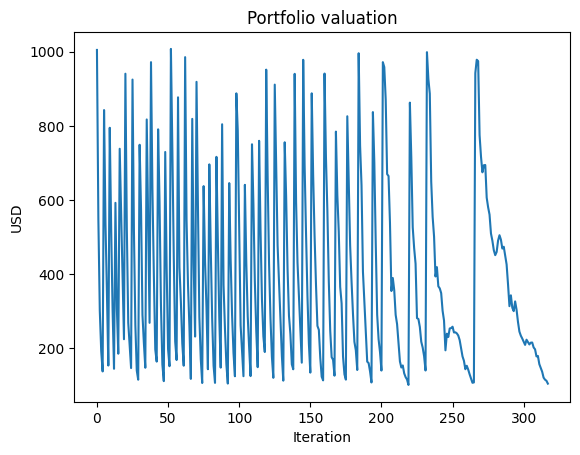

In [122]:
plt.plot(portfolio_valuation)
plt.xlabel('Iteration')
plt.ylabel('USD')
plt.title('Portfolio valuation')
plt.show()

In [ ]:
 target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
import numpy as np

def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        # Ensure state is a numpy array and has the correct shape for model.predict
        if not isinstance(state, np.ndarray):
            state = np.array(state[0])
        if len(state.shape) == 1: # If state is a 1D array, add an extra dimension
            state = state[np.newaxis, :]
        
        Q_values = model.predict(state, verbose=False)
        return np.argmax(Q_values[0])

In [ ]:
from collections import deque

replay_buffer = deque(maxlen=len(df))

In [ ]:
def extract_array(output):
    if isinstance(output, tuple) and len(output) == 2:
        array, obj = output
        if isinstance(array, list) or isinstance(array, np.ndarray):
            if isinstance(obj, dict):
                return array
    return output

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones, truncatedes = [
        np.array([extract_array(experience[field_index]) for experience in batch])
        for field_index in range(6)
    ]
    return states, actions, rewards, next_states, dones, truncatedes

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [ ]:
batch_size = 64
discount_factor = 0.3
optimizer = keras.optimizers.Adam(learning_rate=1e-5 )
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncatedes = experiences
    next_Q_values = model.predict(next_states, verbose=False)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, env.action_space.n).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=False) * next_mask).sum(axis=1)
    target_Q_values = (rewards + (1 - truncatedes) * discount_factor * next_best_Q_values)
    mask = tf.one_hot(actions, env.action_space.n)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
import logging

# Disable logging
logging.disable(logging.CRITICAL)

for episode in range(50):
    obs = env.reset()
    for step in range(len(df)):
        epsilon = max(1 - episode / 50, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    if episode > 5:
        training_step(batch_size)
        print(f"Reward for episode: {episode} is {reward}")
    if episode % 5 == 0:
        target.set_weights(model.get_weights())

In [ ]:
env.unwrapped.get_metrics

In [ ]:
episode_data[-1]